In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
import math
import scipy
from numpy.random import choice, rand 
import math
import itertools
from sklearn.metrics import mean_squared_error

In [ ]:
rng = default_rng()

## 1.1.1 Epidemic on a known graph

In [ ]:
def get_known_graph(number_nodes,k): #method to obtain a symmetric k-regular 
                                    #undirected graph        
        
    graph = nx.cycle_graph(number_nodes) 

    for i in range(number_nodes):
        for j in range(1,int(k/2 +1)):
            graph.add_edge(i,((i+j) % number_nodes))
            graph.add_edge(i,((i-j) % number_nodes))
   
    return graph

In [ ]:
def epidemics_without_vacc(graph,beta, ro,number_weeks, initial_infected):
    #method to simulate the epidemic without the vaccinations
    W = nx.to_numpy_array(graph)
    number_nodes = graph.number_of_nodes()
    SIR = np.zeros((3, number_weeks+1)) #S is susceptible, I is infected and R is recovered
    new_I = np.zeros(number_weeks+1)
    #initialization of I as a subset of nodes randomly chosen
    I = rng.choice(np.arange(number_nodes), size=initial_infected, replace=False) 
    #initialization of SIR 
    SIR[0, 0] += number_nodes - initial_infected #row 0=Susceptible
    SIR[1, 0] += initial_infected # row 1=Infected
    new_I[0] += initial_infected # new Infected during the week
    past_week = np.zeros(number_nodes, dtype=int) #to store the situation 
                                                 #of the epidemic in the past week
    
    current_week = np.zeros(number_nodes, dtype=int) # to store the situation
                                                     # of the epidemic in the current week
    past_week[I] = 1 #the first past week is equal to I
    for i in range(1, number_weeks+1): # iterate from week 1 to week 15
        
        S = np.nonzero(past_week == 0)[0] # S are nodes with state equal to 0
        I = np.nonzero(past_week == 1)[0] # I are nodes with state equal to 1
        R = np.nonzero(past_week== 2)[0] # R are nodes with state equal to 2
        
        number_I = 0 #to known how many infected nodes there are
        for c in past_week: #cycle for to obtain number_I as the number of infected nodes
                            # in the past week
            if c==1:
                number_I = number_I +1
        
        #neig_I = neighbors of infected nodes
        neigh_I = W[:, I] @ np.ones(number_I) 
        
        for j in S: #to find new I
            S_not_I = (1-beta)**neigh_I[j] #probability to not became infected
            #new Infected are chosen according to the probability defined above
            current_week[j] = rng.choice([0, 1], p=[S_not_I, (1-S_not_I)]) 
         
            if current_week[j] == 1:
                new_I[i] += 1
        for h in I: #to find new Recovered
            I_not_R = 1 - ro #probability to not recover
            #new Recovered are chosen according to the probability defined above
            current_week[h] = rng.choice([1, 2], p=[I_not_R, (1-I_not_R)]) 
        
        currentS = 0
        currentI = 0
        currentR = 0
        for c in current_week:
            if c == 0:
                currentS = currentS + 1 #to store the current Susceptibles
            if c == 1:
                currentI = currentI + 1 #to store the current Infected
            if c == 2:
                currentR = currentR + 1 #to store the current Recovered
        #SIR is updated with the current values
        SIR[0, i] = currentS
        SIR[1, i] = currentI
        SIR[2, i] = currentR
        past_week = current_week #past week updated
    return SIR, new_I

In [ ]:
def getAvgsAndPlotKnownGraph(number_nodes, k, beta, ro, number_weeks, initial_infected, N):
    #method to get the newly infected nodes each week 
    #and the total number of SIR at each week
    SIR = np.zeros((3, number_weeks+1))
    new_I_per_week = np.zeros(number_weeks+1)
    
    for n in range(N): #iterates for N simulations
        
        graph = get_known_graph(number_nodes,k) #to define the graph
        sir, new_I = epidemics_without_vacc(graph,beta, #to simulate the epidemic
                                         ro,number_weeks, 
                                         initial_infected)
        #to update SIR                            
        SIR += sir 
        #to update new_I_per_week
        new_I_per_week +=  new_I
    #the two averages are computed
    avg_SIR = SIR/N 
    avg_new_I_per_week = new_I_per_week/N
    #plot of the average number of newly I individuals each week
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title("The average number of newly I individuals each week.")
    ax.plot(np.arange(len(avg_new_I_per_week)), avg_new_I_per_week, label='New I (infected) per week')
    
    ax.legend(fontsize=10)
    ax.set_xlabel('Time (week)', fontsize=14)
    ax.set_ylabel('New infected people', fontsize=14)
    plt.savefig("AvgsAndPlotKnownGraph_a.pdf")
    
    #plot of the average total number of S, I, and R individuals at each week
    fig, ax = plt.subplots(figsize=(10,10))
    labels = {0: 'S=Susceptibles', 1:'I=Infected', 2:'R=Recovered'}
    for i in [0, 1, 2]:
        lab = str(labels[i])
        ax.plot(np.arange(avg_SIR.shape[1]), avg_SIR[i, :], label=lab)
    
    plt.title("The average total number of S, I, and R individuals at each week.")
    ax.legend(fontsize=10)
    ax.set_xlabel('Time (week)', fontsize=14)
    ax.set_ylabel('S,I,R people', fontsize=14) 
    plt.savefig("AvgsAndPlotKnownGraph_b.pdf")
    return avg_SIR,avg_new_I_per_week 

## 1.1.2 Generate a random graph

In [ ]:
def get_random_graph(number_nodes,k): 
    #function to get a random complete graph with average degree=k
    random_graph = nx.complete_graph(k+1) #initial graph
    for i in range(k+1, number_nodes): # iterate to add new nodes
        n_degrees = np.array([x for z,x in random_graph.degree()]) #to obtain the degrees
        p_degrees = n_degrees/np.sum(n_degrees) #to obtain the probability, 
                                                #used to add a new edge
        avg_degree = np.average(n_degrees) #average degree of the graph
        if i%2 == 0: #if i is even
            c = math.floor(k/2) 
        else: #if i is odd
            c = math.ceil(k/2) 
        
        #neighbors of the node are randomply chosen according to p_degrees
        neigh = rng.choice(np.arange(random_graph.number_of_nodes()), size=c, 
                                replace=False, p=p_degrees) 
        for j in neigh:#add an edge between i and its neighbor j
            random_graph.add_edge(i, j) 
        
    
    return random_graph,avg_degree

# 1.2 Pandemic without vaccination

In [ ]:
def getAvgsAndPlotRandomGraph(number_nodes,k,beta,ro,number_weeks, initial_infected,N):
    #method to get the newly infected nodes each week 
    #and the total number of SIR at each week with a random complete graph
    SIR = np.zeros((3, number_weeks+1))
    new_I_per_week = np.zeros(number_weeks+1)
    
    for n in range(N):
        
        graph, avgDegree = get_random_graph(number_nodes,k) #to define a random graph
        sir, new_In = epidemics_without_vacc(graph,beta, #to simulate the epidemic on the graph
                                         ro,number_weeks,  
                                         initial_infected)
        #to update SIR                             
        SIR += sir
        #to update new_I_per_week
        new_I_per_week +=  new_In
    #to compute the two averages
    avg_SIR = SIR/N 
    avg_new_I_per_week = new_I_per_week/N
    
    #plot of the average number of newly I individuals each week
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title("The average number of newly I individuals each week.")
    ax.plot(np.arange(len(avg_new_I_per_week)), avg_new_I_per_week, label='New I (infected) per week')
    ax.legend(fontsize=10)
    
    ax.set_xlabel('Time (week)', fontsize=14)
    ax.set_ylabel('New infected people', fontsize=14)
    plt.savefig("AvgsAndPlotRandomGraph_a.pdf")
    
    
    #plot of the average total number of S, I, and R individuals at each week
    fig, ax = plt.subplots(figsize=(10,10))
    labels = {0: 'S=Susceptibles', 1:'I=Infected', 2:'R=recovered'}
    for i in [0, 1, 2]:
        lab = str(labels[i])
        ax.plot(np.arange(avg_SIR.shape[1]), avg_SIR[i, :], label=lab)
    
    plt.title("The average total number of S, I, and R individuals at each week.")
    ax.legend(fontsize=10)
    ax.set_xlabel('Time (week)', fontsize=14)
    ax.set_ylabel('S,I,R people', fontsize=14) 
    plt.savefig("AvgsAndPlotRandomGraph_b.pdf")
    return avg_SIR,avg_new_I_per_week

# 1.3 Pandemic with vaccination

In [ ]:
def epidemics_with_vacc(graph,beta, ro,number_weeks, initial_infected,vacc):
    #method to simulate the epidemic with the vaccinations
    W = nx.to_numpy_array(graph)
    number_nodes = graph.number_of_nodes()
    SIR = np.zeros((3, number_weeks+1)) 
    new_I = np.zeros(number_weeks+1)
    I = rng.choice(np.arange(number_nodes), size=initial_infected, replace=False) 
    
    
    
    SIR[0, 0] += number_nodes - initial_infected 
    SIR[1, 0] += initial_infected 
    new_I[0] += initial_infected 
    #vaccinations are introduced
    NV = np.ones(number_nodes) # non vaccinated nodes (at the beginning nobody is vaccinated)
    
    
    past_week = np.zeros(number_nodes, dtype=int)
    past_week[I] = 1 
    current_week = np.zeros(number_nodes, dtype=int) 
       
    for i in range(1, number_weeks+1): # iterate from week 1 to week 15
                    
        # vaccinated nodes are chosen randomly
        V = rng.choice(np.nonzero((NV==1))[0], size=int(vacc[i-1]*number_nodes/100), replace=False)
        #non vaccinated nodes are updated
        NV[V] = 0 
         
        current_week[V] = 2 # vaccinated nodes are recovered
        past_week[V] = 2 # vaccinated nodes are recovered
        number_I = 0
        for c in past_week: #to obtain number of Infected nodes
            if c == 1:
                number_I = number_I +1
        
       
        S = np.nonzero(past_week == 0)[0] # S=0
        I = np.nonzero(past_week == 1)[0] # I=1
        R = np.nonzero(past_week == 2)[0] # R=2
        #neig_I = neighbors of infected nodes
        neigh_I = W[:, I] @ np.ones(number_I) 
 
        for j in S:
            S_not_I = (1-beta)**neigh_I[j] 
            current_week[j] = rng.choice([0, 1], p=[S_not_I, (1-S_not_I)]) 
            if current_week[j] == 1:
                new_I[i] += 1
        for h in I:
            I_not_R = 1 - ro
            current_week[h] = rng.choice([1, 2], p=[I_not_R, (1-I_not_R)]) 
        # SIR is updated
        currentS = 0
        currentI = 0
        currentR = 0
        for c in current_week:
            if c == 0:
                currentS = currentS + 1
            if c == 1:
                currentI = currentI + 1
            if c == 2:
                currentR = currentR + 1
            
        SIR[0, i] = currentS
        SIR[1, i] = currentI
        SIR[2, i] = currentR
        past_week = current_week #past week is updated
        
    return SIR, new_I

In [ ]:
def getAvgsAndPlotRandomGraphVacc(number_nodes,k,beta,ro,number_weeks, initial_infected,N,vacc1,vacc2,vacc):
    #method to get the newly infected nodes each week 
    #and the total number of SIR at each week with a random complete graph with vaccinations
    SIR = np.zeros((3, number_weeks+1))
    new_I_per_week = np.zeros(number_weeks+1)
    
    for n in range(N): #iterate for N simulations
        
        random_graph,avg_degree = get_random_graph(number_nodes,k) #to obtain the graph
        sir, new_In = epidemics_with_vacc(random_graph,beta, #to simulate the epidemic with vaccinations
                                         ro,number_weeks, 
                                         initial_infected,
                                         vacc 
                                         )
        #update SIR and new_I_per_week
        SIR += sir
        new_I_per_week +=  new_In
    #compute the two averages
    avg_SIR = SIR/N 
    avg_new_I_per_week = new_I_per_week/N
    
    #plot of the average number of newly I individuals each week
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title("The average number of newly I and V individuals each week.")
    ax.plot(np.arange(len(avg_new_I_per_week)), avg_new_I_per_week, label='New I (infected) per week')
    ax.plot(np.arange(len(avg_new_I_per_week)), vacc1, label='New V (vaccinated) per week')
    ax.legend(fontsize=10)
    ax.set_xlabel('Time (week)', fontsize=14)
    ax.set_ylabel('New I (infected) and V (vaccinated) people', fontsize=14)
    plt.savefig("AvgsAndPlotRandomGraphVacc3_a.pdf")
    
    #plot of the average total number of S, I, and R individuals at each week
    fig, ax = plt.subplots(figsize=(10,10))
    labels = {0: 'S=Susceptibles', 1:'I=Infected', 2:'R=Recovered'}
    for i in [0, 1, 2]:
        lab = str(labels[i])
        ax.plot(np.arange(avg_SIR.shape[1]), avg_SIR[i, :], label=lab)
    ax.plot(np.arange(avg_SIR.shape[1]), vacc2, label='V=Vaccinated')
    plt.title("The average total number of S, I, and R and V individuals at each week.")
    ax.legend(fontsize=10)
    ax.set_xlabel('Time (week)', fontsize=14)
    ax.set_ylabel('S,I,R,V people', fontsize=14) 
    plt.savefig("AvgsAndPlotRandomGraphVacc3_b.pdf")
    return avg_SIR,avg_new_I_per_week 

# 1.4 H1N1 Pandemic in Sweden 2009

In [ ]:
def get_best_params(epochs, n_sim, num_nodes, num_weeks, vacc_per_week, gt_infected,
                               k_0, beta_0, rho_0, delta_k, delta_b, delta_r):
    """
    - epochs: total number of iterations to improve the parameters, starting from different parameters spaces
    - n_sim: number of simulations of different epidemics on different graphs along 1 epoch
    - num_nodes = dimension of population
    - vacc_per_week: array of Vaccinated each week
    - gt_infected: array with real number of Infected nodes each week
    - k: number to which the average degree of the graph is close
    - beta = [0,1]: probability that the infection is spread from an Infected node to a Susceptible one
    - ro = [0,1]: probability for an Infected node to become Recovered
    - k_0, beta_0, rho_0: initial parameters
    - delta_k, delta_b, delta_r: variations of parameters
    """

    # init: set of parameters
    actual_best_params = [k_0, beta_0, rho_0] # the best ones in the actual epoch among the n_sim simulations
    global_best_params = [k_0, beta_0, rho_0] # the best ones among all the epochs
    # init: RMSE
    global_best_RMSE = np.inf # the best one among all the epochs
    e = 0
    while e < epochs:
        e+=1
        print(f'-- Epoch {e} --')
        param_space = np.array([[global_best_params[0], global_best_params[0] + delta_k, global_best_params[0] - delta_k],
                          [global_best_params[1], global_best_params[1] + delta_b, global_best_params[1] - delta_b],
                          [global_best_params[2], global_best_params[2] + delta_r, global_best_params[2] - delta_r]])

        actual_min_RMSE = global_best_RMSE # the best one in the actual epoch among the n_sim simulations
        for k, b, r in list(itertools.product(*param_space)): # all the possible combinations of parameters
            if k>0 and b>0 and r>0 and b<=1 and r<=1: # only valid parameters are considered
                # init: total number of newly Infected individuals each week in the "n_sim" simulations made
                tot_new_I = np.zeros(num_weeks+1)
                for s in range(n_sim): # run "n_sim" simulations with b,r parameters
                    G,avg_D = get_random_graph(num_nodes, int(k))
                    SIR, new_I = epidemics_with_vacc(graph=G, beta=b, ro=r, number_weeks=num_weeks,
                                                   initial_infected=gt_infected[0], vacc=vacc_per_week)
                    tot_new_I += new_I # update
                tot_new_I = tot_new_I/n_sim # avg number of newly Infected each week in the "n_sim" simulations made
                RMSE = mean_squared_error(gt_infected[1:], tot_new_I[1:], squared=False) # t = from 1 to 15
                print(f"\t(beta={round(b,3)}, ro={round(r,3)}, k={round(k,3)}) RMSE = {RMSE};")
                if RMSE < actual_min_RMSE: # if the RMSE found is the minimum
                    # update the best RMSE with the relative parameters
                    actual_min_RMSE = RMSE
                    actual_best_params[0] = k
                    actual_best_params[1] = b
                    actual_best_params[2] = r
        print(f'\n\tMinimum RSE = {actual_min_RMSE} found with parameters '
              f'(beta={round(actual_best_params[1],3)}, ro={round(actual_best_params[2],3)}, k={round(actual_best_params[0],3)})')

        # if better parameters are not found
        if global_best_params[0] == actual_best_params[0] and \
                global_best_params[1] == actual_best_params[1] and \
                global_best_params[2] == actual_best_params[2]:
            # stop the epochs if deltas are very small
            if delta_b-delta_b/2 < 0.003 and delta_r-delta_r/2 < 0.003:
                break
            # decrease parameters by half to restrict the search
            delta_b = delta_b/2
            delta_r = delta_r/2
            delta_k = math.ceil(delta_k/2) # k must be an integer
        # if the actual (of this epoch) minimum RMSE is the minimum among all the epochs already run
        if actual_min_RMSE < global_best_RMSE:
            # this configuration is the best one among all the epochs already run
            global_best_params[0] = actual_best_params[0]
            global_best_params[1] = actual_best_params[1]
            global_best_params[2] = actual_best_params[2]
            global_best_RMSE = actual_min_RMSE

        print("\n")
        
    return global_best_params[0], global_best_params[1], global_best_params[2]

In [ ]:
def best_rmse_for_plotting(k_best, beta_best, rho_best):
  e=0
  min_rmse = np.inf

  while e<20: 
      e+=1
      SIR = np.zeros((3, number_weeks+1))
      new_I_per_week = np.zeros(number_weeks+1)
      
      for n in range(50):
          random_graph,avg_degree = get_random_graph(n_nodes,int(k_best))
          sir, new_In = epidemics_with_vacc(random_graph,beta_best, 
                                          rho_best,15, 
                                          real_infected[0],
                                          frac_vacc)
          SIR += sir
          new_I_per_week += new_In

      avg_SIR = SIR/50 
      avg_new_I_per_week = new_I_per_week/50

      rmse = mean_squared_error(real_infected[1:], avg_new_I_per_week[1:], squared=False)
      if rmse < min_rmse:
          min_rmse = rmse
          best_a1 = avg_SIR
          best_a2 = avg_new_I_per_week

  return min_rmse, best_a1, best_a2

In [ ]:
def plot_best_prevision(best_a1, best_a2):
  fig, ax = plt.subplots(figsize=(10,10))
  ax.plot(np.arange(len(best_a2)), best_a2, label='New I (infected) per week')
  ax.plot(np.arange(len(best_a2)), real_infected, label='New true I (infected) per week')
  ax.legend(fontsize=10)
  ax.set_xlabel('Time (week)', fontsize=14)
  ax.set_ylabel('New I (infected) and true I (infected) people', fontsize=14)
  plt.savefig("AvgsAndPlotRandomGraphVacc_a.pdf")
      
      
  fig, ax = plt.subplots(figsize=(10,10))
  labels = {0: 'S=Susceptibles', 1:'I=Infected', 2:'R=Recovered'}
  for i in [0, 1, 2]:
          lab = str(labels[i])
          ax.plot(np.arange(best_a1.shape[1]), best_a1[i, :], label=lab)
  ax.plot(np.arange(best_a1.shape[1]), cum_vacc_per_week, label='V=Vaccinated')
  ax.legend(fontsize=10)
  ax.set_xlabel('Time (week)', fontsize=14)
  ax.set_ylabel('S,I,R,V people', fontsize=14) 
  plt.savefig("AvgsAndPlotRandomGraphVacc_b.pdf")

# 1.5 Generate a Small World Random Graph

In [ ]:
def get_small_world_graph(number_nodes, p, k):
  """
  - p: probability to add a link betweeen each couple of nodes
  - k: average degree of the graph close to
  """
  G = nx.cycle_graph(number_nodes) # circle graph with number_nodes nodes

  for n in range(number_nodes):
    for i in range(1, int(k/2+1)): 
          # the nodes of the links are chosen according to the sum and difference of an index i
          # that must be in the range (1, k/2+1) considering that for each node: #neighbors = k
          G.add_edge(n, ((n+i) % number_nodes))
          G.add_edge(n, ((n-i) % number_nodes))

  for i in range(number_nodes):
      for j in range(number_nodes):
          if i!=j and np.random.rand() < p:
            G.add_edge(i,j)

  # pos = nx.circular_layout(G)
  # nx.draw(G, pos, with_labels=True)
  # degrees = [tup[1] for tup in G.degree()]
  # print("Real average degree of the graph:", np.average(degrees))
  # print("Diameter:", nx.diameter(G))
  # print("Clustering coefficient", nx.average_clustering(G), "\n")

  return G

In [ ]:
def sw_get_best_params(epochs, n_sim, num_nodes, num_weeks, vacc_per_week, gt_infected,
                               p_0, k_0, beta_0, rho_0, delta_p, delta_k, delta_b, delta_r):
    """
    - epochs: total number of iterations to improve the parameters, starting from different parameters spaces
    - n_sim: number of simulations of different epidemics on different graphs along 1 epoch
    - num_nodes = dimension of population
    - vacc_per_week: array of Vaccinated each week
    - gt_infected: array with real number of Infected nodes each week
    - p: probability to add a link betweeen each couple of nodes
    - k: number to which the average degree of the graph is close
    - beta = [0,1]: probability that the infection is spread from an Infected node to a Susceptible one
    - ro = [0,1]: probability for an Infected node to become Recovered
    - k_0, beta_0, rho_0: initial parameters
    - delta_k, delta_b, delta_r: variations of parameters
    """

    # init: set of parameters
    actual_best_params = [k_0, beta_0, rho_0, p_0] # the best ones in the actual epoch among the n_sim simulations
    global_best_params = [k_0, beta_0, rho_0, p_0] # the best ones among all the epochs
    # init: RMSE
    global_best_RMSE = np.inf # the best one among all the epochs
    e = 0
    while e < epochs:
        e+=1
        print(f'-- Epoch {e} --')
        param_space = np.array([[global_best_params[0], global_best_params[0] + delta_k, global_best_params[0] - delta_k],
                          [global_best_params[1], global_best_params[1] + delta_b, global_best_params[1] - delta_b],
                          [global_best_params[2], global_best_params[2] + delta_r, global_best_params[2] - delta_r],
                          [global_best_params[3], global_best_params[3] + delta_p, global_best_params[3] - delta_p]])

        actual_min_RMSE = global_best_RMSE # the best one in the actual epoch among the n_sim simulations
        for k, b, r, p in list(itertools.product(*param_space)): # all the possible combinations of parameters
            if k>0 and b>0 and r>0 and p>=0 and b<=1 and r<=1 and p<=1: # only valid parameters are considered
                # init: total number of newly Infected individuals each week in the "n_sim" simulations made
                tot_new_I = np.zeros(num_weeks+1)
                for s in range(n_sim): # run "n_sim" simulations with b,r parameters
                    G = get_small_world_graph(num_nodes, p, int(k))
                    SIR, new_I = epidemics_with_vacc(graph=G, beta=b, ro=r, number_weeks=num_weeks,
                                                   initial_infected=gt_infected[0], vacc=vacc_per_week)
                    tot_new_I += new_I # update
                tot_new_I = tot_new_I/n_sim # avg number of newly Infected each week in the "n_sim" simulations made
                RMSE = mean_squared_error(gt_infected[1:], tot_new_I[1:], squared=False) # t = from 1 to 15
                print(f"\t(beta={round(b,3)}, ro={round(r,3)}, k={round(k,3)}, p={round(p,3)}) RMSE = {RMSE};")
                if RMSE < actual_min_RMSE: # if the RMSE found is the minimum
                    # update the best RMSE with the relative parameters
                    actual_min_RMSE = RMSE
                    actual_best_params[0] = k
                    actual_best_params[1] = b
                    actual_best_params[2] = r
                    actual_best_params[3] = p
        print(f'\n\tMinimum RSE = {actual_min_RMSE} found with parameters '
              f'(beta={round(actual_best_params[1],3)}, ro={round(actual_best_params[2],3)}, k={actual_best_params[0]}, p={actual_best_params[3]})')

        # if better parameters are not found
        if global_best_params[0] == actual_best_params[0] and \
                global_best_params[1] == actual_best_params[1] and \
                global_best_params[2] == actual_best_params[2] and \
                global_best_params[3] == actual_best_params[3]:
            # stop the epochs if deltas are very small
            if delta_b-delta_b/2 < 0.003 and delta_r-delta_r/2 < 0.003 and delta_p-delta_p/2 < 0.003:
                break
            # decrease parameters by half to restrict the search
            delta_b = delta_b/2
            delta_r = delta_r/2
            delta_p = delta_p/2
            delta_k = math.ceil(delta_k/2) # k must be an integer
        # if the actual (of this epoch) minimum RMSE is the minimum among all the epochs already run
        if actual_min_RMSE < global_best_RMSE:
            # this configuration is the best one among all the epochs already run
            global_best_params[0] = actual_best_params[0]
            global_best_params[1] = actual_best_params[1]
            global_best_params[2] = actual_best_params[2]
            global_best_params[3] = actual_best_params[3]
            global_best_RMSE = actual_min_RMSE

        print("\n")
        
    return global_best_params[0], global_best_params[1], global_best_params[2], global_best_params[3]

In [ ]:
def sw_best_rmse_for_plotting(k_best, beta_best, rho_best, p_best):
  e=0
  min_rmse = np.inf

  while e<20: 
      e+=1
      SIR = np.zeros((3, number_weeks+1))
      new_I_per_week = np.zeros(number_weeks+1)
      
      for n in range(50):
          G = get_small_world_graph(n_nodes, p_best, int(k_best))
          sir, new_In = epidemics_with_vacc(G,beta_best, 
                                          rho_best,15, 
                                          real_infected[0],
                                          frac_vacc)
          SIR += sir
          new_I_per_week += new_In

      avg_SIR = SIR/50 
      avg_new_I_per_week = new_I_per_week/50

      rmse = mean_squared_error(real_infected[1:], avg_new_I_per_week[1:], squared=False)
      if rmse < min_rmse:
          min_rmse = rmse
          best_a1 = avg_SIR
          best_a2 = avg_new_I_per_week

  return min_rmse, best_a1, best_a2

## Problem 1.1

In [ ]:
number_nodes = 500
k = 4
beta = 0.3
ro = 0.7
number_weeks = 15
initial_infected = 10
N = 100

In [ ]:
known_graph = get_known_graph(number_nodes, k)

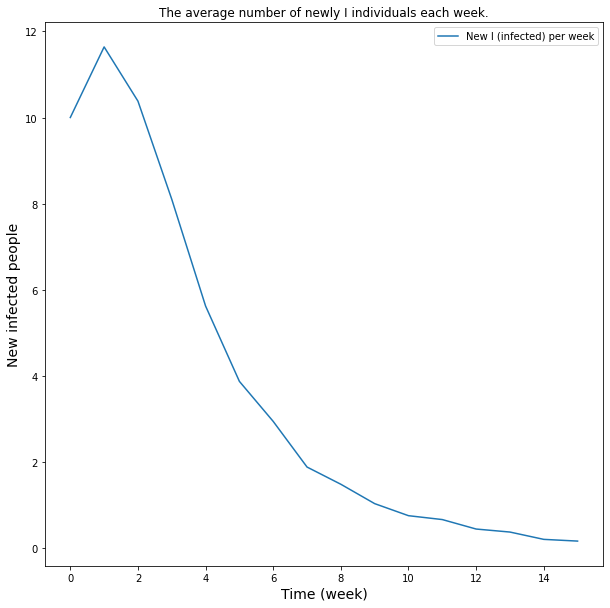

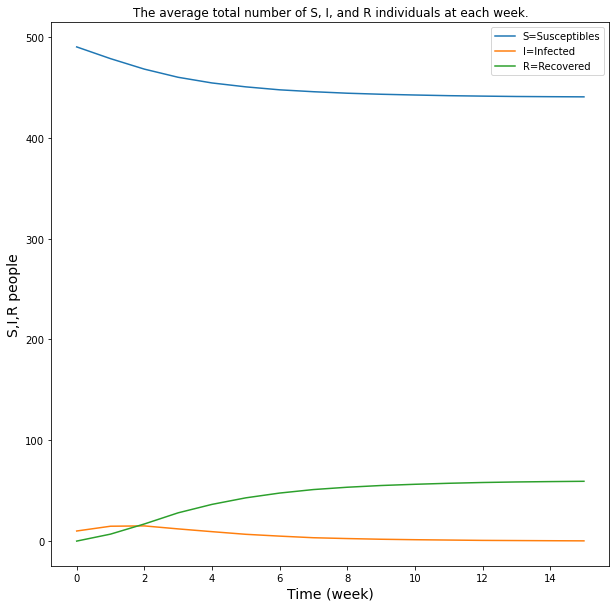

In [ ]:
avg_SIR, avg_new_I_per_week = getAvgsAndPlotKnownGraph(number_nodes, k, beta, ro, number_weeks, initial_infected, N)

## Problem 1.2

In [ ]:
number_nodes = int(np.random.rand()*rng.integers(900)+900) #at least 900 nodes
print("Number of nodes = ",number_nodes)
k = rng.integers(1,high=10)
print("Average degree k =", k)

Number of nodes =  1078
Average degree k = 2


In [ ]:
random_graph, avg_degree = get_random_graph(number_nodes,k)
print("Created random graph with", number_nodes,"nodes and average degree equals to",avg_degree,"( k =",k,").")

Created random graph with 1078 nodes and average degree equals to 2.0 ( k = 2 ).


## Problem 2

In [ ]:
number_nodes = 500
k = 6
beta = 0.3
ro = 0.7
number_weeks = 15
initial_infected = 10
N = 100

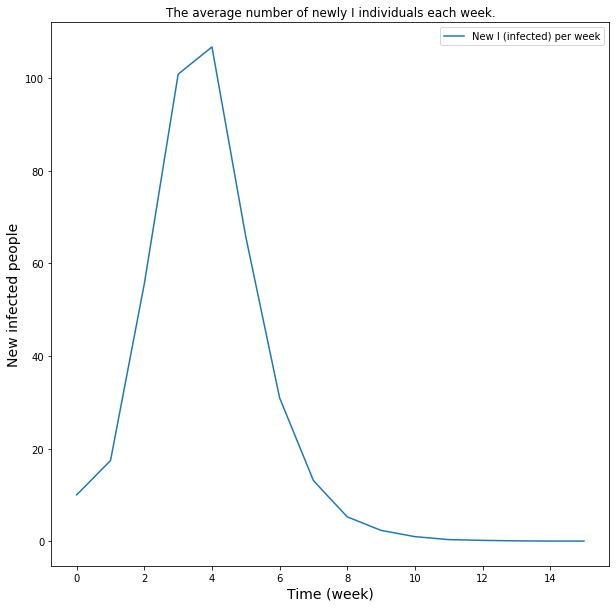

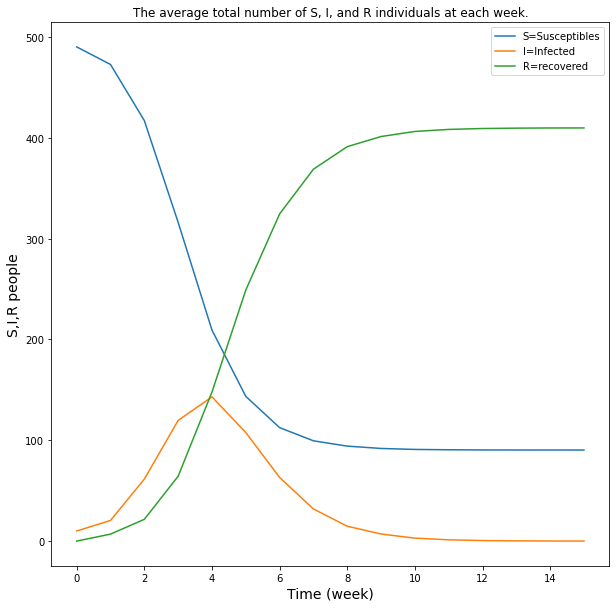

In [ ]:
avg_SIR2, avg_new_I_per_week2 = getAvgsAndPlotRandomGraph(number_nodes, k, beta, ro, number_weeks, initial_infected, N)

## Problem 3

In [ ]:
vaccinations_percentages = [0 ,0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60] # cumulative %
vacc = np.diff(vaccinations_percentages) # not cumulative %
print("People to be vaccinated per week:",vacc)

People to be vaccinated per week: [ 0  5 10 10 10 10 10  5  0  0  0  0  0  0  0]


In [ ]:
number_nodes = 500
k = 6
beta = 0.3
ro = 0.7
number_weeks = 15
initial_infected = 10
N = 100

In [ ]:
vacc1 = [int(number_nodes/100)*vaccinations_percentages[0]] + list(vacc*int(number_nodes/100)) # not cumulative
vacc2 = list(int(number_nodes/100)*np.array(vaccinations_percentages)) # cumulative

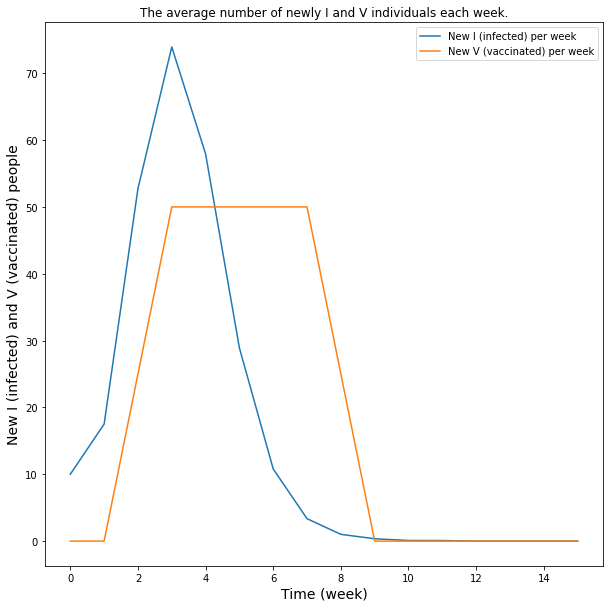

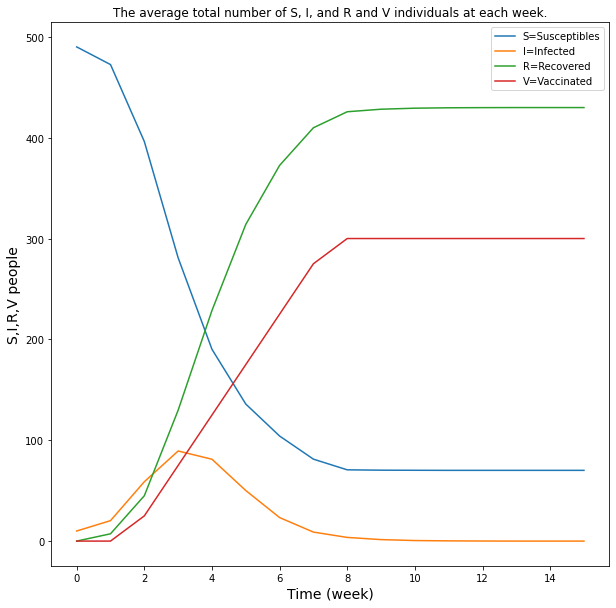

In [ ]:
avg_SIR3,avg_new_I_per_week3 = getAvgsAndPlotRandomGraphVacc(number_nodes,k,beta,ro,number_weeks,
                                                             initial_infected,N,vacc1,vacc2,vacc)

##Problem 4

In [ ]:
n_nodes = 934
vacc = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60] # cumulative % of vaccinated per week
frac_vacc = np.diff(vacc) # not cumulative % of vaccinated per week
real_infected = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
number_weeks = 15
N = 100

In [ ]:
vacc_per_week = [n_nodes/100*vacc[0]] + list((n_nodes/100)*frac_vacc) # number of vaccinated per week
cum_vacc_per_week = list(n_nodes/100*np.array(vacc)) # cumulative number of vaccinated per week

$k_0=10, \ \beta_0=0.5, \ \rho_0=0.5$

$\Delta k=9, \Delta \beta=0.4, \Delta \rho=0.4$

In [ ]:
k_best, beta_best, rho_best = get_best_params(epochs=20, n_sim=50, num_nodes=n_nodes, num_weeks=15,
                                              vacc_per_week=frac_vacc, gt_infected=real_infected,
                               k_0=10, beta_0=0.5, rho_0=0.5, delta_k=9, delta_b=0.4, delta_r=0.4)

-- Epoch 1 --
	(beta=0.5, ro=0.5, k=10.0) RMSE = 82.4667858797306;
	(beta=0.5, ro=0.9, k=10.0) RMSE = 72.64047944041486;
	(beta=0.5, ro=0.1, k=10.0) RMSE = 90.51237764342878;
	(beta=0.9, ro=0.5, k=10.0) RMSE = 119.14240711574251;
	(beta=0.9, ro=0.9, k=10.0) RMSE = 120.2030453302522;
	(beta=0.9, ro=0.1, k=10.0) RMSE = 110.69334240745165;
	(beta=0.1, ro=0.5, k=10.0) RMSE = 10.4776116871483;
	(beta=0.1, ro=0.9, k=10.0) RMSE = 12.480950818480672;
	(beta=0.1, ro=0.1, k=10.0) RMSE = 10.598178459842364;
	(beta=0.5, ro=0.5, k=19.0) RMSE = 116.91149005408609;
	(beta=0.5, ro=0.9, k=19.0) RMSE = 117.14543041308384;
	(beta=0.5, ro=0.1, k=19.0) RMSE = 108.82871912627965;
	(beta=0.9, ro=0.5, k=19.0) RMSE = 144.5256373104786;
	(beta=0.9, ro=0.9, k=19.0) RMSE = 138.41568148154312;
	(beta=0.9, ro=0.1, k=19.0) RMSE = 139.13413211717676;
	(beta=0.1, ro=0.5, k=19.0) RMSE = 10.533366666613924;
	(beta=0.1, ro=0.9, k=19.0) RMSE = 5.894569252003633;
	(beta=0.1, ro=0.1, k=19.0) RMSE = 26.424394285079334;
	(bet

In [ ]:
print(f'Best parameters: kappa = {k_best}, beta = {beta_best}, rho = {rho_best}.')

Best parameters: kappa = 19.0, beta = 0.09687499999999998, rho = 0.896875.


In [ ]:
min_rmse, best_a1, best_a2 = best_rmse_for_plotting(k_best, beta_best, rho_best)
min_rmse, best_a1, best_a2

(5.992188248044283,
 array([[9.3300e+02, 8.9432e+02, 8.2558e+02, 7.4166e+02, 6.5056e+02,
         5.5498e+02, 4.7170e+02, 3.9740e+02, 3.5056e+02, 3.3850e+02,
         3.3554e+02, 3.3366e+02, 3.3232e+02, 3.3116e+02, 3.3058e+02,
         3.3022e+02],
        [1.0000e+00, 1.8000e+00, 4.0600e+00, 1.0800e+01, 2.0080e+01,
         2.6680e+01, 2.7200e+01, 2.0020e+01, 1.0380e+01, 5.7200e+00,
         3.6400e+00, 2.3200e+00, 1.5000e+00, 1.2600e+00, 7.2000e-01,
         4.2000e-01],
        [0.0000e+00, 3.7880e+01, 1.0436e+02, 1.8154e+02, 2.6336e+02,
         3.5234e+02, 4.3510e+02, 5.1658e+02, 5.7306e+02, 5.8978e+02,
         5.9482e+02, 5.9802e+02, 6.0018e+02, 6.0158e+02, 6.0270e+02,
         6.0336e+02]]),
 array([ 1.  ,  1.68,  3.9 , 10.4 , 18.88, 25.1 , 24.66, 17.32,  8.62,
         4.82,  2.96,  1.88,  1.34,  1.16,  0.58,  0.36]))

In [ ]:
for i in range(1,len(best_a1[2])):
  best_a1[2][i] = best_a1[2][i]+cum_vacc_per_week[0]

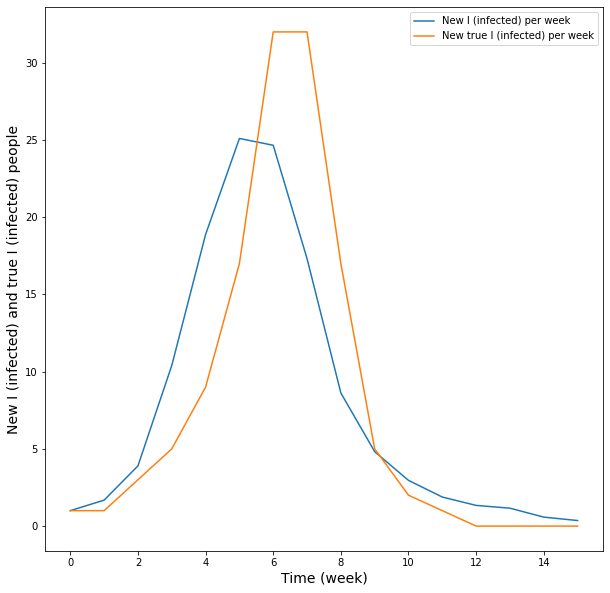

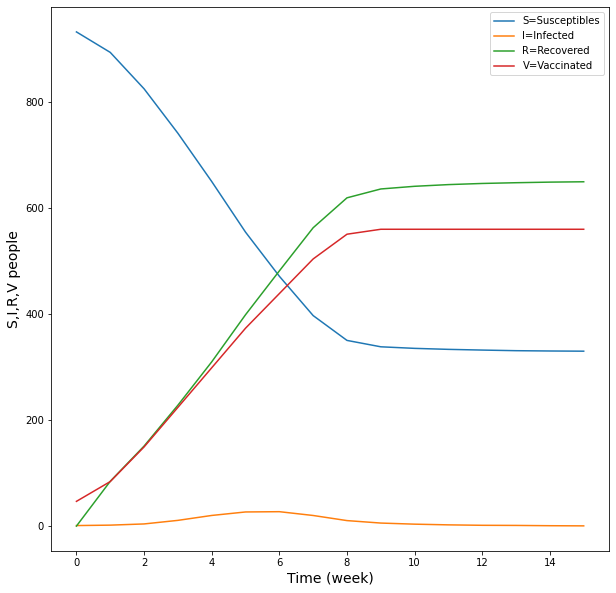

In [ ]:
plot_best_prevision(best_a1, best_a2)

In [ ]:
min_rmse, best_a1, best_a2 = best_rmse_for_plotting(k_best, beta_best, rho_best)
min_rmse, best_a1, best_a2

(5.354758631348383,
 array([[9.3300e+02, 8.9402e+02, 8.2474e+02, 7.4174e+02, 6.5350e+02,
         5.6088e+02, 4.7892e+02, 4.0324e+02, 3.5336e+02, 3.3978e+02,
         3.3582e+02, 3.3330e+02, 3.3170e+02, 3.3056e+02, 3.2986e+02,
         3.2916e+02],
        [1.0000e+00, 2.1000e+00, 4.6600e+00, 9.9000e+00, 1.6840e+01,
         2.3020e+01, 2.4960e+01, 2.0280e+01, 1.3080e+01, 7.5600e+00,
         4.5800e+00, 3.0800e+00, 1.9200e+00, 1.3600e+00, 8.4000e-01,
         7.4000e-01],
        [0.0000e+00, 3.7880e+01, 1.0460e+02, 1.8236e+02, 2.6366e+02,
         3.5010e+02, 4.3012e+02, 5.1048e+02, 5.6756e+02, 5.8666e+02,
         5.9360e+02, 5.9762e+02, 6.0038e+02, 6.0208e+02, 6.0330e+02,
         6.0410e+02]]),
 array([ 1.  ,  2.  ,  4.44,  9.58, 15.92, 21.52, 22.58, 17.9 , 10.88,
         6.32,  3.96,  2.52,  1.6 ,  1.14,  0.7 ,  0.7 ]))

In [ ]:
for i in range(1,len(best_a1[2])):
  best_a1[2][i] = best_a1[2][i]+cum_vacc_per_week[0]

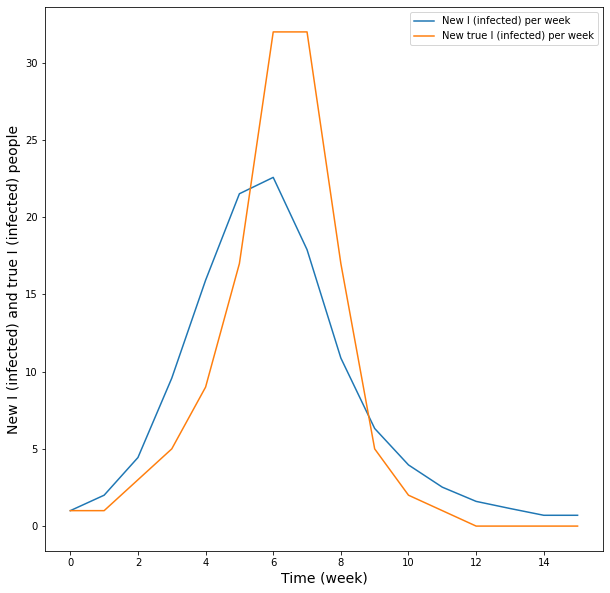

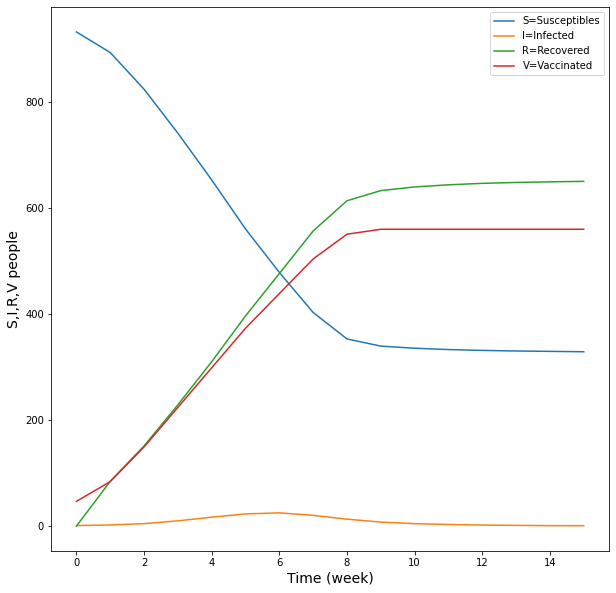

In [ ]:
plot_best_prevision(best_a1, best_a2)

$k_0=8, \ \beta_0=0.2, \ \rho_0=0.6$

$\Delta k=2, \Delta \beta=0.2, \Delta \rho=0.2$

In [ ]:
k_best, beta_best, rho_best = get_best_params(epochs=20, n_sim=50, num_nodes=n_nodes, num_weeks=15,
                                              vacc_per_week=frac_vacc, gt_infected=real_infected,
                               k_0=8, beta_0=0.2, rho_0=0.6, delta_k=2, delta_b=0.2, delta_r=0.2)

-- Epoch 1 --
	(beta=0.2, ro=0.6, k=8.0) RMSE = 9.300057347493437;
	(beta=0.2, ro=0.8, k=8.0) RMSE = 7.272635469117551;
	(beta=0.2, ro=0.4, k=8.0) RMSE = 7.1021517866066475;
	(beta=0.4, ro=0.6, k=8.0) RMSE = 48.46730114211024;
	(beta=0.4, ro=0.8, k=8.0) RMSE = 43.09928723308543;
	(beta=0.4, ro=0.4, k=8.0) RMSE = 46.45575500767729;
	(beta=0.2, ro=0.6, k=10.0) RMSE = 13.13337021991436;
	(beta=0.2, ro=0.8, k=10.0) RMSE = 10.447191648157572;
	(beta=0.2, ro=0.4, k=10.0) RMSE = 17.34743093371465;
	(beta=0.4, ro=0.6, k=10.0) RMSE = 60.47349347717009;
	(beta=0.4, ro=0.8, k=10.0) RMSE = 51.531273352531606;
	(beta=0.4, ro=0.4, k=10.0) RMSE = 63.599837735642055;
	(beta=0.2, ro=0.6, k=6.0) RMSE = 9.135152616860506;
	(beta=0.2, ro=0.8, k=6.0) RMSE = 11.766389420718658;
	(beta=0.2, ro=0.4, k=6.0) RMSE = 6.8083811095834905;
	(beta=0.4, ro=0.6, k=6.0) RMSE = 21.670984595383143;
	(beta=0.4, ro=0.8, k=6.0) RMSE = 23.497090883766866;
	(beta=0.4, ro=0.4, k=6.0) RMSE = 26.643898613628853;

	Minimum RSE = 6

In [ ]:
print(f'Best parameters: kappa = {k_best}, beta = {beta_best}, rho = {rho_best}.')

Best parameters: kappa = 8.0, beta = 0.20625000000000002, rho = 0.6.


In [ ]:
min_rmse, best_a1, best_a2 = best_rmse_for_plotting(k_best, beta_best, rho_best)
min_rmse, best_a1, best_a2

(4.95154386698398,
 array([[933.  , 894.5 , 825.28, 742.62, 652.22, 555.52, 466.98, 388.52,
         334.8 , 317.38, 310.62, 305.68, 302.16, 298.94, 297.08, 296.02],
        [  1.  ,   1.94,   5.18,  11.06,  21.8 ,  33.88,  41.02,  38.44,
          30.2 ,  21.78,  15.54,  11.36,   8.62,   6.32,   4.26,   2.78],
        [  0.  ,  37.56, 103.54, 180.32, 259.98, 344.6 , 426.  , 507.04,
         569.  , 594.84, 607.84, 616.96, 623.22, 628.74, 632.66, 635.2 ]]),
 array([ 1.  ,  1.54,  4.34,  9.18, 18.04, 26.18, 29.12, 23.3 , 15.84,
        10.6 ,  6.76,  4.94,  3.52,  3.22,  1.86,  1.06]))

In [ ]:
for i in range(1,len(best_a1[2])):
  best_a1[2][i] = best_a1[2][i]+cum_vacc_per_week[0]

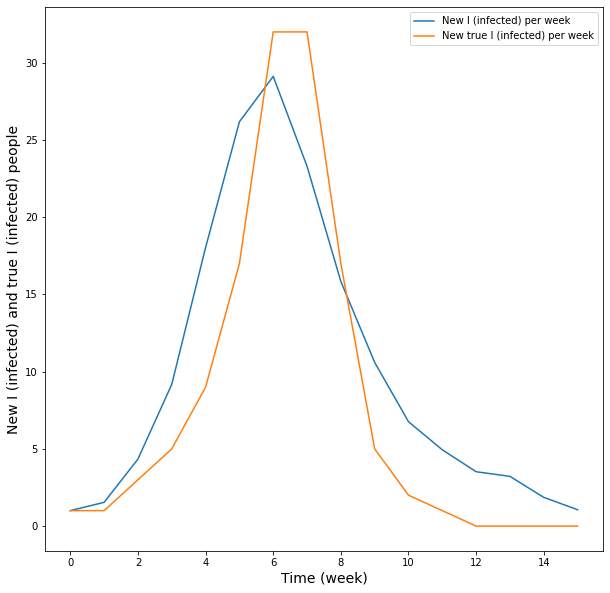

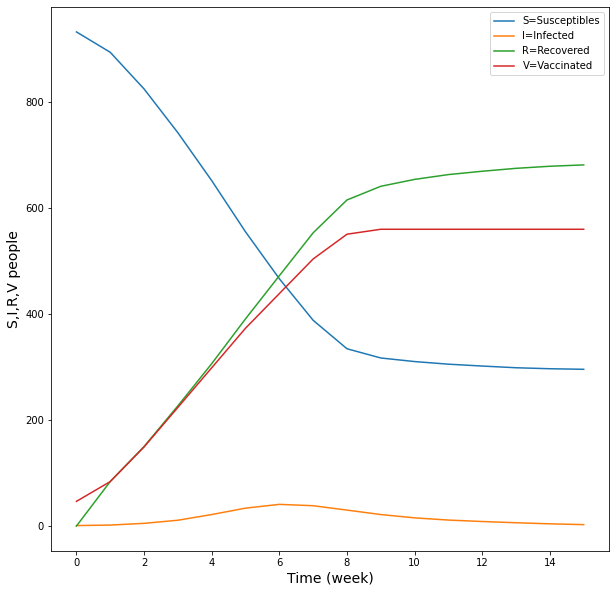

In [ ]:
plot_best_prevision(best_a1, best_a2)

## 1.5 Challenge

In [ ]:
k_best, beta_best, rho_best, p_best = sw_get_best_params(epochs=20, n_sim=30, num_nodes=n_nodes, num_weeks=15,
                                                         vacc_per_week=frac_vacc, gt_infected=real_infected,
                                                         p_0=0.02, k_0=10, beta_0=0.5, rho_0=0.5, delta_p=0.01, delta_k=9, delta_b=0.4, delta_r=0.4)

-- Epoch 1 --
	(beta=0.5, ro=0.5, k=10.0, p=0.02) RMSE = 131.3091982899734;
	(beta=0.5, ro=0.5, k=10.0, p=0.03) RMSE = 137.11712565594476;
	(beta=0.5, ro=0.5, k=10.0, p=0.01) RMSE = 126.99825487281603;
	(beta=0.5, ro=0.9, k=10.0, p=0.02) RMSE = 140.7811935041199;
	(beta=0.5, ro=0.9, k=10.0, p=0.03) RMSE = 145.78068814845483;
	(beta=0.5, ro=0.9, k=10.0, p=0.01) RMSE = 132.9463436740413;
	(beta=0.5, ro=0.1, k=10.0, p=0.02) RMSE = 127.04304111715956;
	(beta=0.5, ro=0.1, k=10.0, p=0.03) RMSE = 132.38354211238732;
	(beta=0.5, ro=0.1, k=10.0, p=0.01) RMSE = 137.19177574961748;
	(beta=0.9, ro=0.5, k=10.0, p=0.02) RMSE = 162.8201666461089;
	(beta=0.9, ro=0.5, k=10.0, p=0.03) RMSE = 193.44525993829;
	(beta=0.9, ro=0.5, k=10.0, p=0.01) RMSE = 135.59039461227005;
	(beta=0.9, ro=0.9, k=10.0, p=0.02) RMSE = 162.40222197896094;
	(beta=0.9, ro=0.9, k=10.0, p=0.03) RMSE = 179.45719101615126;
	(beta=0.9, ro=0.9, k=10.0, p=0.01) RMSE = 135.43661193285902;
	(beta=0.9, ro=0.1, k=10.0, p=0.02) RMSE = 167.3

In [ ]:
print(f'Best parameters: kappa = {k_best}, beta = {beta_best}, rho = {rho_best}, p = {p_best}.')

Best parameters: kappa = 6.0, beta = 0.11249999999999998, rho = 0.9125, p = 0.0096875.


In [ ]:
min_rmse, best_a1, best_a2 = sw_best_rmse_for_plotting(k_best, beta_best, rho_best, p_best)
min_rmse, best_a1, best_a2

(6.805464471045798,
 array([[933.  , 893.86, 824.1 , 742.3 , 655.48, 562.52, 477.3 , 396.26,
         338.74, 314.82, 301.4 , 290.44, 282.4 , 276.5 , 271.36, 267.68],
        [  1.  ,   2.22,   5.08,   8.84,  15.36,  22.76,  27.  ,  26.18,
          21.84,  18.5 ,  15.1 ,  12.06,   8.98,   6.64,   5.66,   4.12],
        [  0.  ,  37.92, 104.82, 182.86, 263.16, 348.72, 429.7 , 511.56,
         573.42, 600.68, 617.5 , 631.5 , 642.62, 650.86, 656.98, 662.2 ]]),
 array([ 1.  ,  2.18,  4.9 ,  8.54, 14.66, 21.6 , 25.16, 24.32, 19.92,
        16.86, 13.42, 10.96,  8.04,  5.9 ,  5.14,  3.68]))

In [ ]:
for i in range(1,len(best_a1[2])):
  best_a1[2][i] = best_a1[2][i]+cum_vacc_per_week[0]

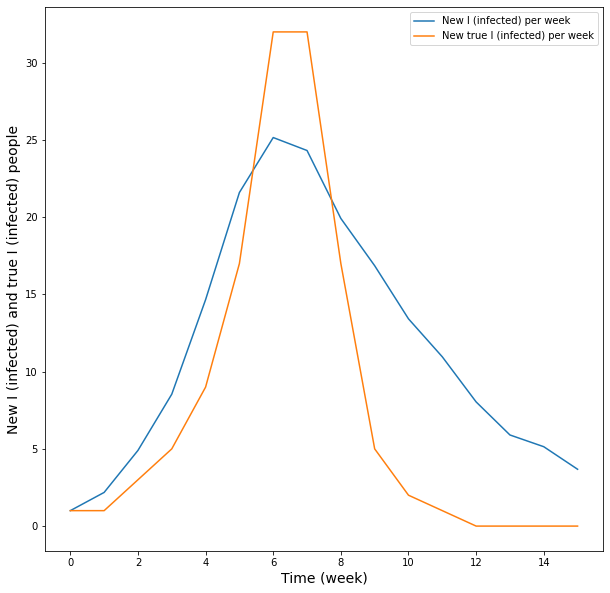

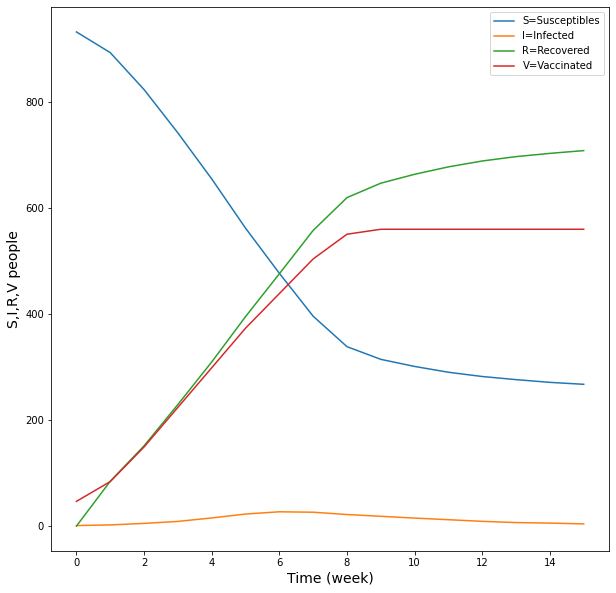

In [ ]:
plot_best_prevision(best_a1, best_a2)

In [ ]:
# another set of parameters
k = 6
beta = 0.2
rho = 1
p = 0.005

In [ ]:
min_rmse, best_a1, best_a2 = sw_best_rmse_for_plotting(k, beta, rho, p)
min_rmse, best_a1, best_a2

(8.065048873586157,
 array([[933.  , 893.6 , 823.56, 738.  , 644.44, 543.14, 450.62, 364.66,
         303.86, 278.52, 265.4 , 256.84, 250.58, 245.56, 241.64, 238.7 ],
        [  1.  ,   2.48,   5.32,  12.2 ,  21.52,  31.46,  34.92,  32.2 ,
          25.56,  19.12,  13.12,   8.56,   6.26,   5.02,   3.92,   2.94],
        [  0.  ,  37.92, 105.12, 183.8 , 268.04, 359.4 , 448.46, 537.14,
         604.58, 636.36, 655.48, 668.6 , 677.16, 683.42, 688.44, 692.36]]),
 array([ 1.  ,  2.48,  5.32, 12.2 , 21.52, 31.46, 34.92, 32.2 , 25.56,
        19.12, 13.12,  8.56,  6.26,  5.02,  3.92,  2.94]))

In [ ]:
for i in range(1,len(best_a1[2])):
  best_a1[2][i] = best_a1[2][i]+cum_vacc_per_week[0]

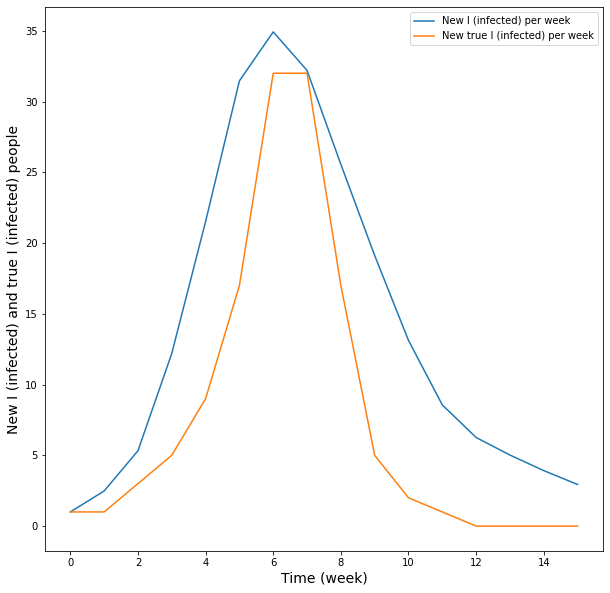

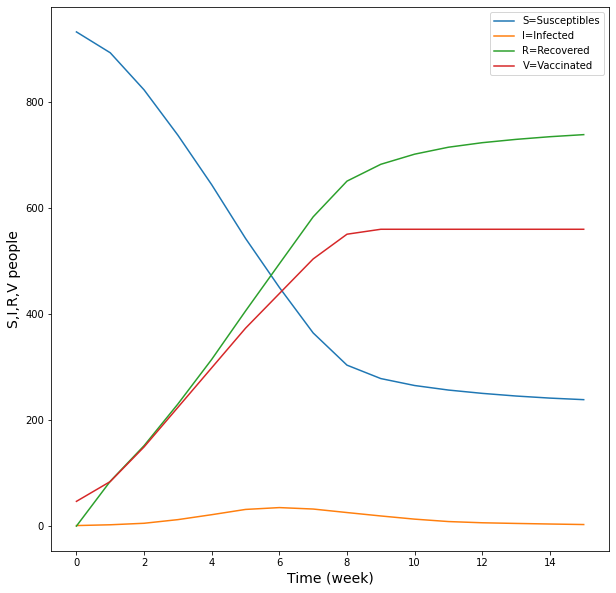

In [ ]:
plot_best_prevision(best_a1, best_a2)

## Exercise 2A

First of all let's define the line graph with 10 nodes

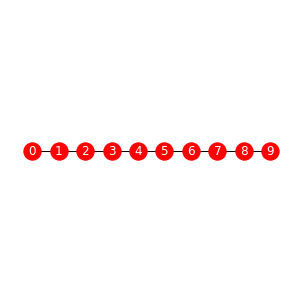

In [ ]:
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# Construct the undirected graph as shown in the picture
G = nx.Graph()
G.add_nodes_from(range(10))
G.add_edges_from([
    (0,1),(1,2),
    (2,3),(3,4),
    (4,5),(5,6),
    (6,7),(7,8), (8,9)
])

plt.figure(figsize=(4,4))
pos = {0: (0, 0), 1: (1, 0), 2: (2, 0), 3: (3, 0), 4: (4, 0),
       5: (5,0), 6: (6,0), 7: (7,0), 8: (8,0), 9: (9, 0)}
nx.draw(G, pos = pos, with_labels=True, node_color = 'r', font_color='w')

In [ ]:
phi = np.array([[1,0], # cost function
                [0,1]])

actions = [0,1] # possible actions of the players: red, green
n_actions = len(actions)
players = list(G.nodes)
n_players = len(G)

n_states = tuple(n_actions for _ in range(len(G)))

In [ ]:
players, n_states

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], (2, 2, 2, 2, 2, 2, 2, 2, 2, 2))

In [ ]:
def utility(player, x, phi):
    """
    compute utilities gained by 'player' for each of its possible actions while the players are in the current configuration x
    - x: vector of players' actions, len(x) = n.of players
    - phi: cost function
    -- result: utility of the player
    """
    result = 0
    for other_player in G.neighbors(player): # for each other player (neighbour)
        result += phi[x[player], x[other_player]] # sum the utility between 'player' and each other player
    return result

In [ ]:
def sim_coloring(n_steps, phi, den_eta):
    """
    Simulation with local clocks method. We simulate the process of coloring, computing, given a state, all the possible variants obtained changing a color without knowing all the possible variant of the graph coloring as it is too computationally expensive
    - n_steps: n.of discrete time instances t
    - phi: cost function
    """

    x0 = np.zeros(n_players, dtype=int)
    n_states = tuple(n_actions for _ in range(len(G))) # length = n_actions
    states = np.zeros(n_steps, dtype=int) # chosen configuration for each step among all the possibilities (n_config)
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states) # at initialization, each node is red

    for t in range(0,n_steps):
        eta = t/den_eta # increasing in time, so the noise factor (the inverse) is decreasing

        # current configuration
        x = np.unravel_index(states[t-1], shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations:
        # admissible destinations differ from the current configuration for the state of a single agent
        destinations = list()
        utilities = list()

        for player in range(n_players):
            # choose an admissible destination: if the color is green, assign red and vice-versa
            y = np.array(x)
            if y[player] == 0:
                y[player] = 1
            elif y[player] == 1:
                y[player] = 0
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id) # update
            # To compute the transition rate from the current state to another possible state we start by computing the utility of the player.
            # If the utility is 0, then the cost is zero, so it will be more likely to choose the destination for the next iteration
            utili = utility(player,y,phi)
            utilities.append(utili)

        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        sum_exp_util = np.sum(exp_util) # summation of the exponential utilities, given all transition rates from x to admissible y
        if sum_exp_util == 0:
            states[t] = states[t-1] # the process stays in x
        else:
            probabilities = exp_util / sum_exp_util # transition probabilities
            states[t] = np.random.choice(destinations, p=probabilities) # next config is chosen accordingly

    return states

In [ ]:
def potentials_over_time(n_steps, states, graph, phi):
    potentials = np.zeros(n_steps)
    times = np.zeros(n_steps)
    for t in np.arange(n_steps): # 0,1,...,29
        x_id = states[t]
        x = np.array(np.unravel_index(x_id, shape = n_states))
        times[t] = t
        for i, j in graph.edges:
            # multiplied by 2 because we consider the edges (i,j) and (j,i) whose potential is the same
            # if potential = 0 >> no conflicting nodes, a solution is found
            potentials[t] += 2*0.5*phi[x[i],x[j]]
    return potentials, times

In [ ]:
# Plot the evolution of the game's configurations
def evolution_colors(n_steps):
    pos = nx.spectral_layout(G)
    fig = plt.figure(figsize=(15,15))
    for t in range(0,n_steps):
        plt.subplot(5,8,t+1)
        x_id = states[t]
        x = np.array(np.unravel_index(x_id, shape=n_states))

        nx.draw_spectral(G,
            node_size=100,
            with_labels=True,
            font_color='w',
            nodelist=np.argwhere(x==0).T[0].tolist(),
            node_color = 'r')
        nx.draw_spectral(G,
            node_size=100,
            with_labels=True,
            font_color='w',
            nodelist=np.argwhere(x==1).T[0].tolist(),
            node_color = 'g')
        plt.title('jump step = {0}'.format(t+1))

$η=t/100$

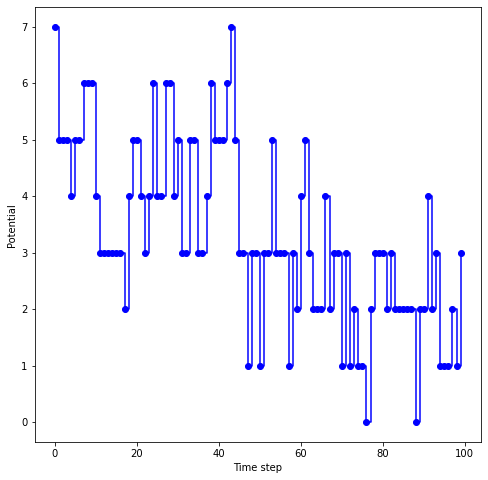

In [ ]:
states = sim_coloring(n_steps=100, phi=phi, den_eta=100)
potentials, times = potentials_over_time(n_steps=100, states=states, graph=G, phi=phi)
fig,ax = plt.subplots(figsize=(8,8))
ax.set_xlabel('Time step', fontsize=10)
ax.set_ylabel('Potential',fontsize=10)
plt.step(times, potentials, 'bo-', where="post");

$η=t/10$

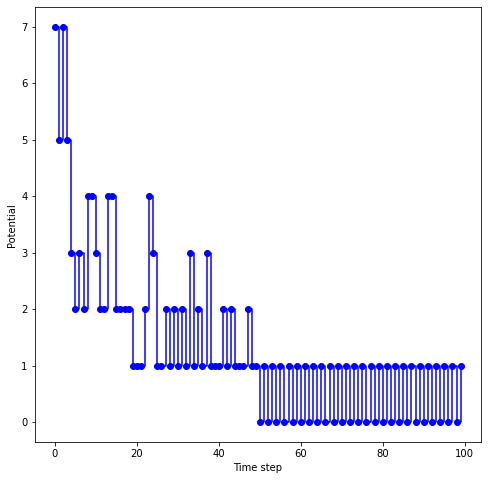

In [ ]:
states = sim_coloring(n_steps=100, phi=phi, den_eta=10)

potentials, times = potentials_over_time(n_steps=100, states=states, graph=G, phi=phi)
fig,ax = plt.subplots(figsize=(8,8))
ax.set_xlabel('Time step', fontsize=10)
ax.set_ylabel('Potential',fontsize=10)
plt.step(times, potentials, 'bo-', where="post");

$η=t/2$

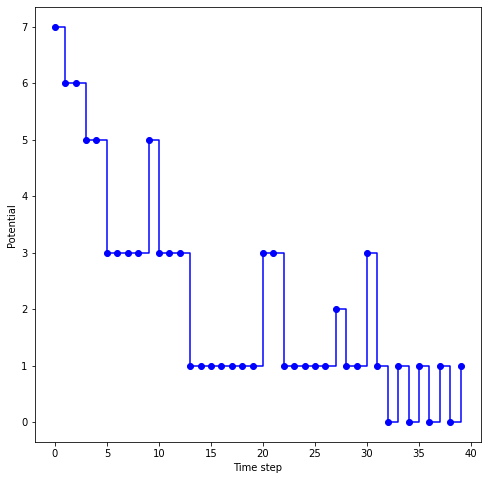

In [ ]:
states = sim_coloring(n_steps=40, phi=phi, den_eta=10)

potentials, times = potentials_over_time(n_steps=40, states=states, graph=G, phi=phi)
fig,ax = plt.subplots(figsize=(8,8))
ax.set_xlabel('Time step', fontsize=10)
ax.set_ylabel('Potential',fontsize=10)
plt.step(times, potentials, 'bo-', where="post");

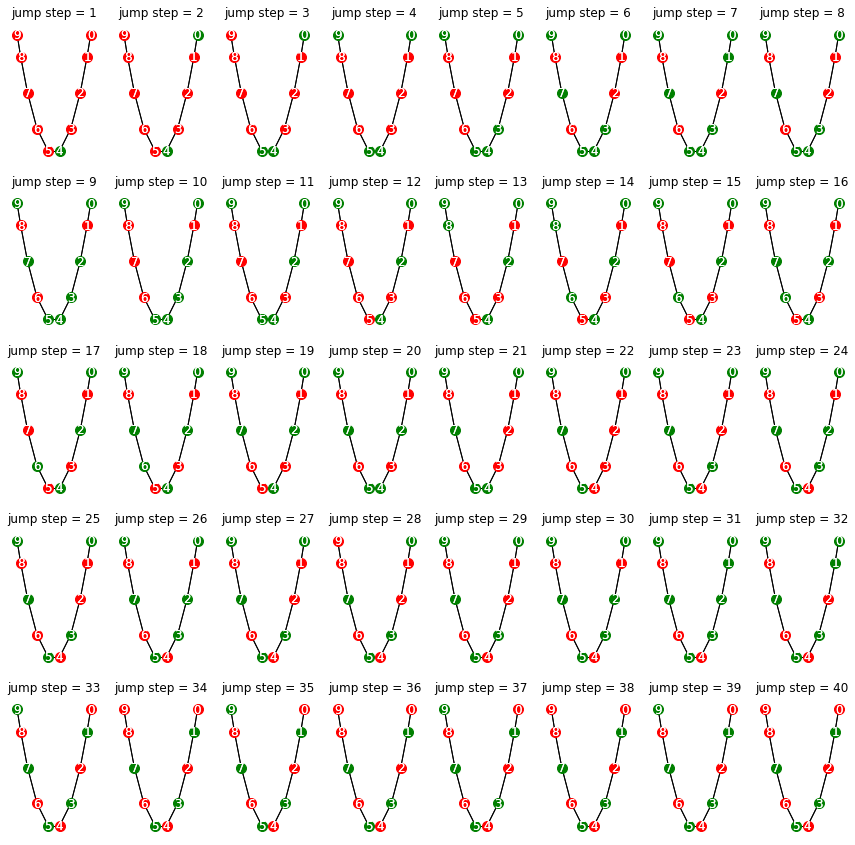

In [ ]:
evolution_colors(n_steps=40)

## Exercise 2B

In [ ]:
import numpy as np
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
import math
B = np.loadtxt('wifi.mat') 
Coord = np.loadtxt('coords.mat')
print(B.shape)

(100, 100)


In [ ]:
G = nx.Graph()
#we add an edge between i-th and j-th nodes everytime
#there is a one in the adjency matrix in the column i-th and row j-th
for j in range(B.shape[1]):
  for i in range(B.shape[0]):
    if B[i][j] == 1: 
      u = i
      v = j
      G.add_edge(u, v) 
cont = 0 
for v in range(100):
    if cont not in G.nodes:
        G.add_node(cont)
    cont += 1
print(G.nodes)

[20, 0, 55, 69, 91, 8, 1, 13, 29, 56, 58, 93, 7, 2, 45, 46, 64, 79, 38, 3, 67, 22, 4, 72, 10, 5, 11, 19, 60, 6, 88, 40, 9, 63, 57, 12, 70, 80, 83, 95, 21, 14, 90, 84, 15, 16, 42, 92, 18, 39, 50, 98, 24, 23, 74, 87, 97, 62, 27, 25, 33, 48, 26, 49, 68, 28, 30, 36, 31, 53, 32, 54, 81, 52, 34, 78, 89, 37, 35, 75, 47, 41, 85, 43, 77, 44, 94, 96, 66, 76, 73, 86, 65, 61, 17, 51, 59, 71, 82, 99]


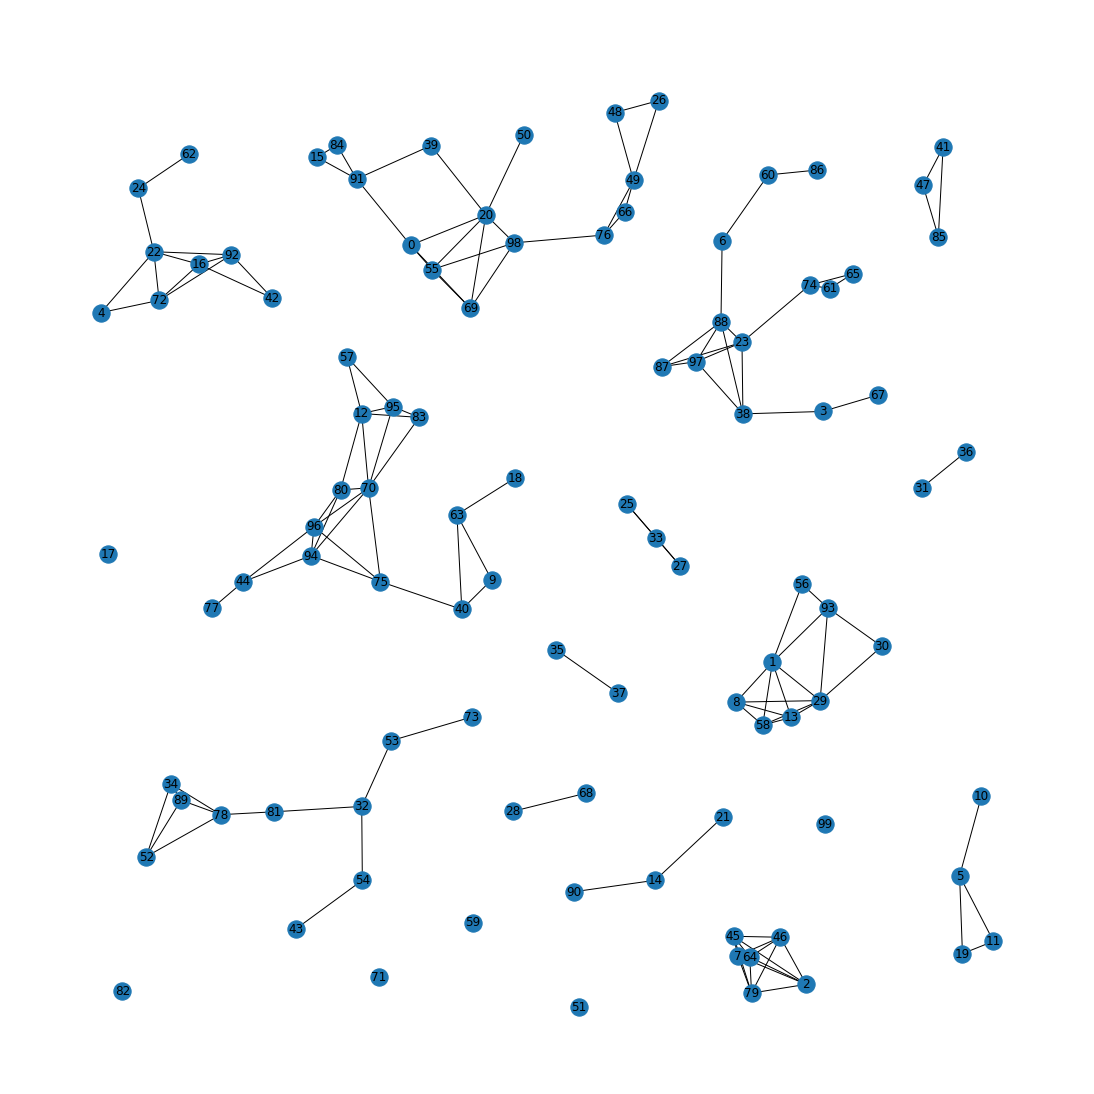

In [ ]:
plt.figure(figsize=(15,15))
pos = Coord 
nx.draw(G, pos = pos, with_labels=True)

/tmp/ipykernel_1963/589340915.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(3,3))


<Figure size 1080x1080 with 0 Axes>

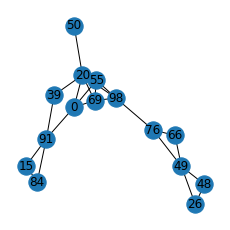

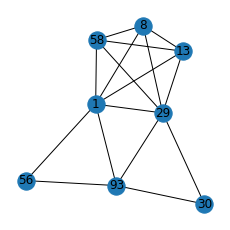

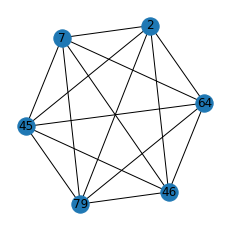

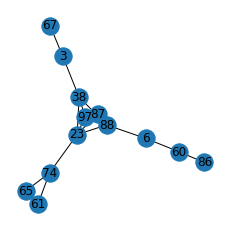

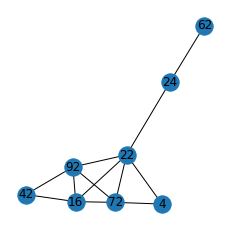

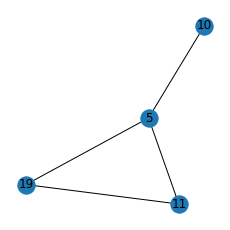

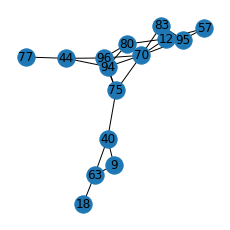

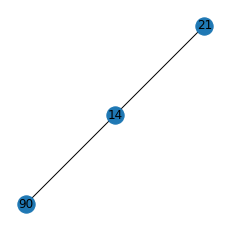

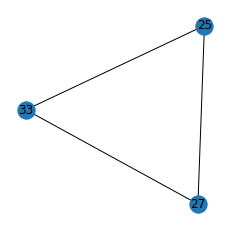

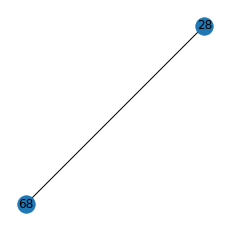

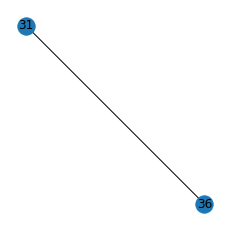

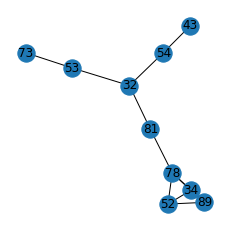

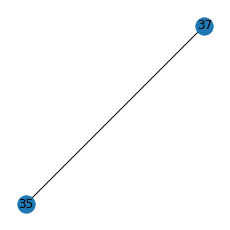

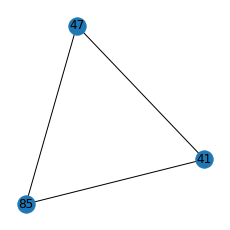

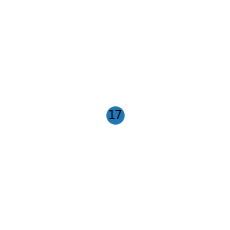

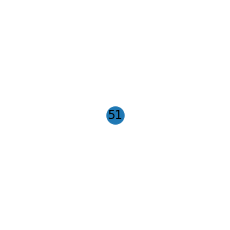

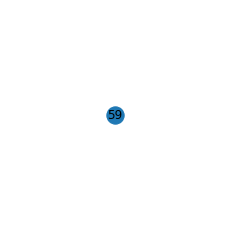

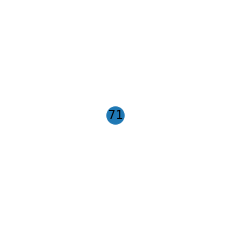

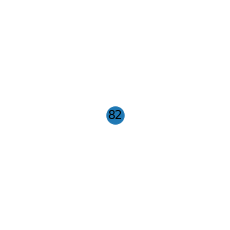

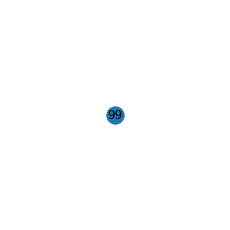

In [ ]:
#In order to plot in a more precise way we split G in the isolted components of it
#and save all graphs in dict
Cc = nx.connected_components(G)
plt.figure(figsize=(15,15))
pos = Coord
#nx.draw(CG, with_labels=True)
graphs = [c for c in nx.connected_components(G)]
dict = {}
for i, graph in enumerate(graphs):
    g = nx.Graph()
    for v in graph:
        for v1 in G.neighbors(v):
            g.add_edge(v, v1)
    if len(g.nodes) == 0:
        g.add_node(v)
    dict[i] = g
    plt.figure(figsize=(3,3))
    nx.draw(dict[i], with_labels=True)

In [ ]:
graphs = [len(c) for c in nx.connected_components(G)]
graphs

[15, 8, 6, 13, 8, 4, 15, 3, 3, 2, 2, 10, 2, 3, 1, 1, 1, 1, 1, 1]

In [ ]:

phi = np.array([[2,1,0,0,0,0,0,0],
                [1,2,1,0,0,0,0,0],
                [0,1,2,1,0,0,0,0],
                [0,0,1,2,1,0,0,0],
                [0,0,0,1,2,1,0,0],
                [0,0,0,0,1,2,1,0],
                [0,0,0,0,0,1,2,1],
                [0,0,0,0,0,0,1,2]])


actions = [0,1,2,3,4,5,6,7]
n_actions = len(actions)
def utility_pos(pos_player, x, phi):
    result = 0
    # result is the utility of the player
    # for each other player, sum the utility of the 2x2 game between player and other player
    if len(list(g.neighbors(players[pos_player]))) != 0:
        for other_player in g.neighbors(players[pos_player]):
            result += phi[x[pos_player], x[players.index(other_player)]]
    else:
        result += 0
    return result

$\eta = t/100, n\_steps = 100$

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []



#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 100
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = t/100
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

In [ ]:
#PLOT G AND IT'S POTENTIAL OVER TIME
def getValueAndPlots(states_graphs,n_steps,eta):
 potentials = np.zeros(n_steps)
 times = np.zeros(n_steps)

#We sum for each time t the potentials of all the isolated graphs
 for i in range(20):
    
    g = dict[i]
    states = states_graphs[i]
    n_states = tuple(n_actions for _ in range(len(g.nodes)))
    players = list(g.nodes)
    for t in range(n_steps):
        x_id = states[t]
        x = np.array(np.unravel_index(x_id, shape = n_states))
        times[t] = t
        for i, j in g.edges:
            if len(x) == 1:
                potentials[t] += 0
            else:
                potentials[t] += phi[x[players.index(i)], x[players.index(j)]] 

 fig,ax = plt.subplots(figsize=(10,10))
 ax.set_xlabel('Time step', fontsize=10)
 ax.set_ylabel('Potential',fontsize=10)
 plt.step(times, potentials, 'bo-', where="post");
 time_minimum = np.where(potentials == np.amin(potentials))[0][0] 
 print('The minimum value of the potential is obtained the first time at time', time_minimum, 'with value ', np.amin(potentials))


#here we create two list:
#final_x: contains the state of G in the instant the minimum was reached
#final_players: contains the order of the players. This will be useful to plot G.
#Infact, the nodes order of G are different then in final_x

 final_x = []
 final_players = []
 for i in range(20):
    g = dict[i]
    states = states_graphs[i]
    n_states = tuple(n_actions for _ in range(len(g.nodes)))
    players = list(g.nodes)
    final_players.append(players)
    #from a list of list to a list of all the elments
    flat_players = [item for sublist in final_players for item in sublist]
    x_id = states[time_minimum]
    x = np.array(np.unravel_index(x_id, shape = n_states))
    final_x.append(list(x))
    #from a list of list to a list of all the elments
    flat_list_color = [item for sublist in final_x for item in sublist]

#here we just order the states of flat_list_color accordinf to the plot order of the nodes
 list_order_graph = list(G.nodes)
 player_order = []
 for p in flat_players:
    player_order.append([p, list_order_graph.index(p)])
    
 final = []
 for player, color in zip(flat_players,flat_list_color):
    for player2, order in player_order:
        if player == player2:
           final.append([order, color])
 final = [x for _,x in sorted(final)]

 fig = plt.figure(figsize=(15,15))
 color_map = []

 for e in final:
    if e == 0:
        color_map.append('red')
    if e == 1:
        color_map.append('green')
    if e == 2:
        color_map.append('blue')
    if e == 3:
        color_map.append('y')
    if e == 4:
        color_map.append('m')
    if e == 5:
        color_map.append('c')
    if e == 6:
        color_map.append('white')
    if e == 7:
        color_map.append('black')

        
 nx.draw(G, pos = pos, node_color=color_map, with_labels=True)


 

The minimum value of the potential is obtained the first time at time 96 with value  25.0


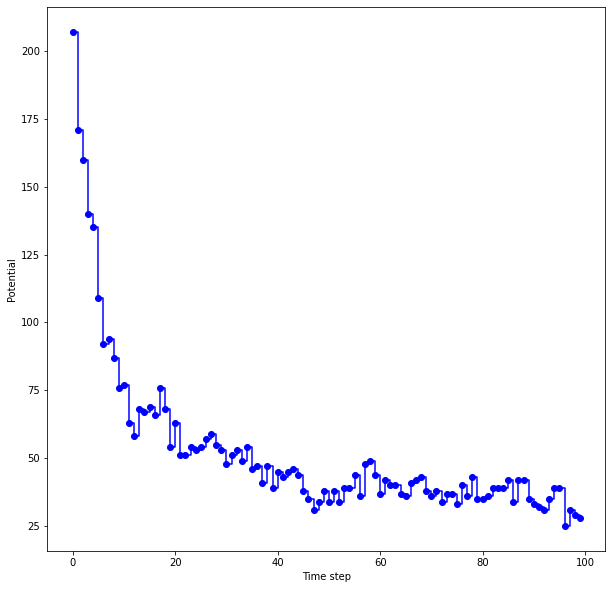

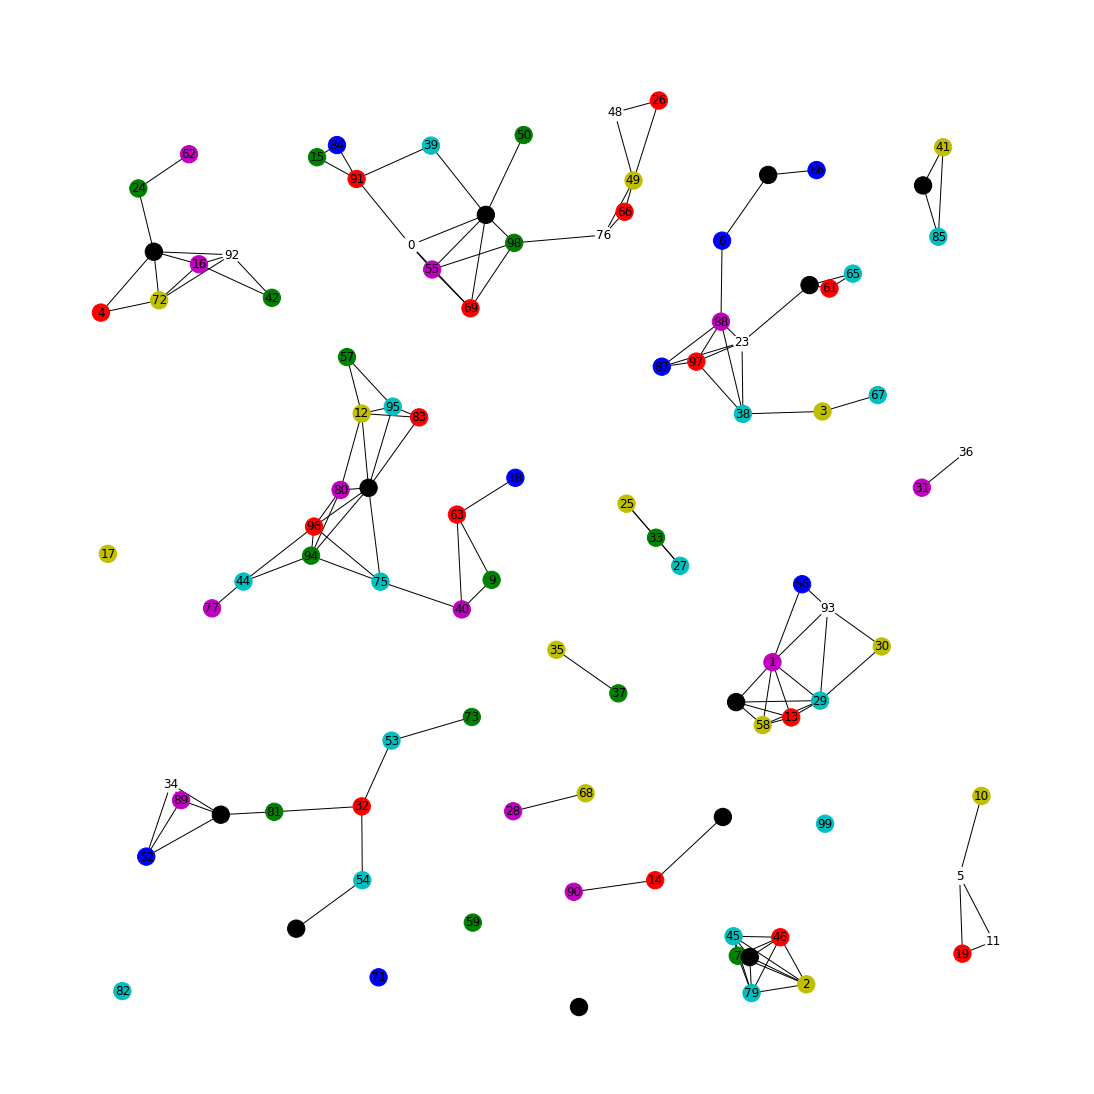

In [ ]:
getValueAndPlots(states_graphs,100,t/100)

$\eta= t/100, n\_steps=250$

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []



#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 250
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = t/100
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 247 with value  9.0


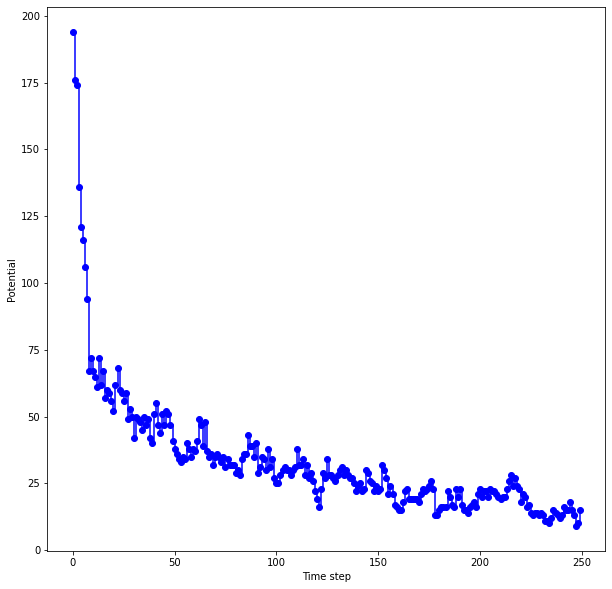

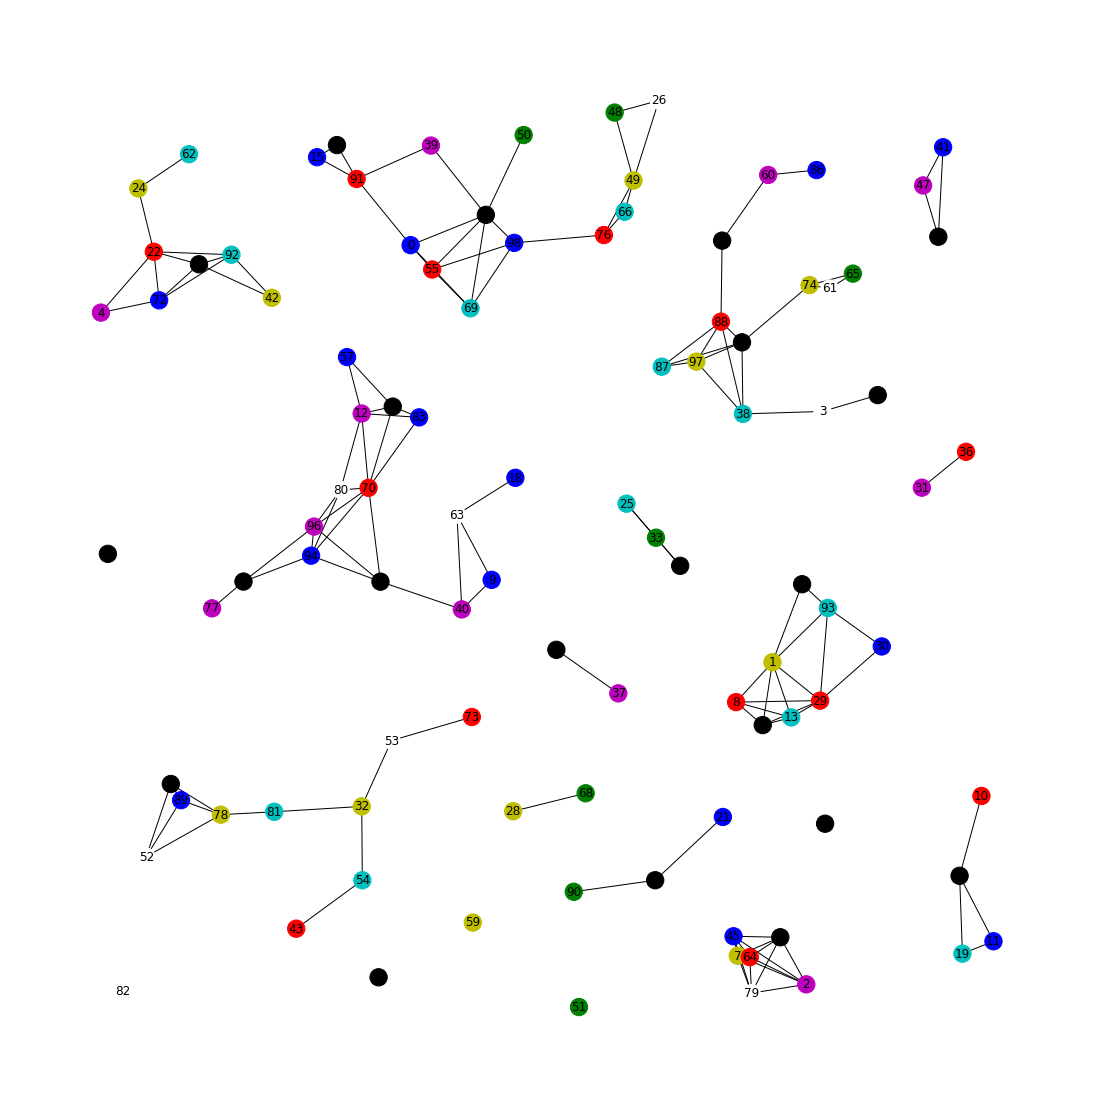

In [ ]:
getValueAndPlots(states_graphs,250,t/100)

eta= t/100 n_steps=500

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []



#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 500
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = t/100
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 295 with value  6.0


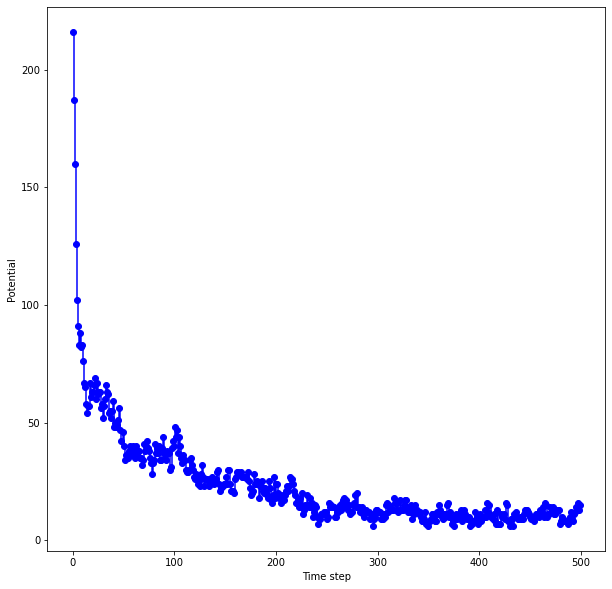

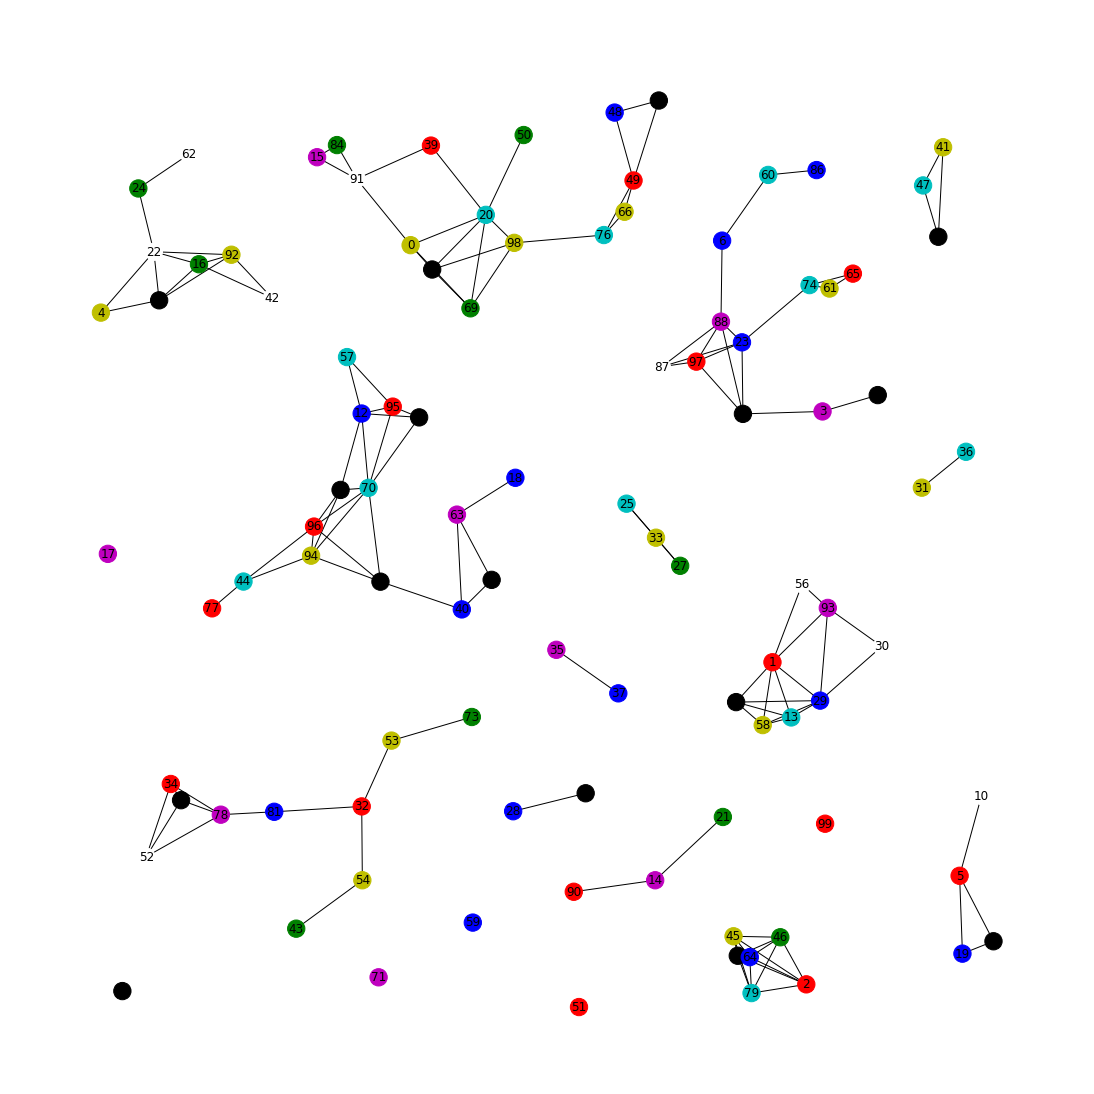

In [ ]:
getValueAndPlots(states_graphs,500,t/100)

best: eta=t/100 n_steps=1000 

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []



#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 1000
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = t/100
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 997 with value  4.0


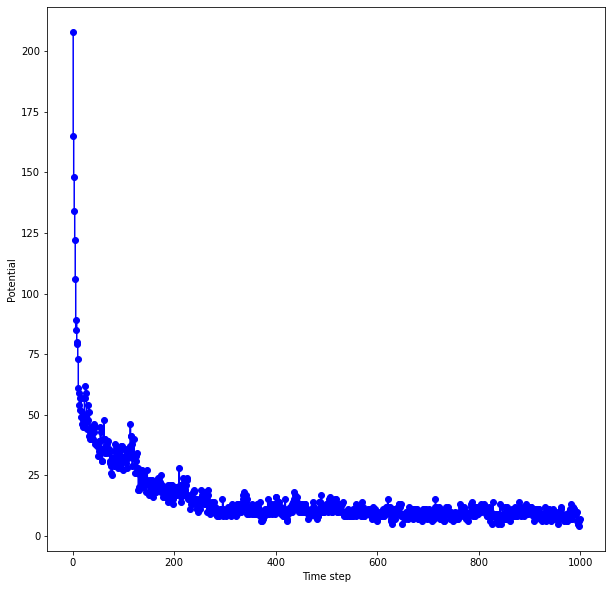

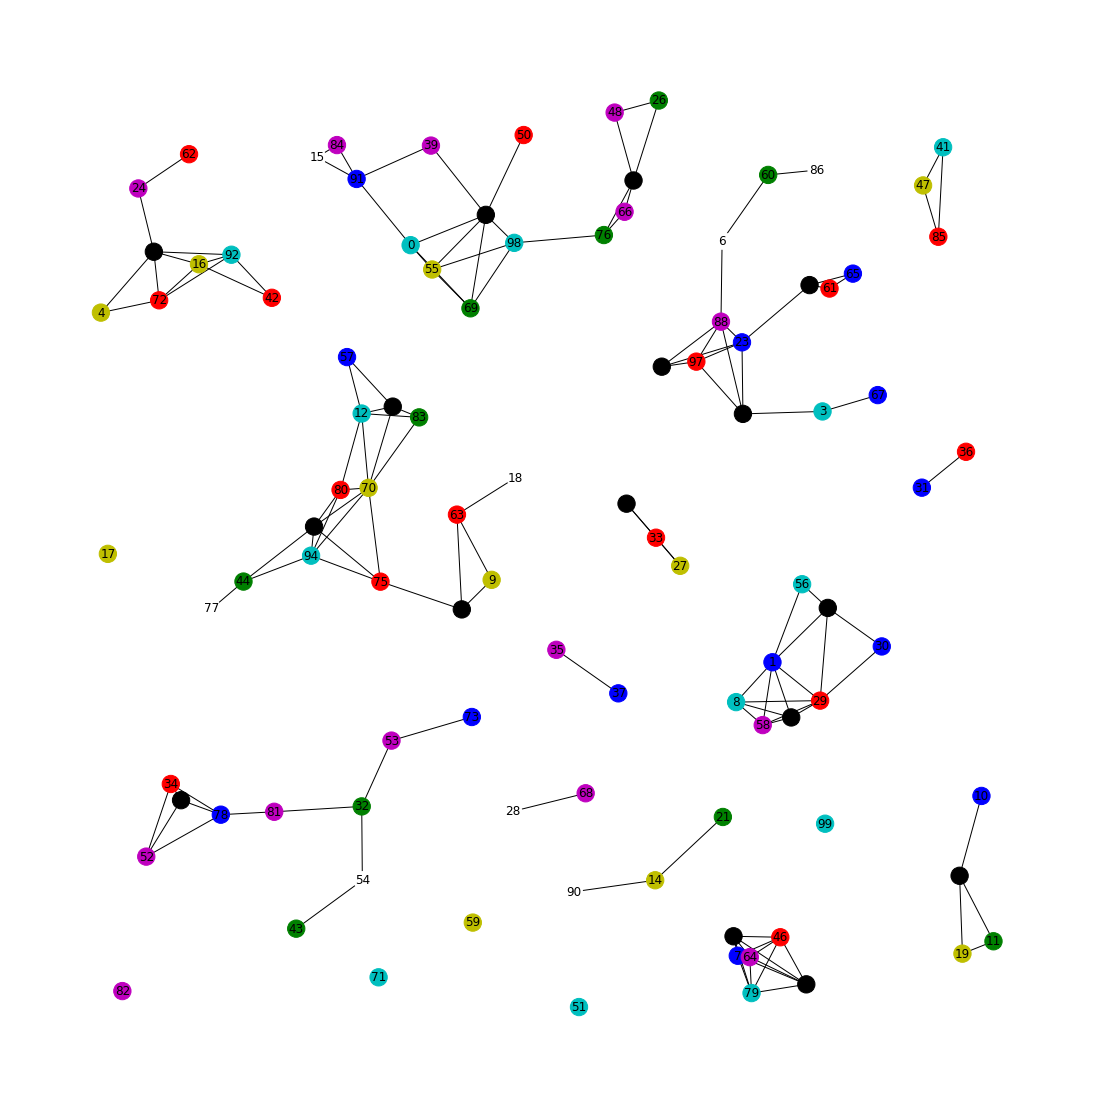

In [ ]:
getValueAndPlots(states_graphs,1000,t/100)

Exercise 2 point C

n_steps=30
eta = 10000

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 30
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 10000
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 24 with value  24.0


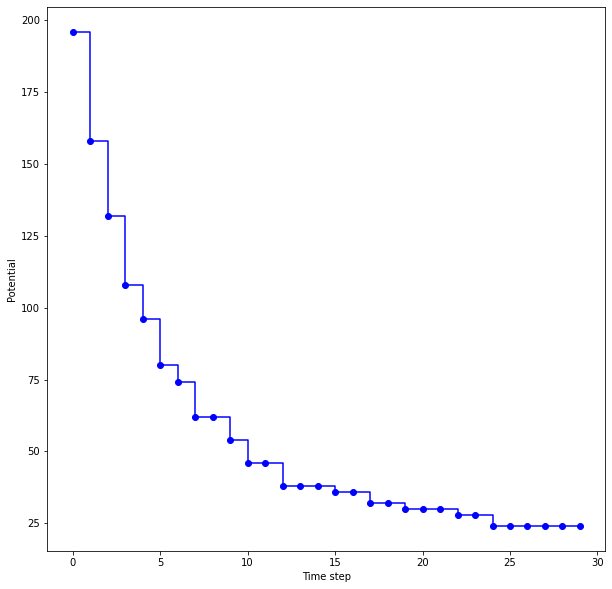

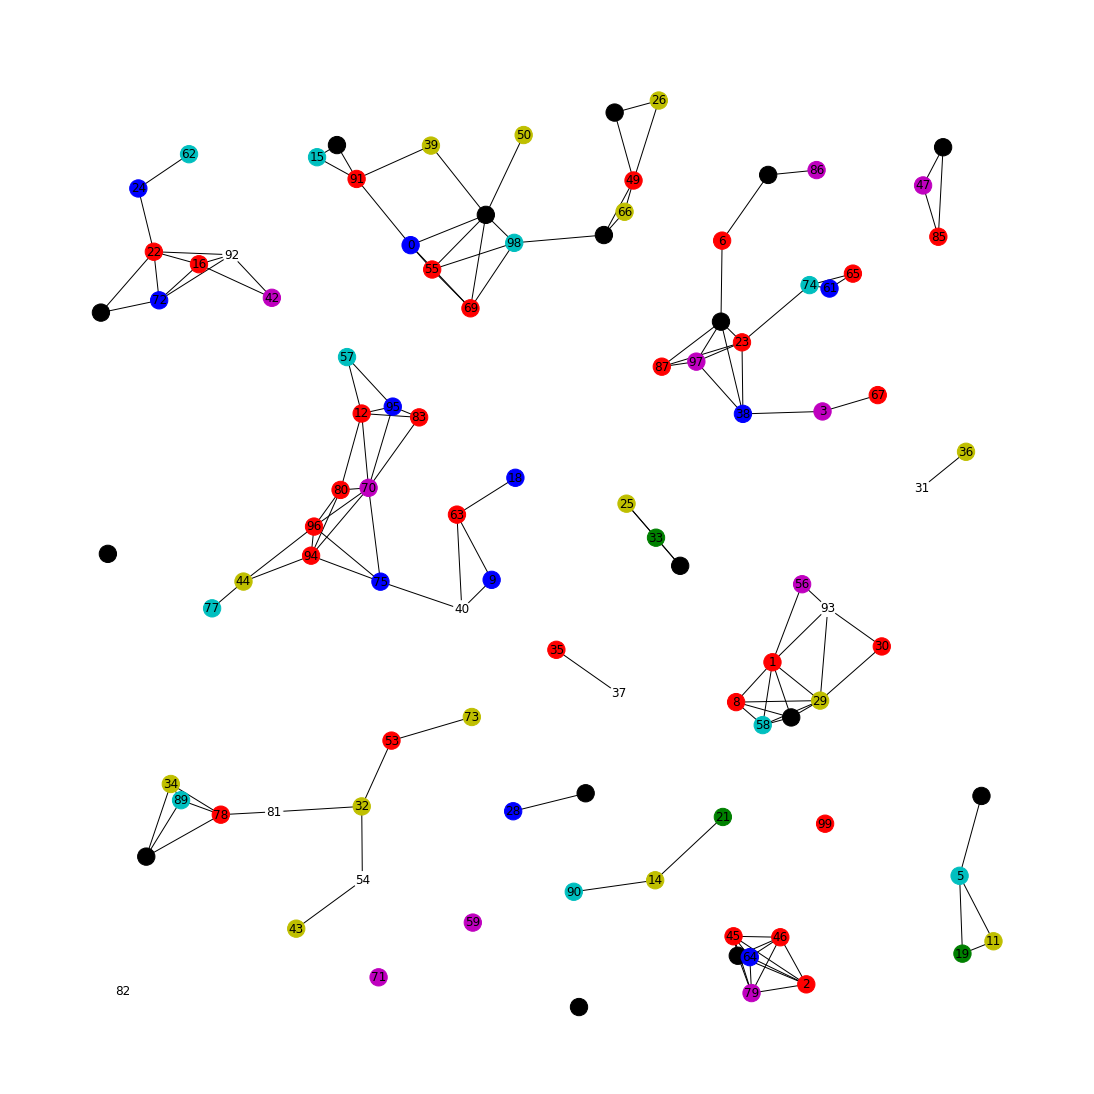

In [ ]:
getValueAndPlots(states_graphs,30,10000)

In [ ]:
n_steps=50
eta = 10000

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 50
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 10000
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 37 with value  16.0


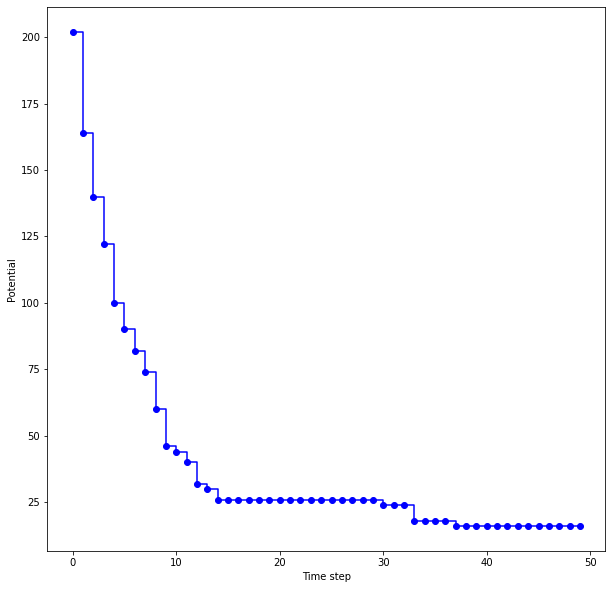

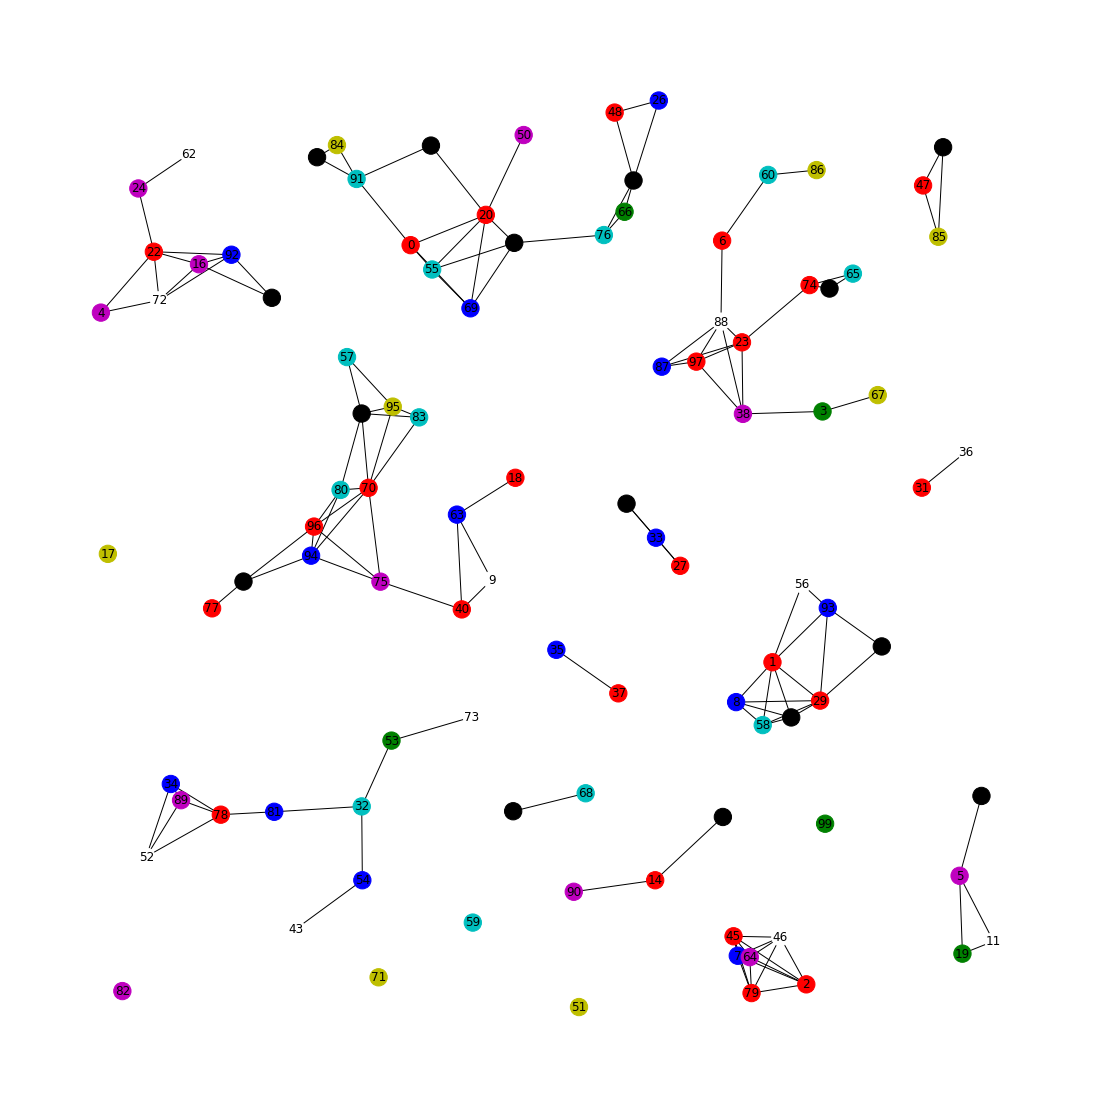

In [ ]:
getValueAndPlots(states_graphs,50,10000)

n_steps=100
eta = 10000

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 100
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 10000
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 44 with value  10.0


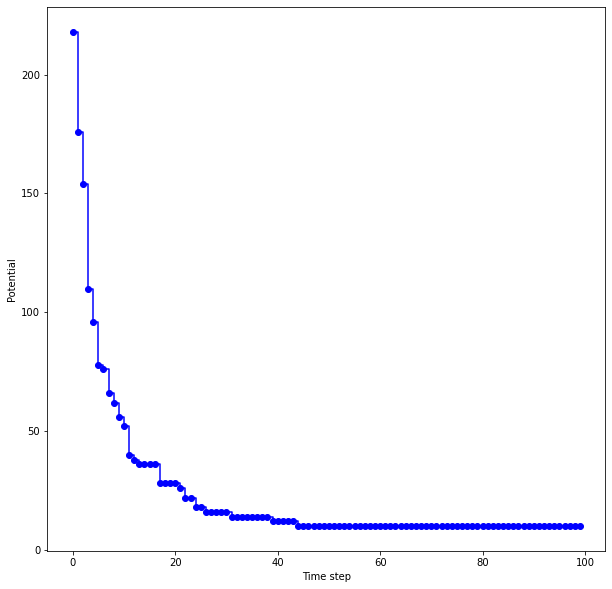

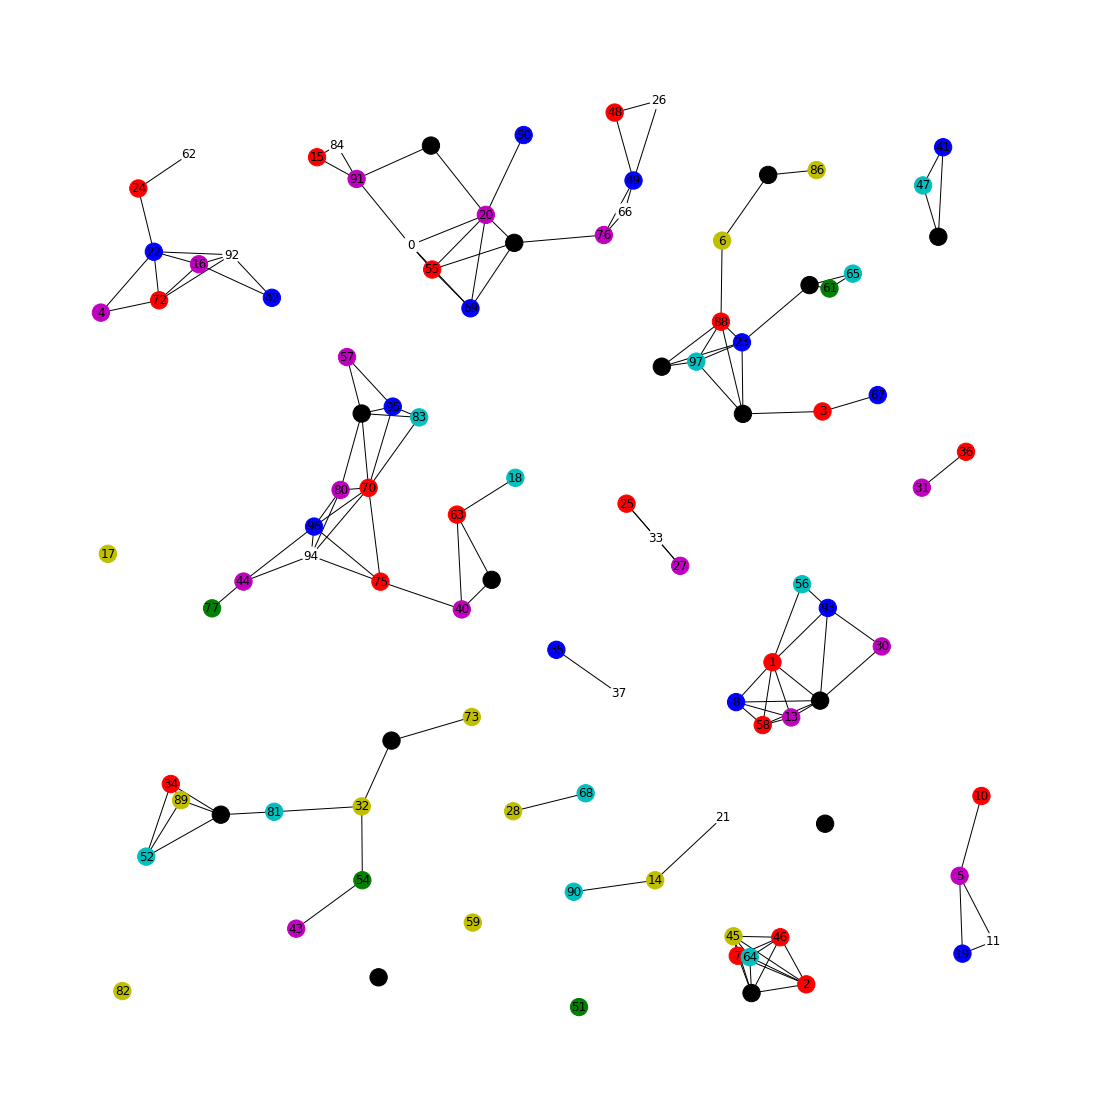

In [ ]:
getValueAndPlots(states_graphs,100,10000)

In [ ]:
n_steps=250
eta = 10000

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 250
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 10000
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 70 with value  8.0


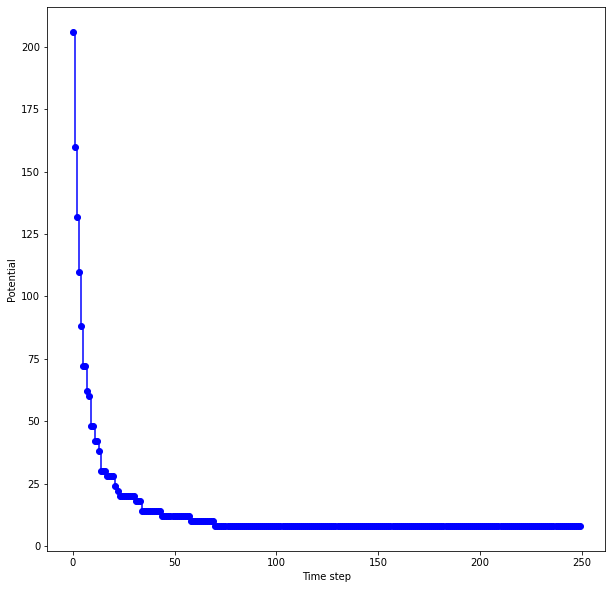

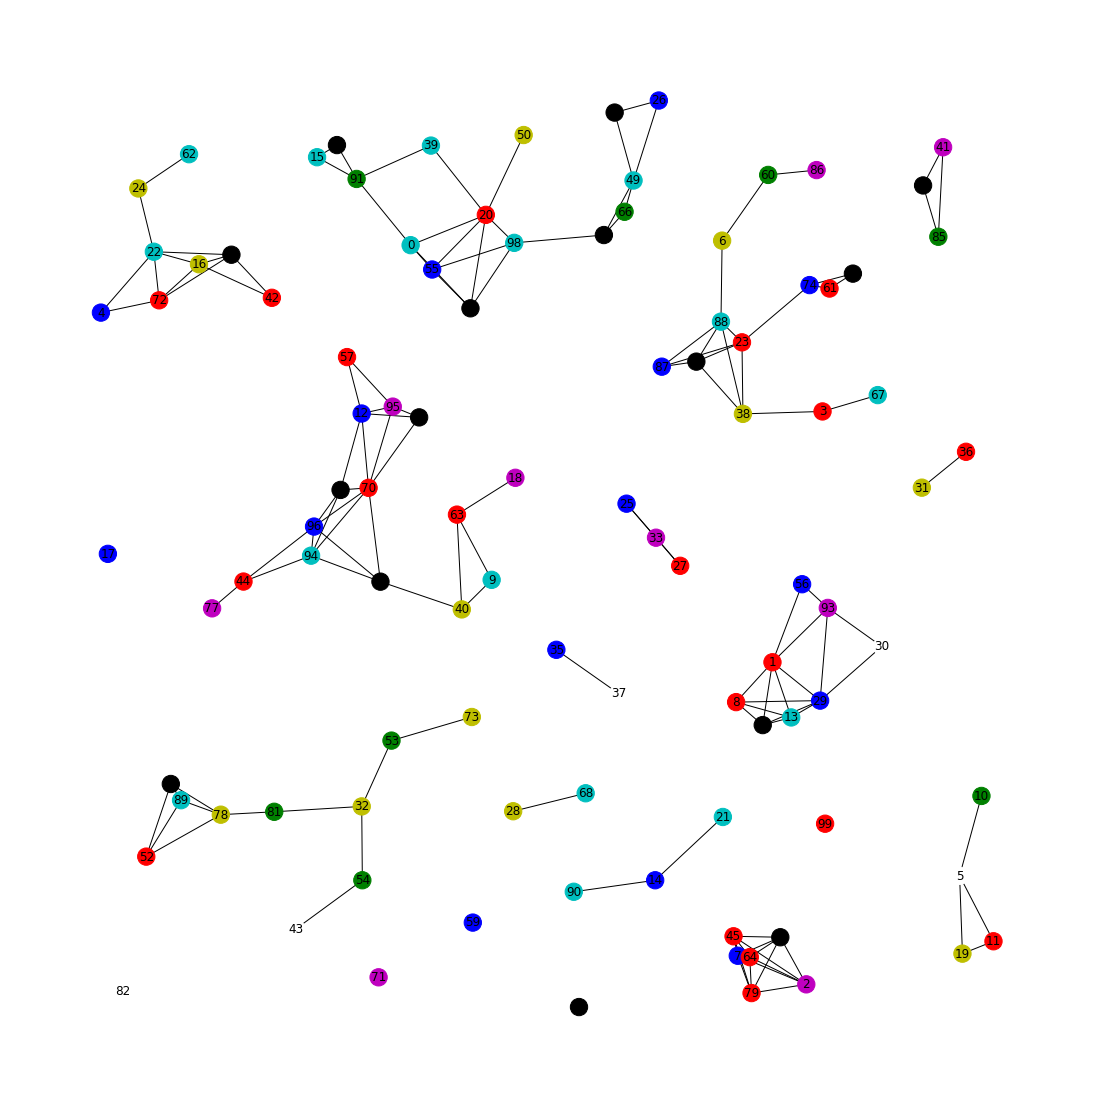

In [ ]:
getValueAndPlots(states_graphs,250,10000)

n_steps=500
eta = 10000

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 500
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 10000
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 103 with value  10.0


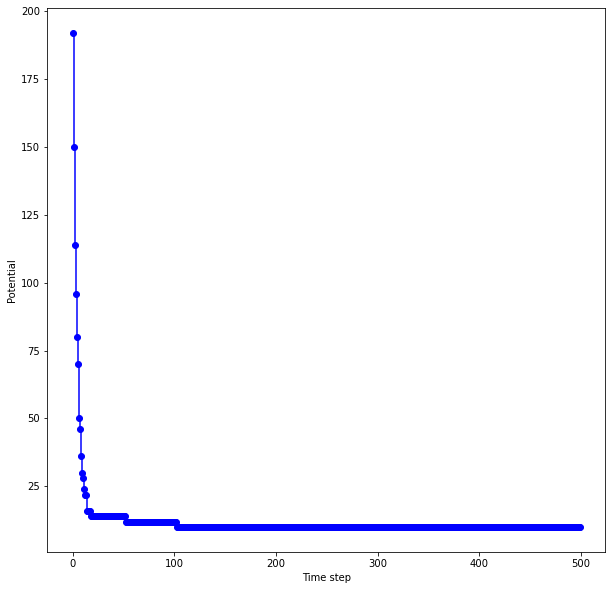

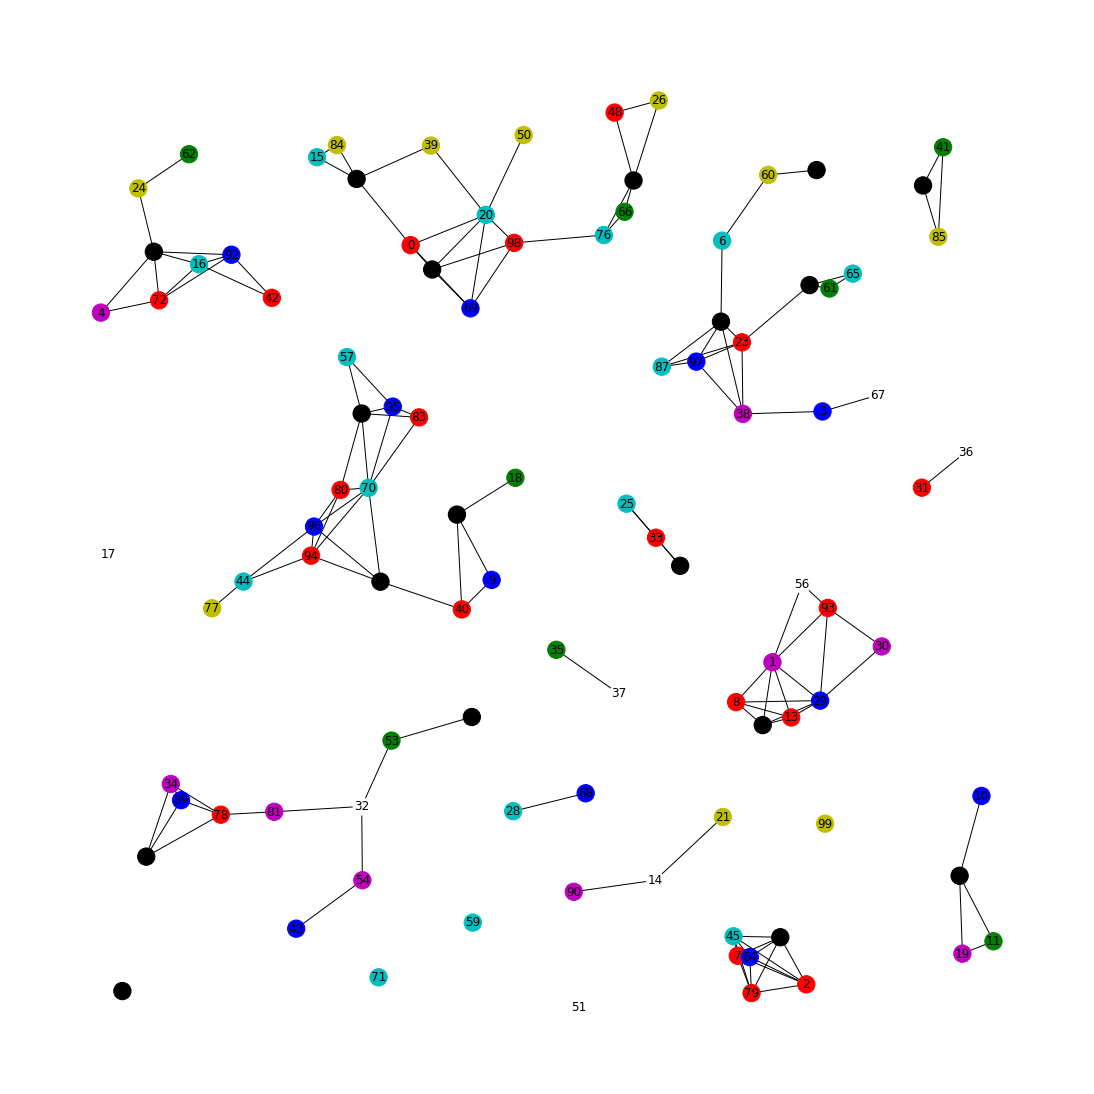

In [ ]:
getValueAndPlots(states_graphs,500,10000)

n_steps = 30
eta = 1000

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 30
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 1000
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 17 with value  28.0


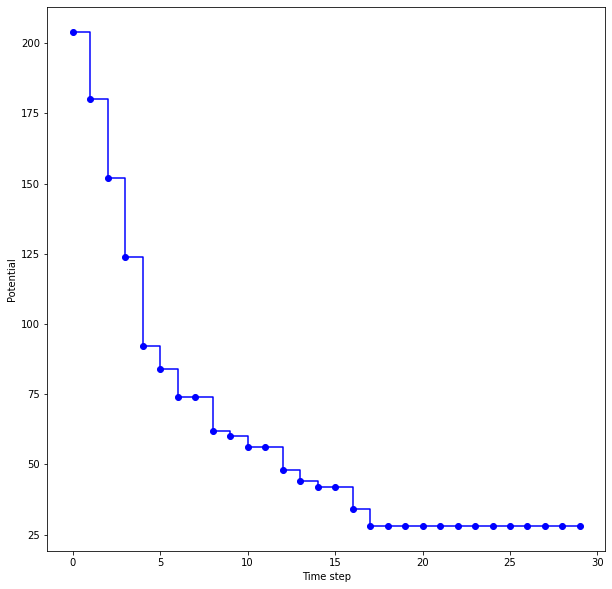

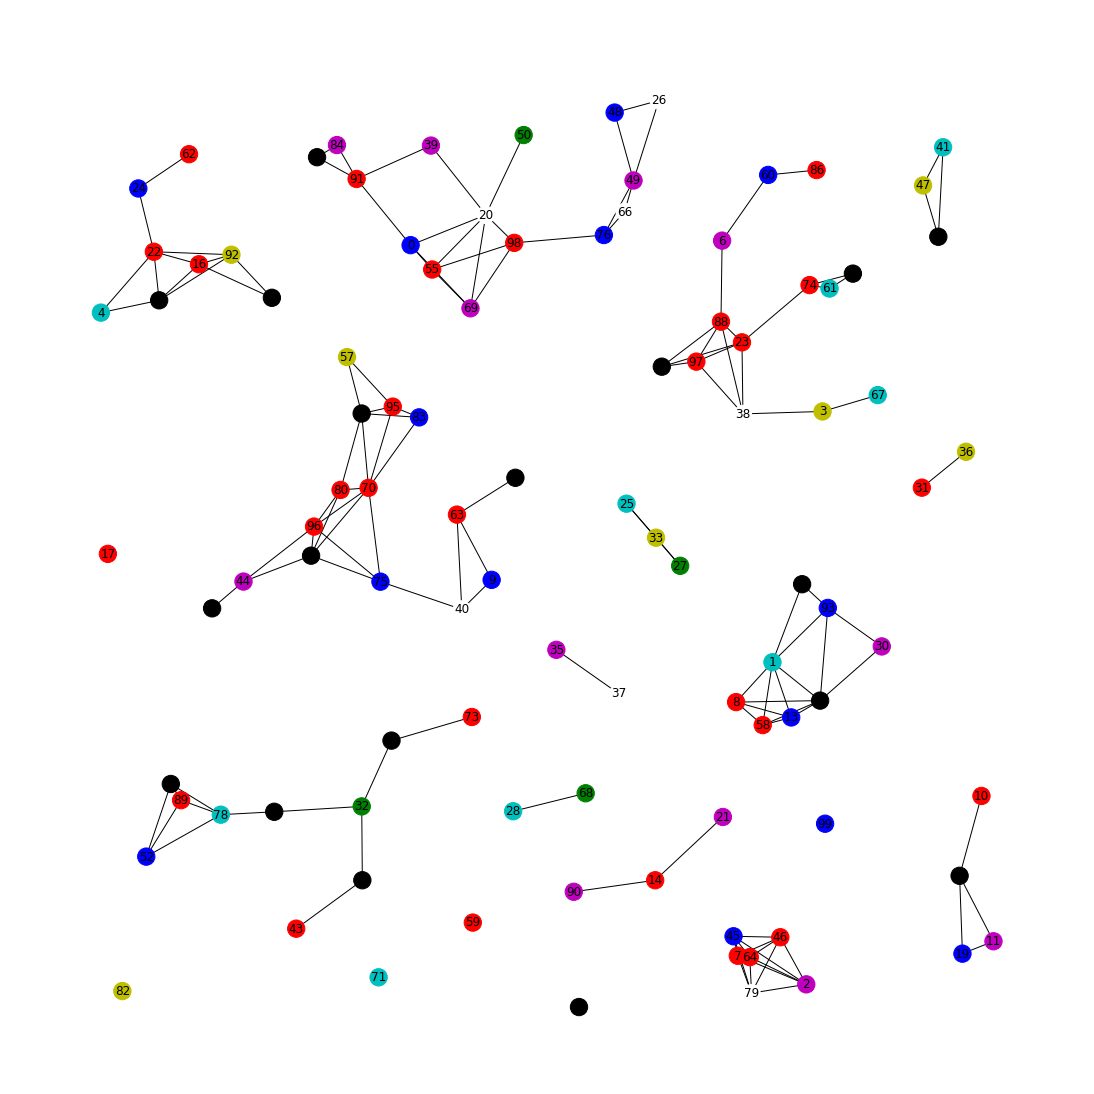

In [ ]:
getValueAndPlots(states_graphs,30,1000)

n_steps = 50
eta = 1000

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 50
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 1000
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 36 with value  18.0


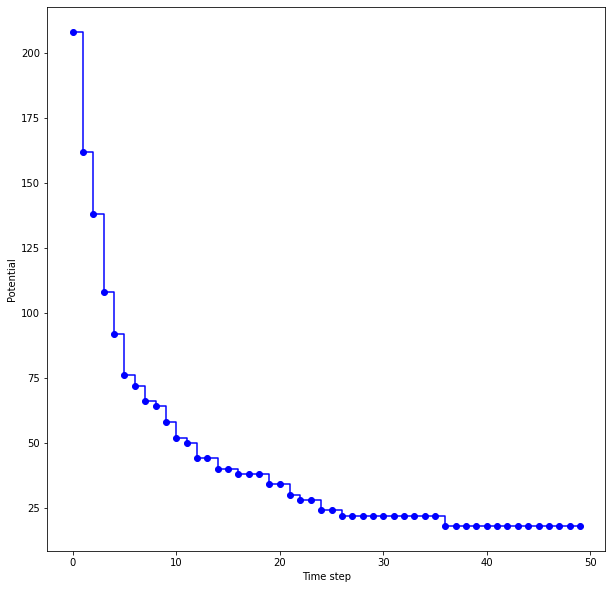

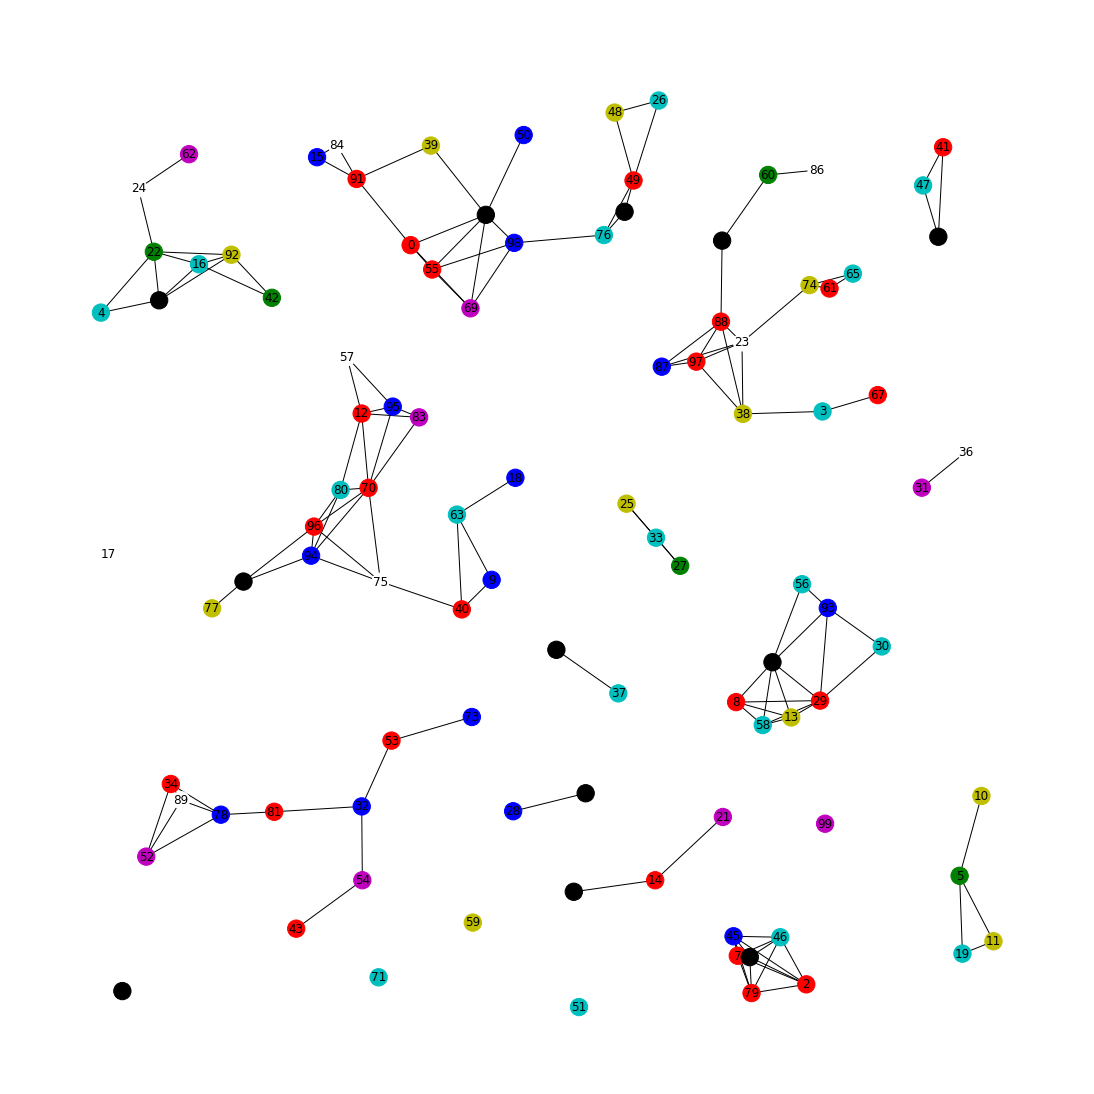

In [ ]:
getValueAndPlots(states_graphs,50,1000)

n_steps = 100
eta = 1000

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 100
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 1000
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 45 with value  8.0


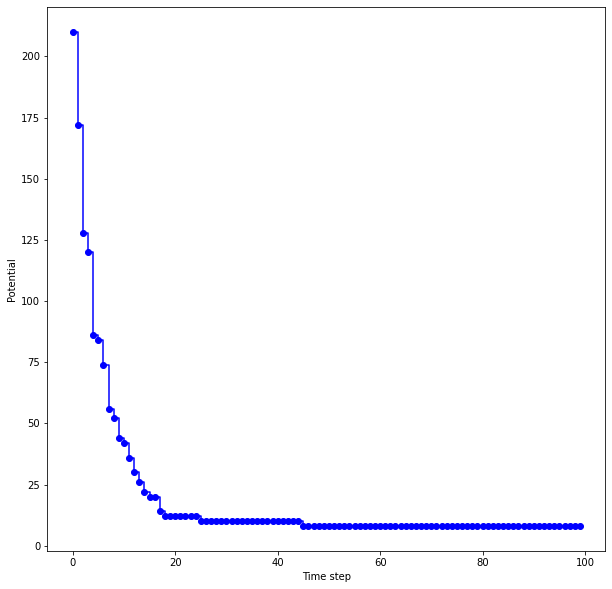

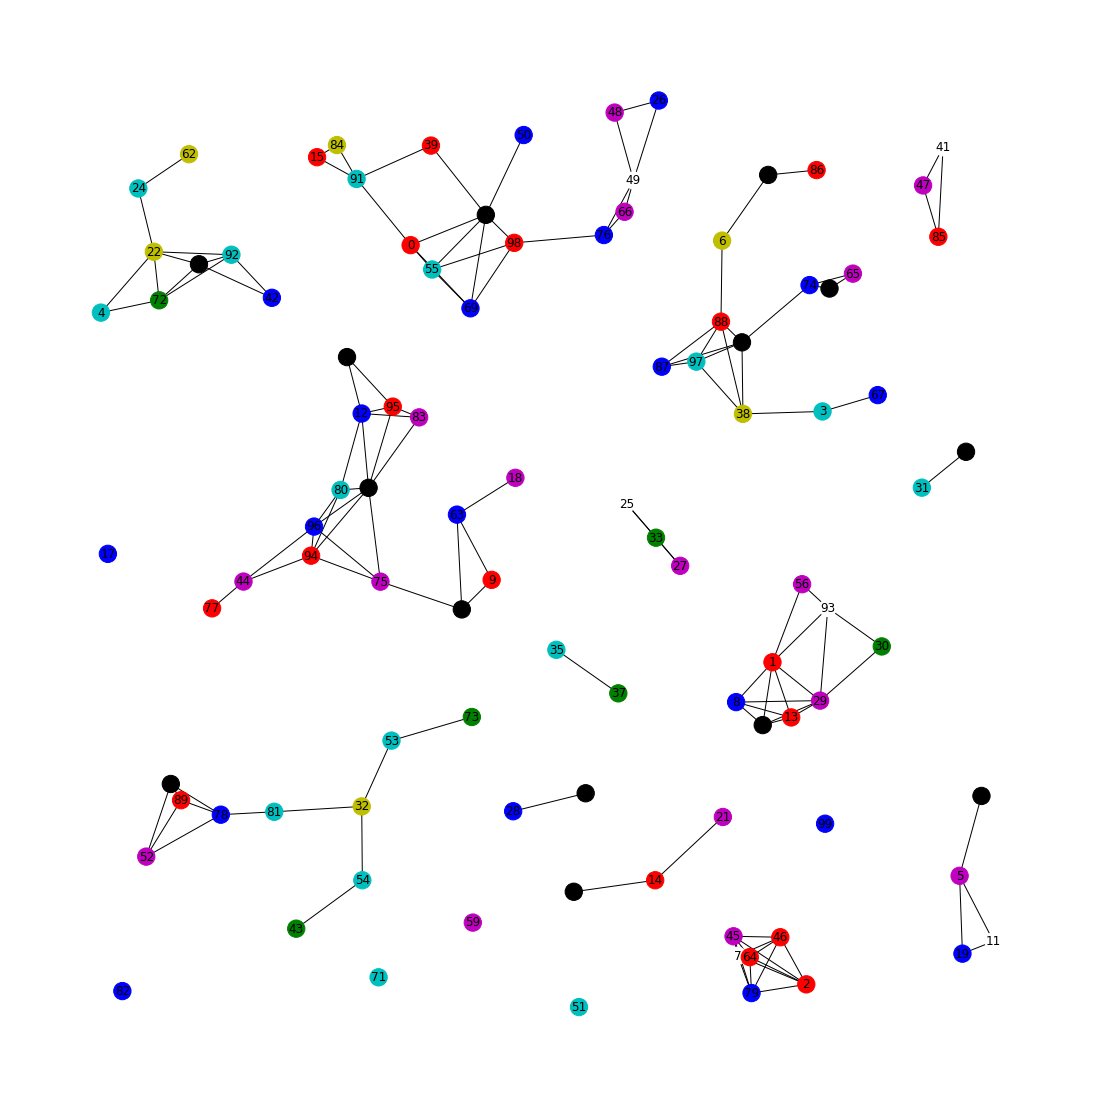

In [ ]:
getValueAndPlots(states_graphs,100,1000)

n_steps = 250
eta = 1000

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 250
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 1000
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 133 with value  8.0


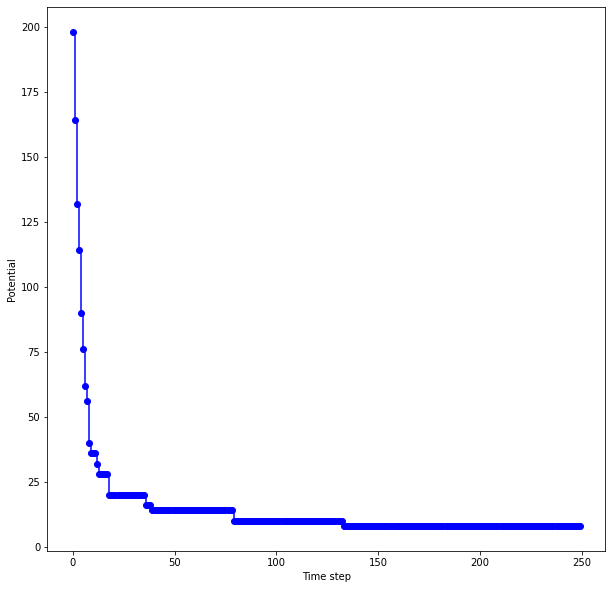

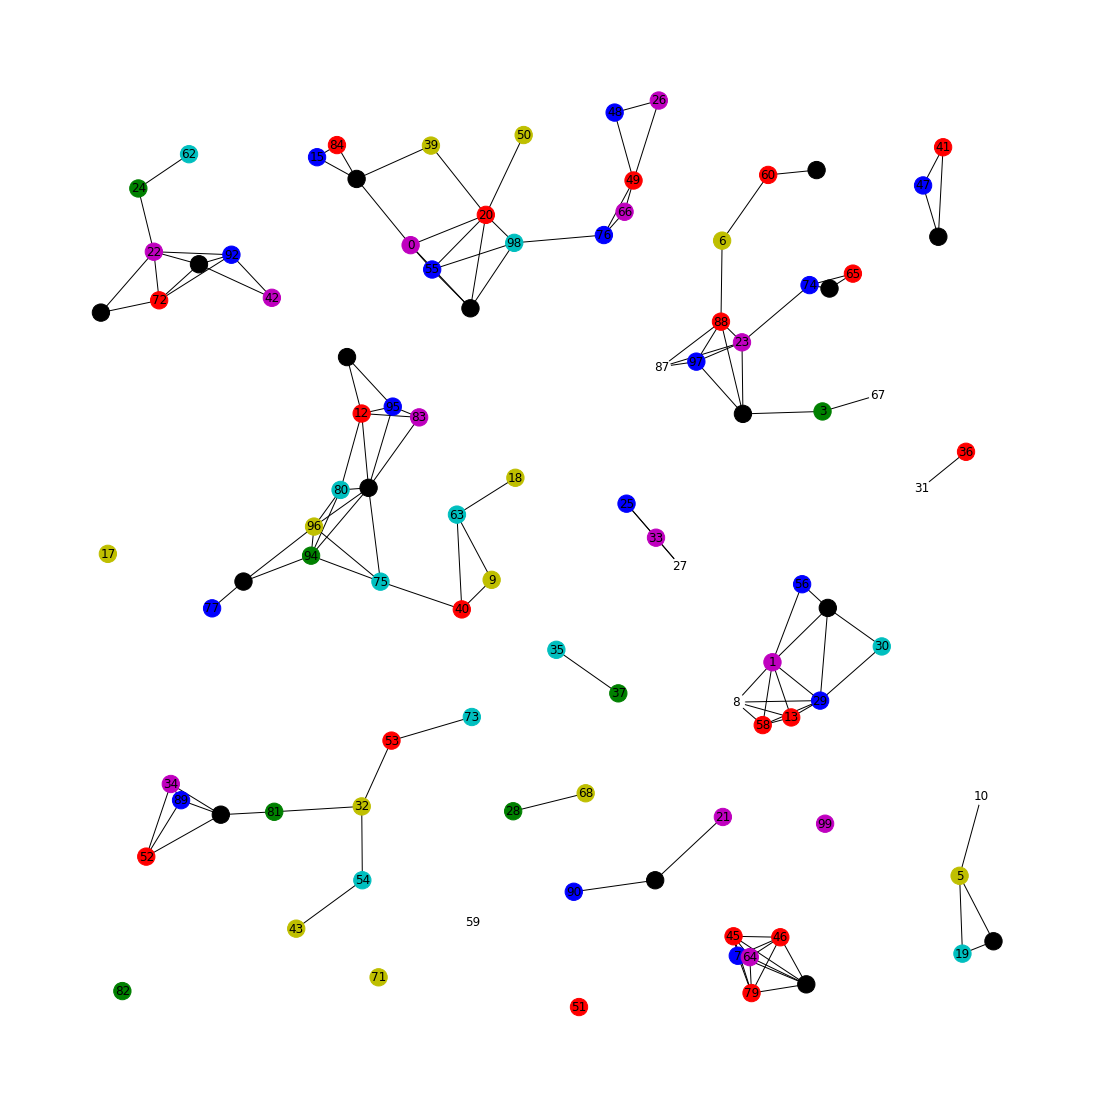

In [ ]:
getValueAndPlots(states_graphs,250,1000)

n_steps = 500
eta = 1000

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 500
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 1000
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 46 with value  8.0


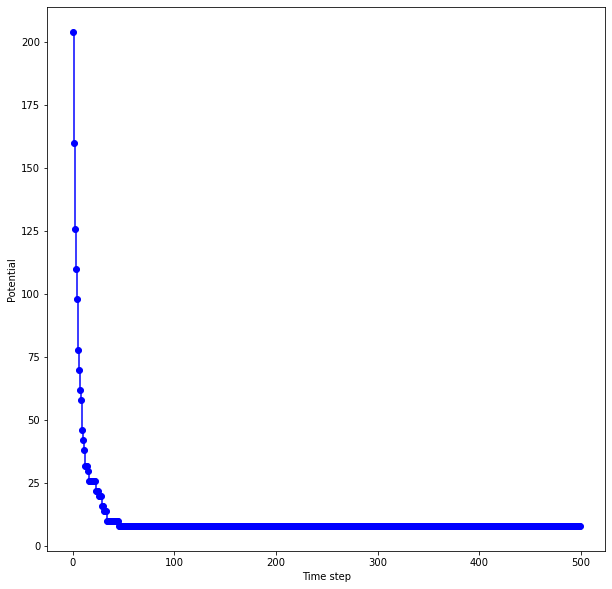

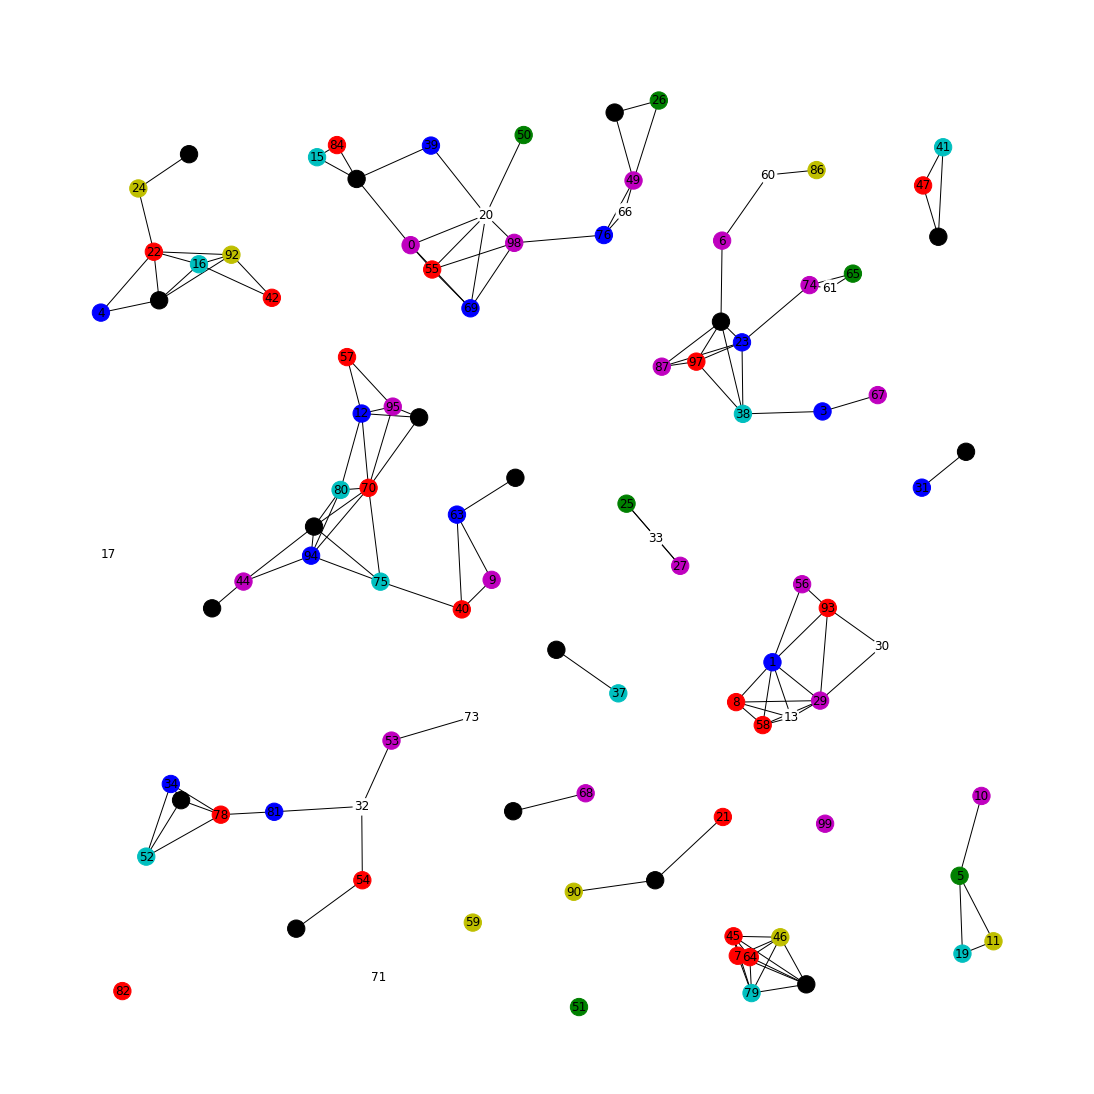

In [ ]:
getValueAndPlots(states_graphs,500,1000)

n_steps = 30
eta = 100

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 30
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 100
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 23 with value  14.0


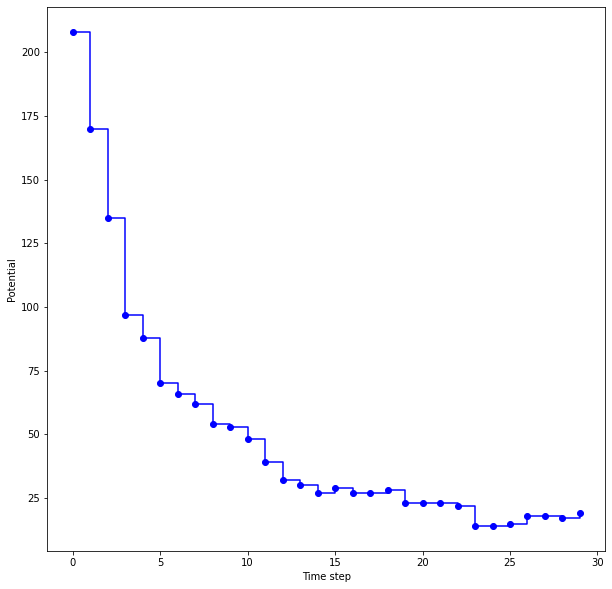

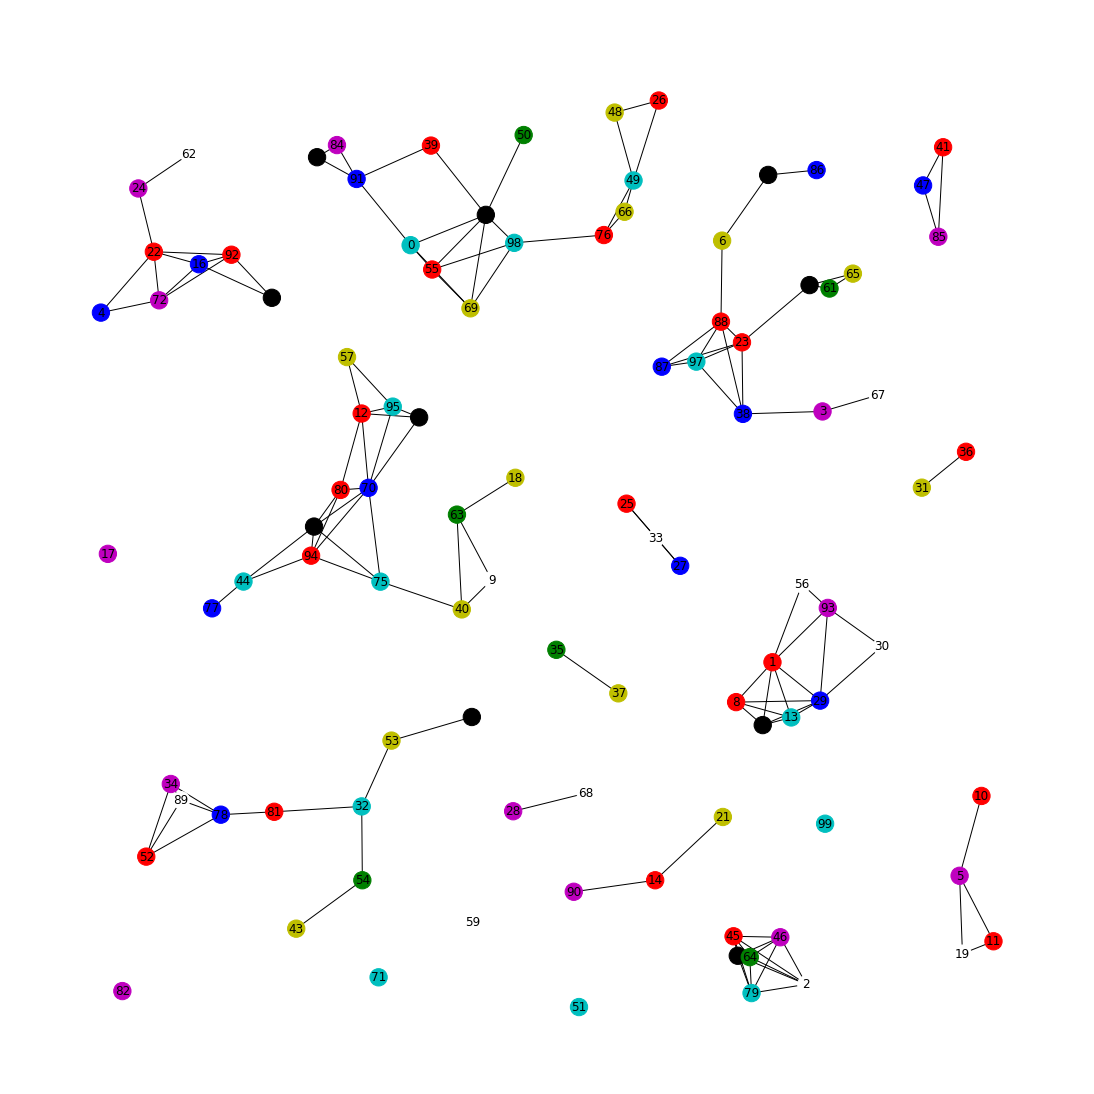

In [ ]:
getValueAndPlots(states_graphs,30,100)

n_steps = 50
eta = 100

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 50
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 100
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 25 with value  13.0


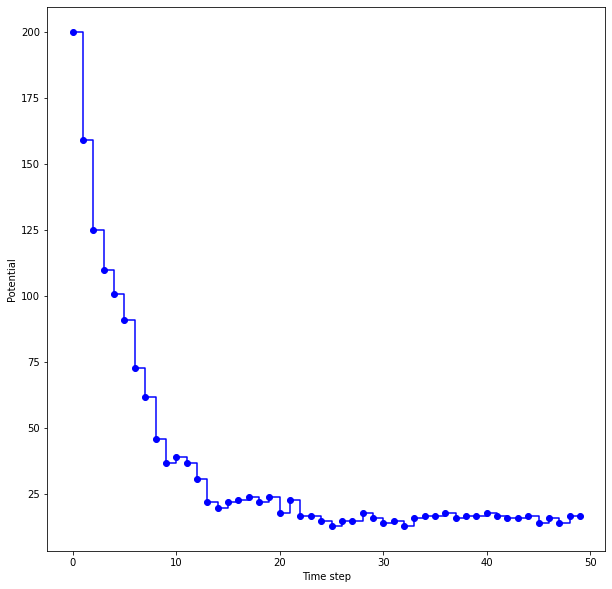

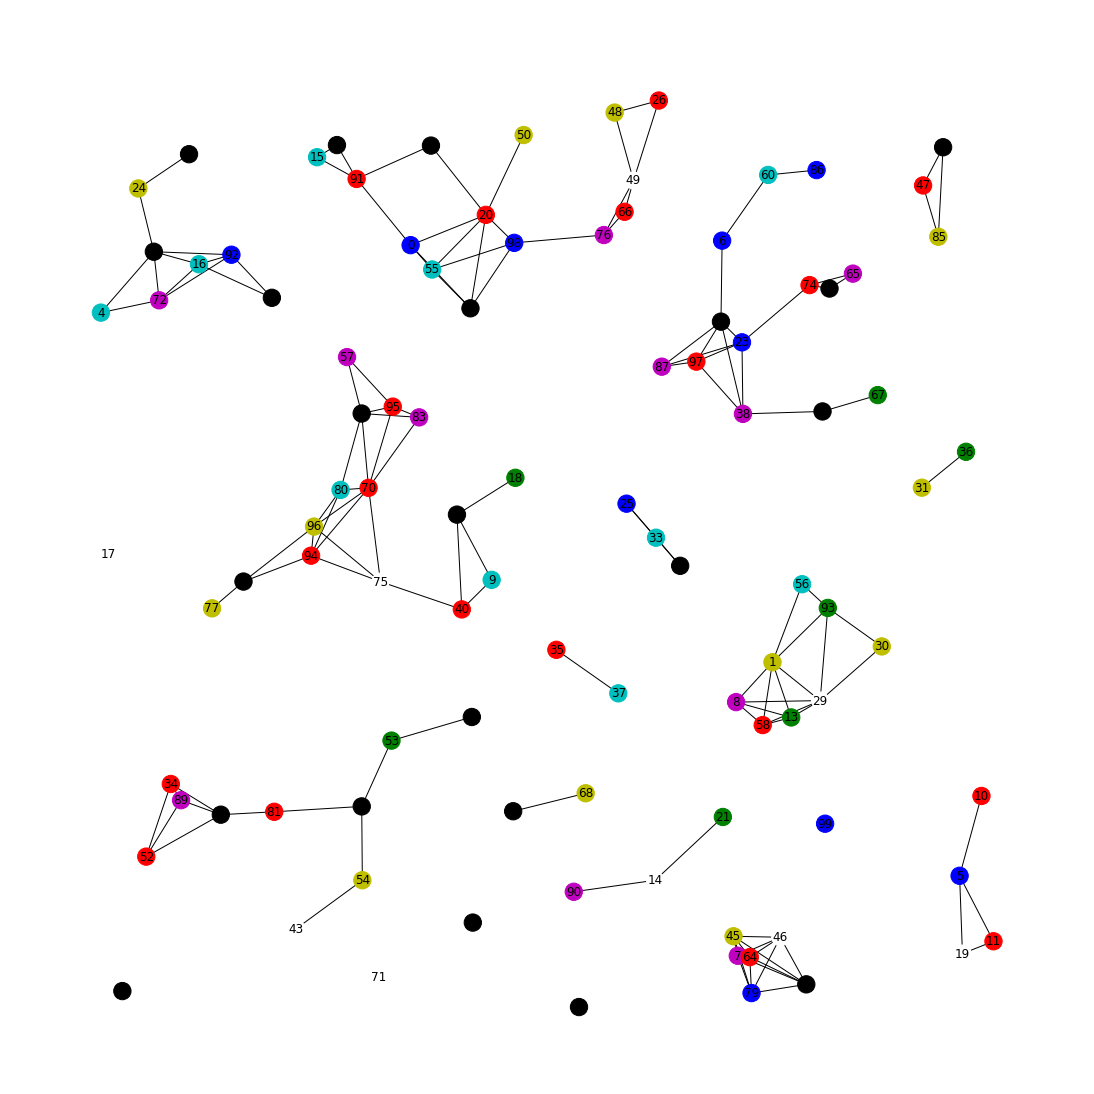

In [ ]:
getValueAndPlots(states_graphs,50,100)

n_steps = 100
eta = 100

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 100
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 100
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 68 with value  4.0


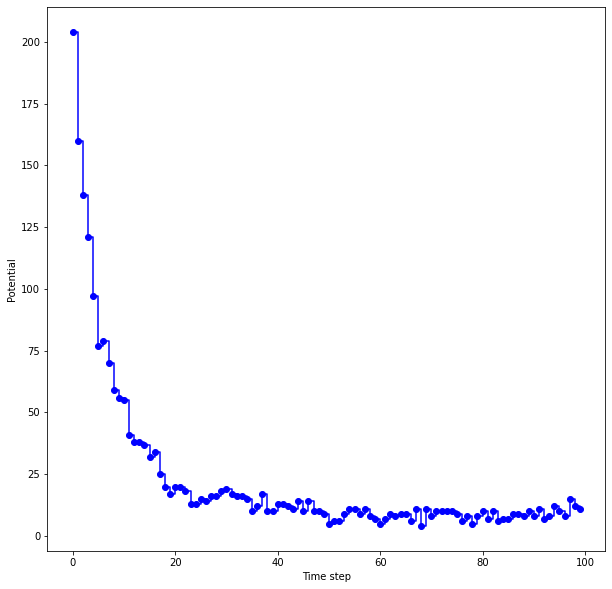

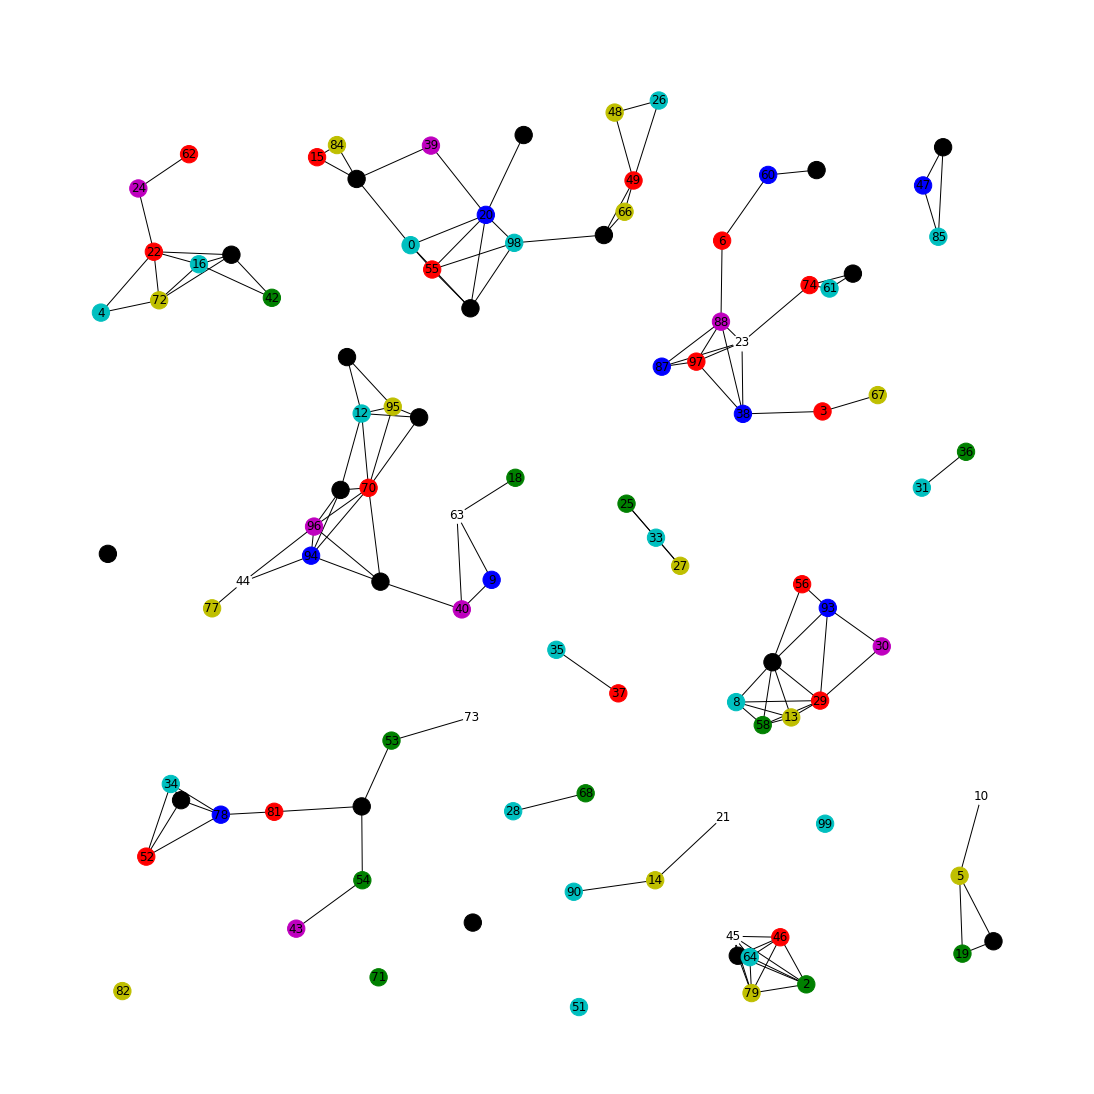

In [ ]:
getValueAndPlots(states_graphs,100,100)

n_steps = 250
eta = 100

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 250
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 100
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 64 with value  5.0


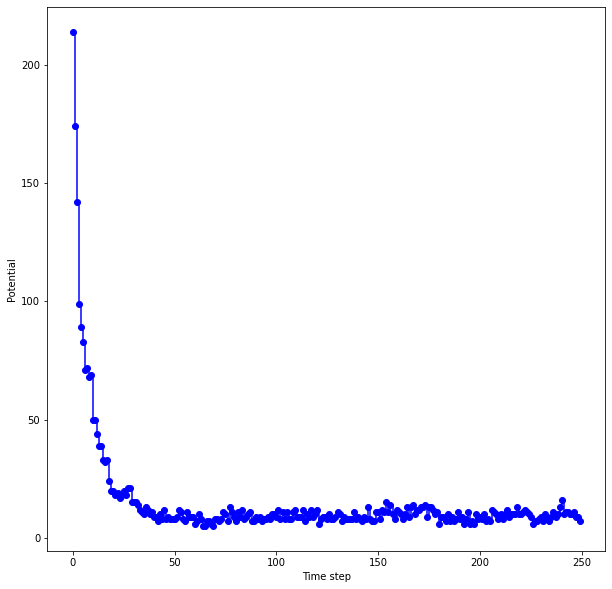

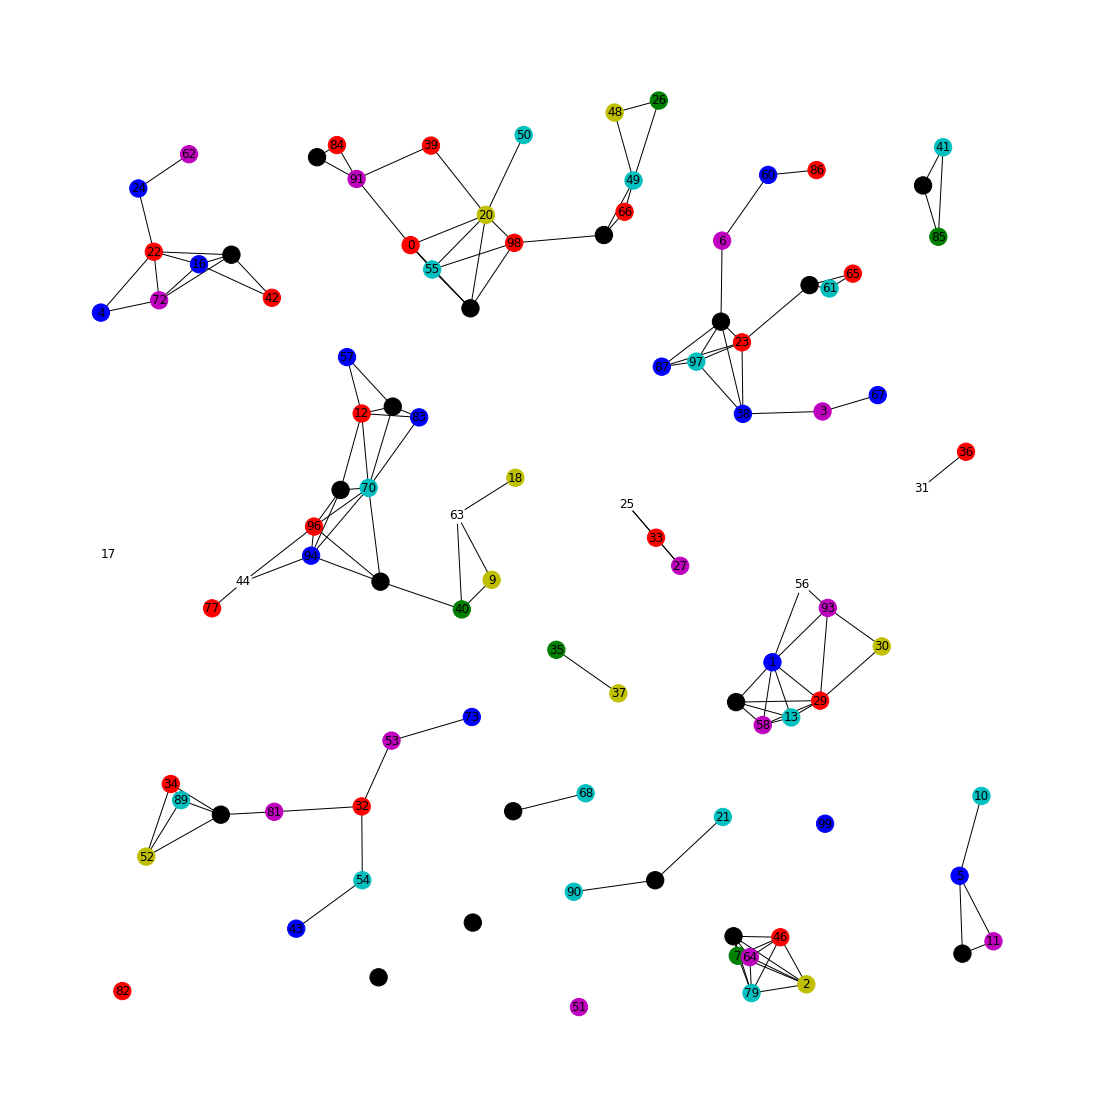

In [ ]:
getValueAndPlots(states_graphs,250,100)

n_steps = 500
eta = 100

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 500
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 100
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 282 with value  4.0


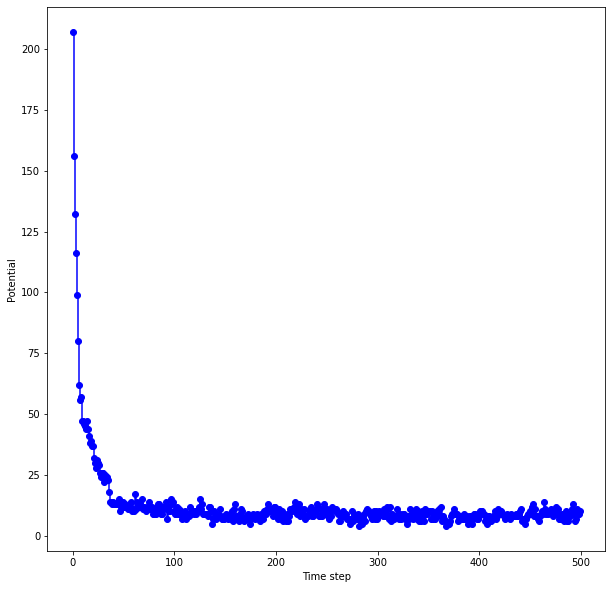

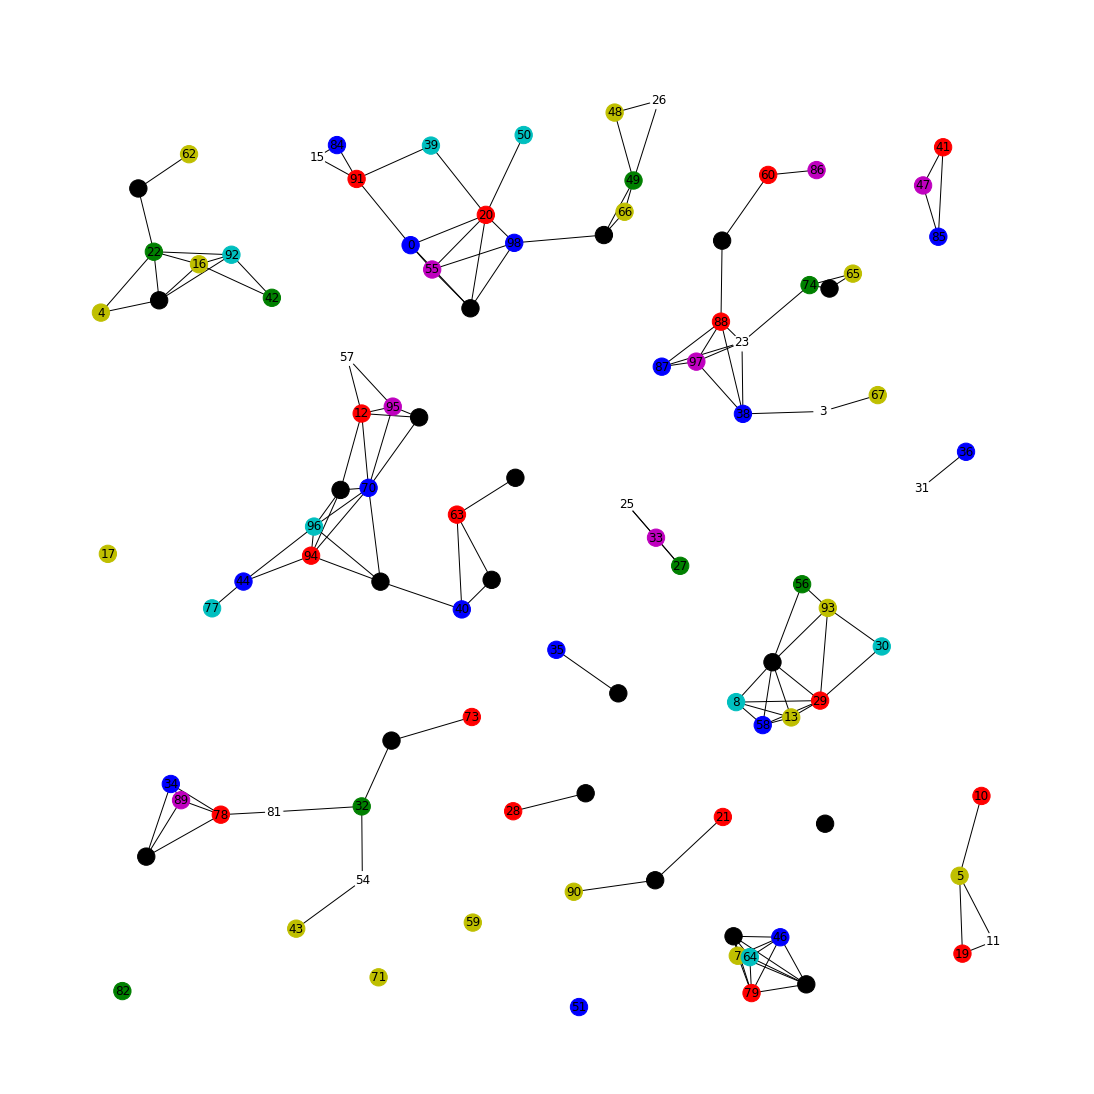

In [ ]:
getValueAndPlots(states_graphs,500,100)

n_steps = 30
eta = 10

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 30
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 10
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 28 with value  21.0


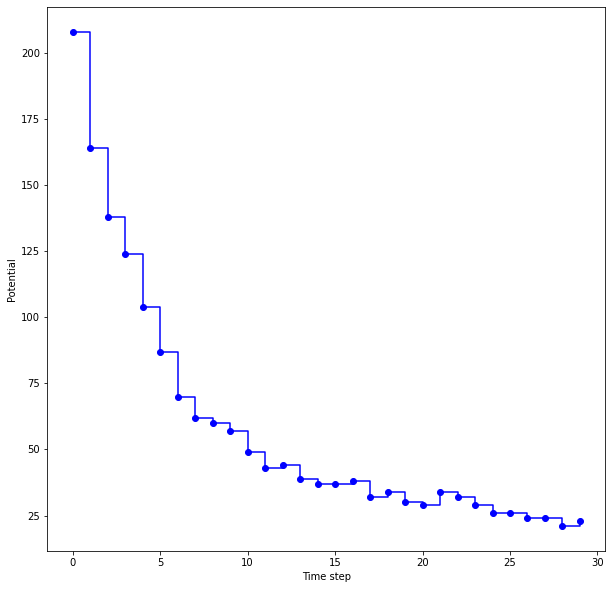

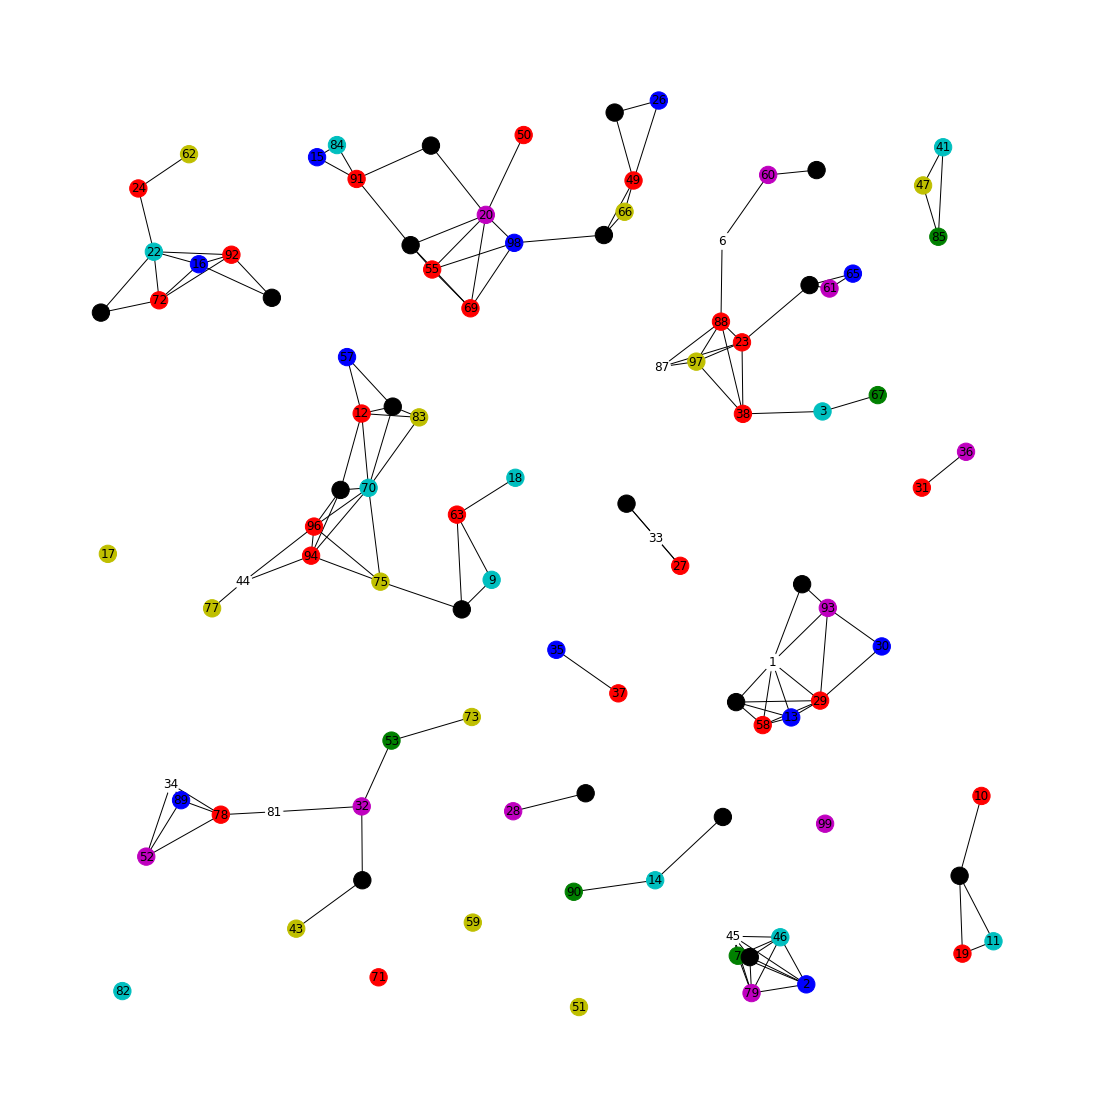

In [ ]:
getValueAndPlots(states_graphs,30,10)

n_steps = 50
eta = 10

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 50
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 10
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 48 with value  12.0


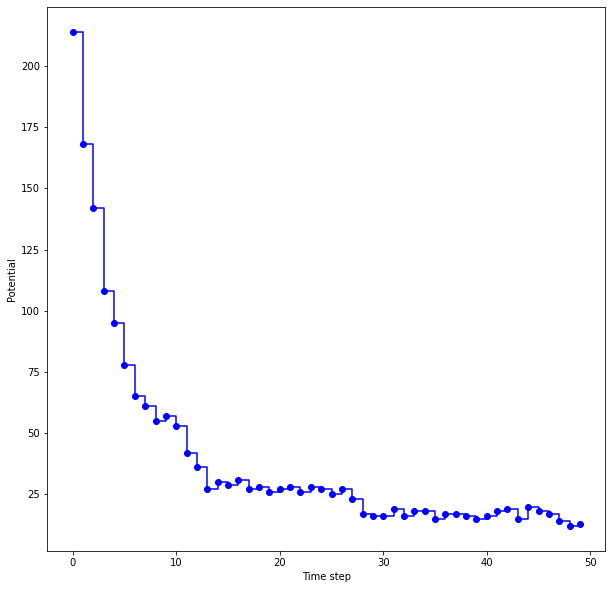

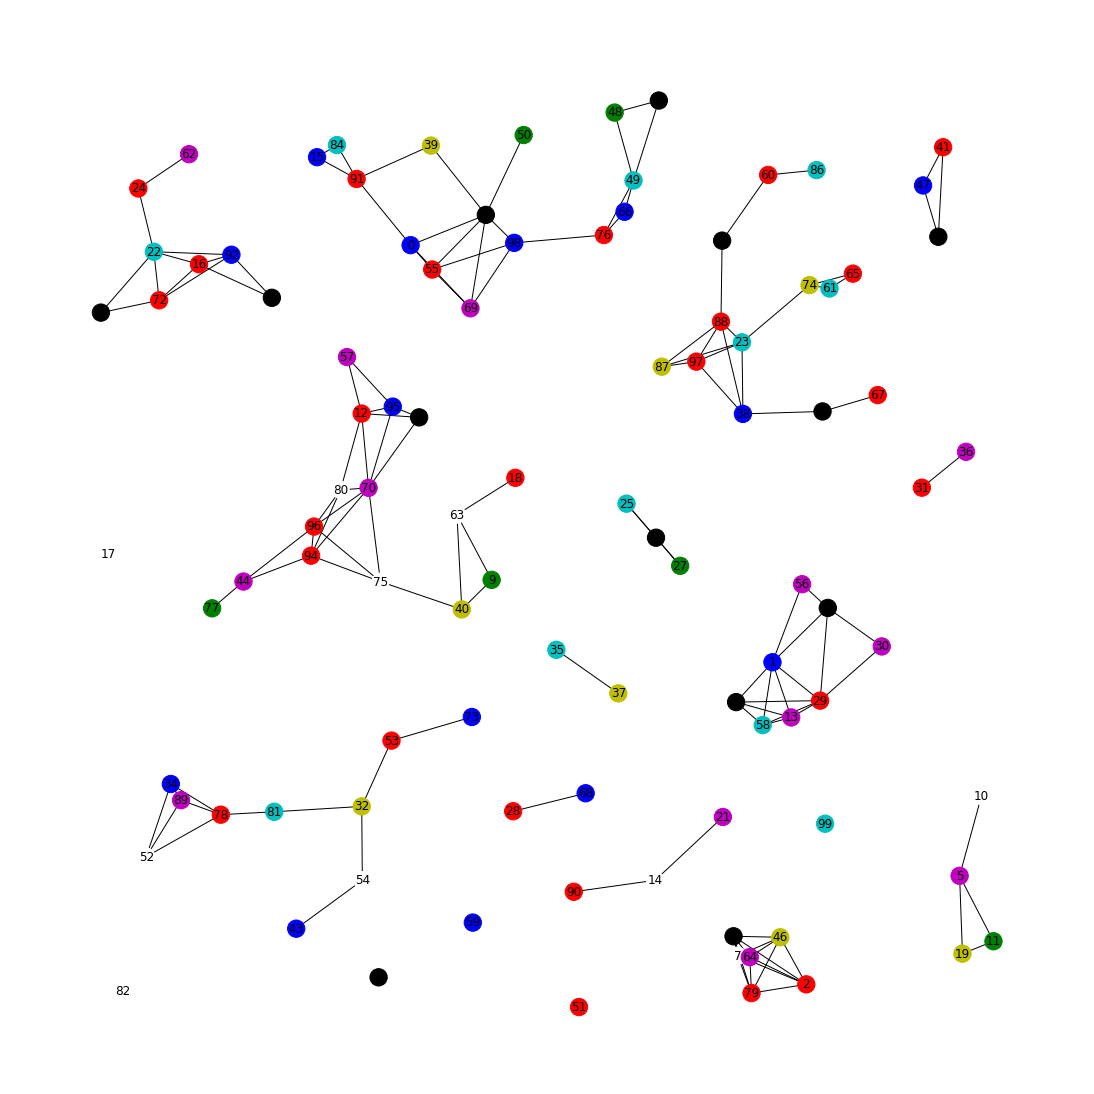

In [ ]:
getValueAndPlots(states_graphs,50,10)

n_steps = 100
eta = 10

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 100
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 10
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 93 with value  7.0


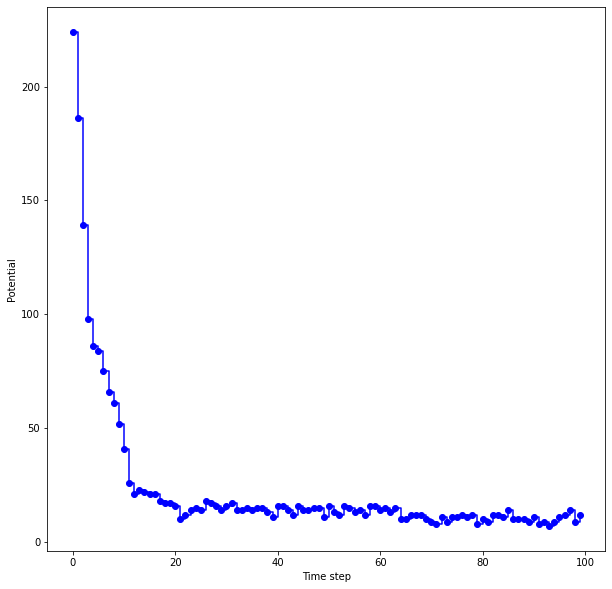

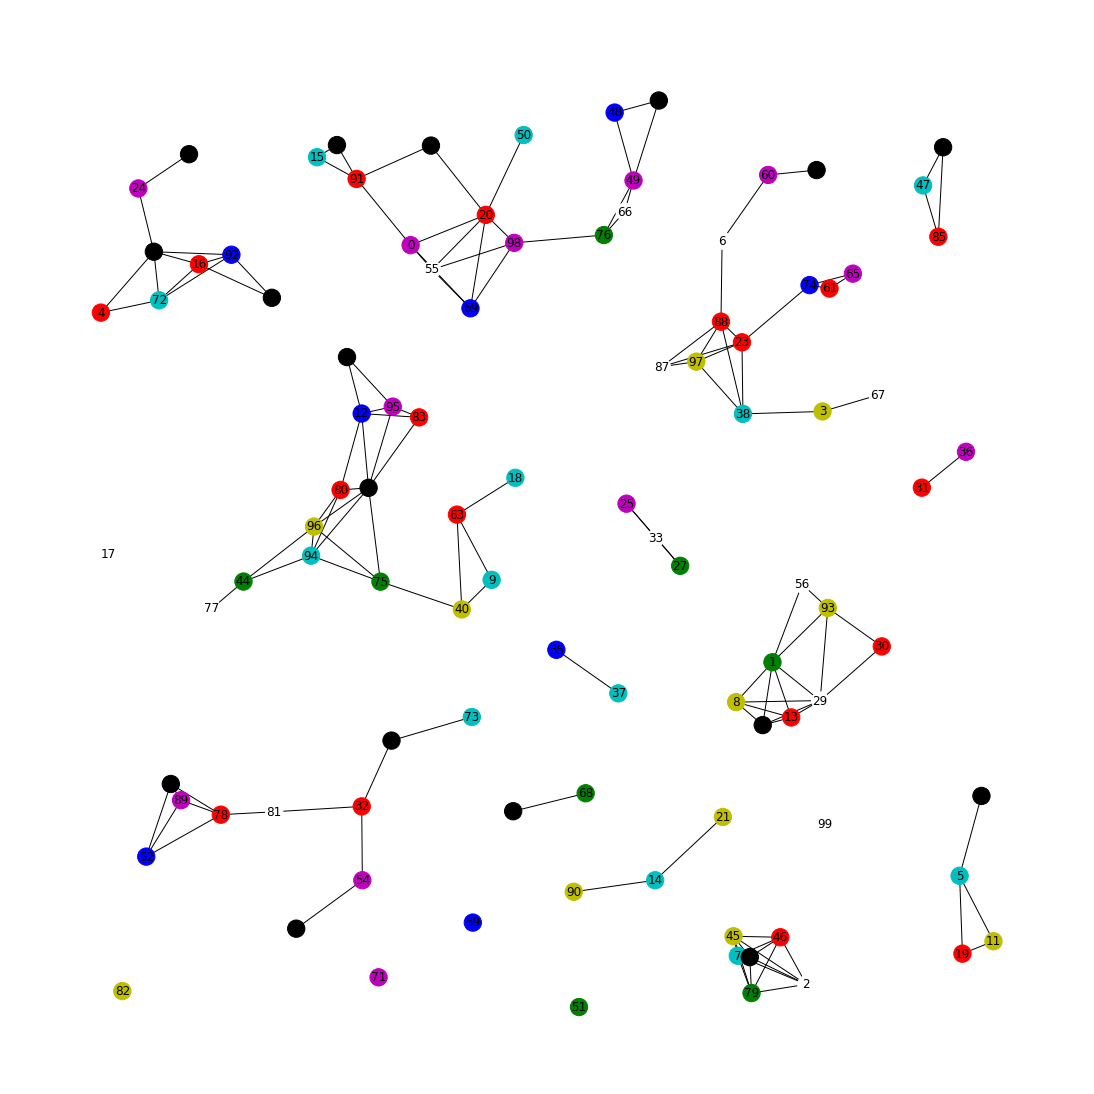

In [ ]:
getValueAndPlots(states_graphs,100,10)

n_steps = 250
eta = 10

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 250
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 10
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 247 with value  5.0


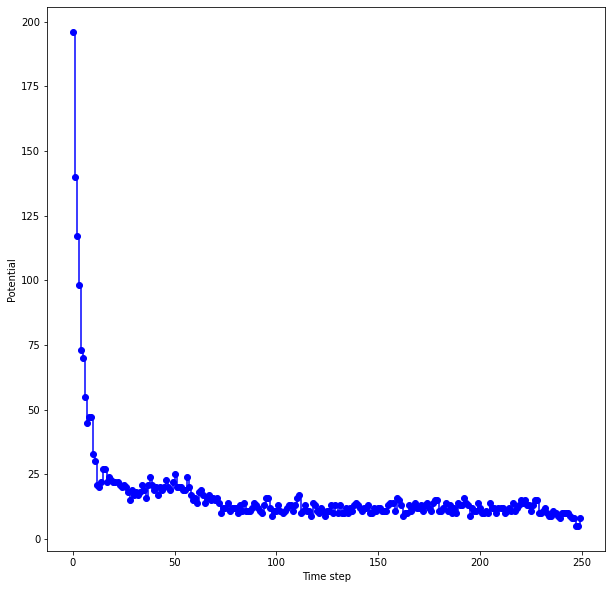

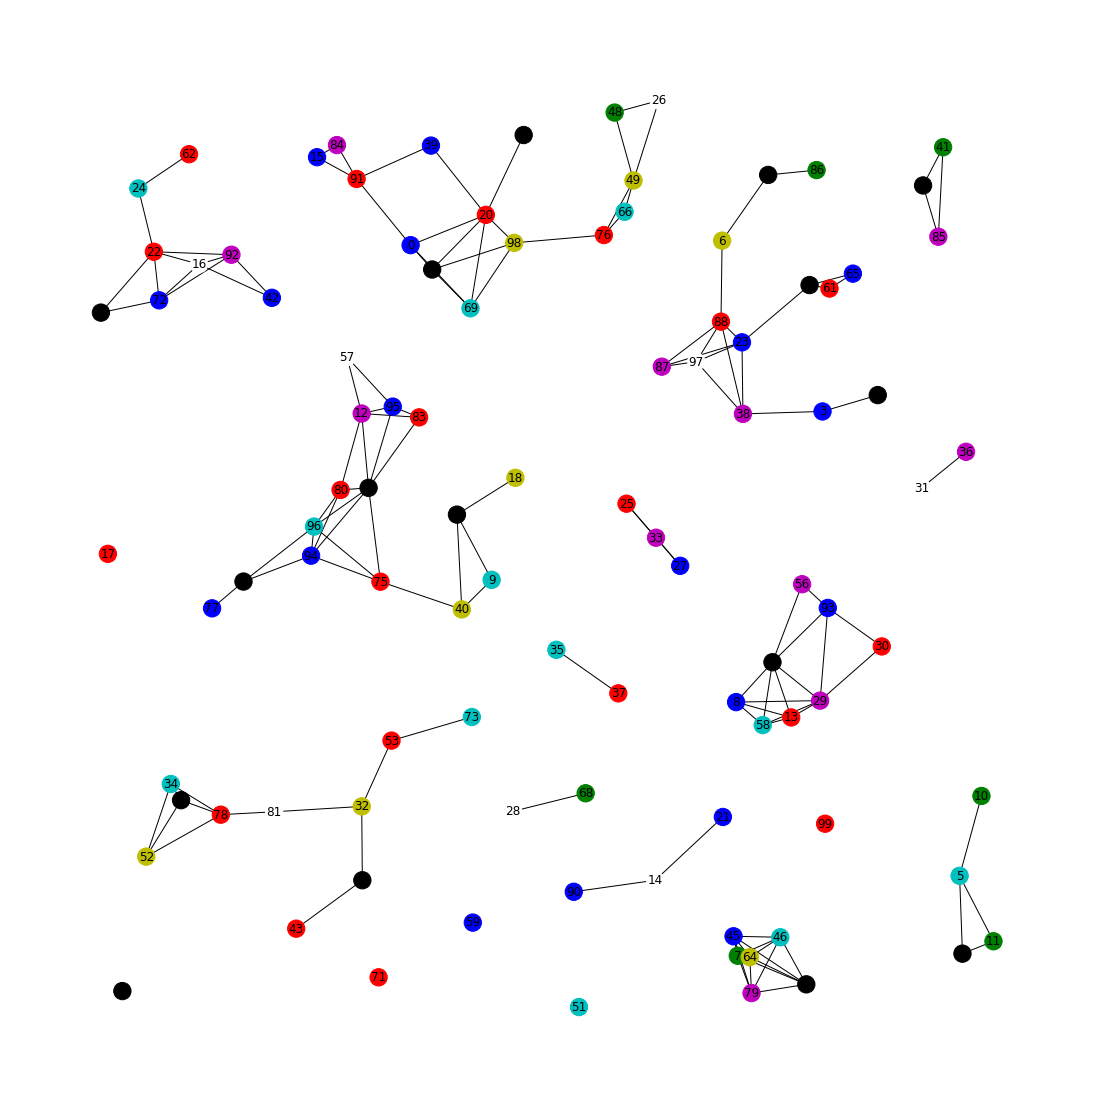

In [ ]:
getValueAndPlots(states_graphs,250,10)

n_steps = 500
eta = 10

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 500
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 10
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 283 with value  4.0


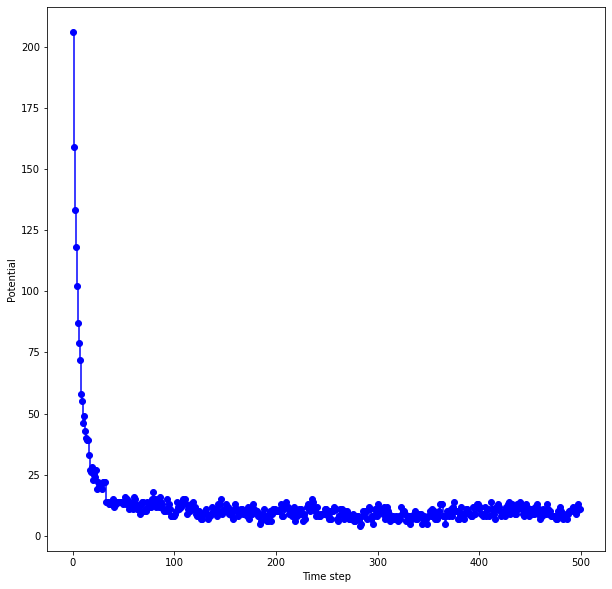

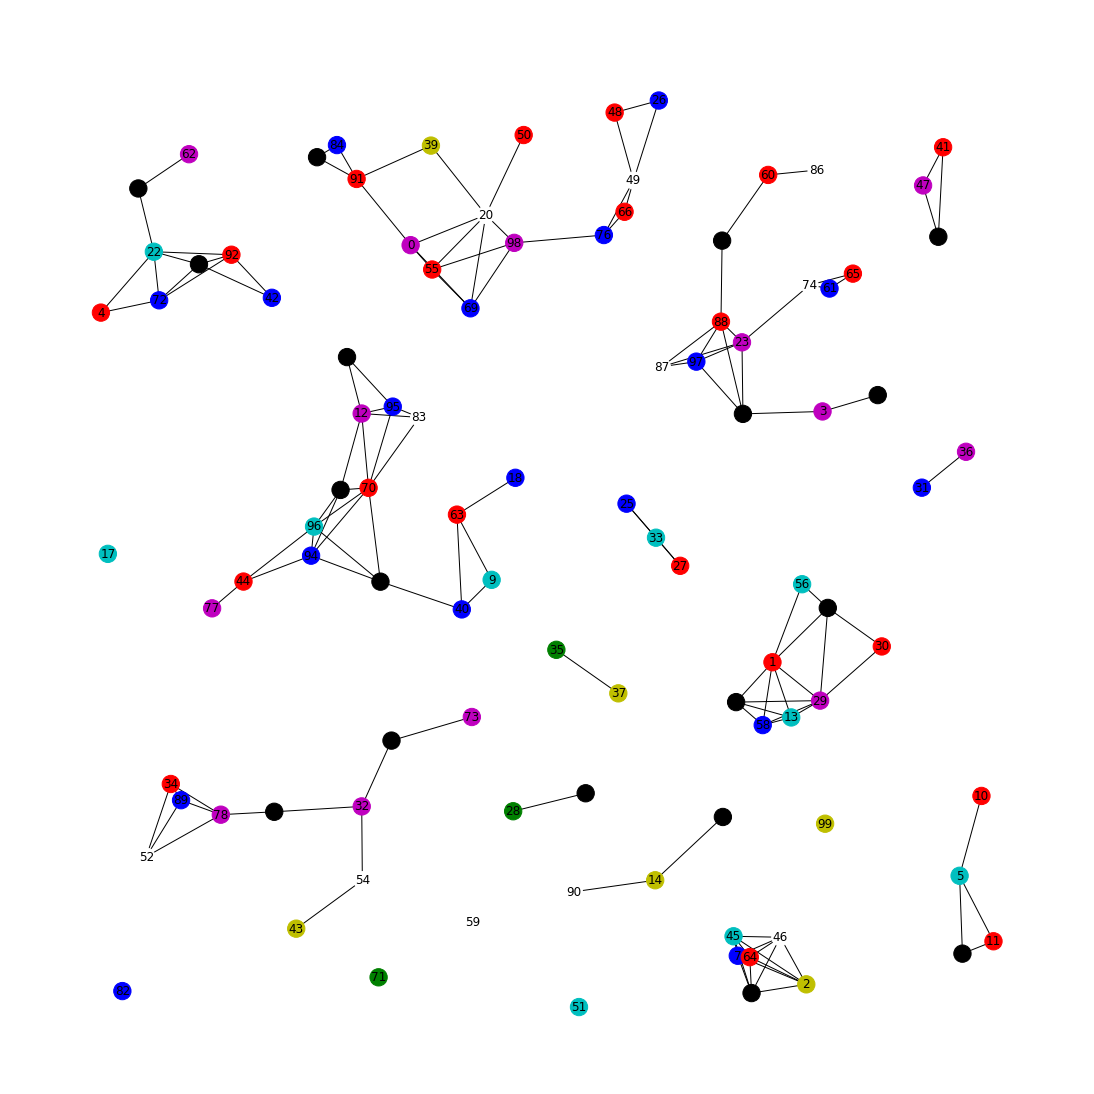

In [ ]:
getValueAndPlots(states_graphs,500,10)

n_steps = 30
eta = e^t

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 30
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = math.exp(t)
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 22 with value  7.0


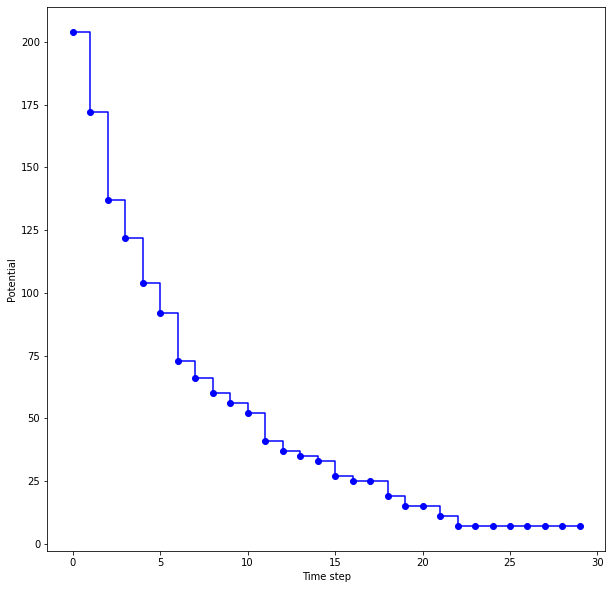

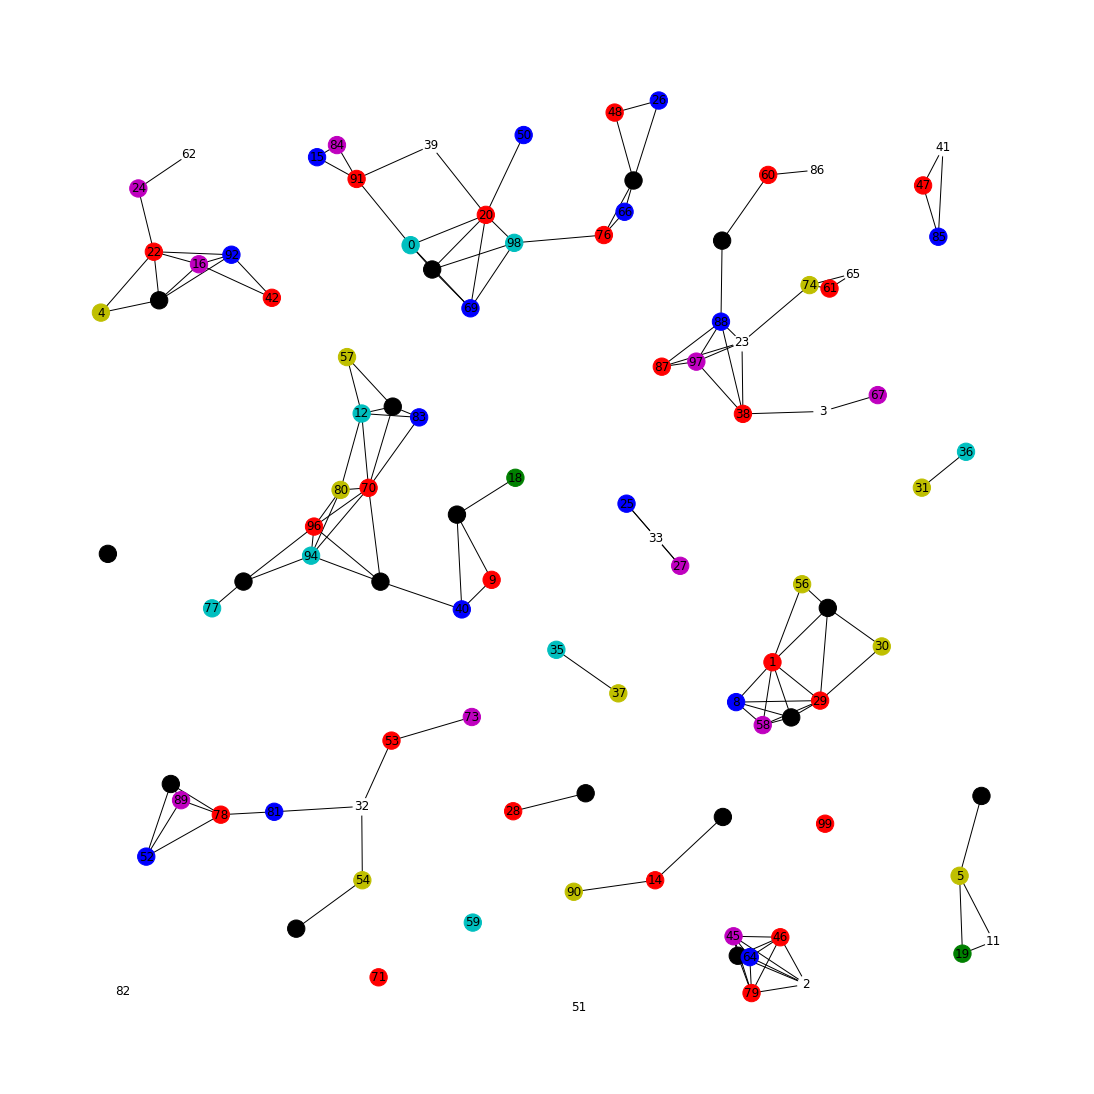

In [ ]:
getValueAndPlots(states_graphs,30,math.exp(t))

n_steps = 50
eta = e^t

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 50
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = math.exp(t)
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 48 with value  7.0


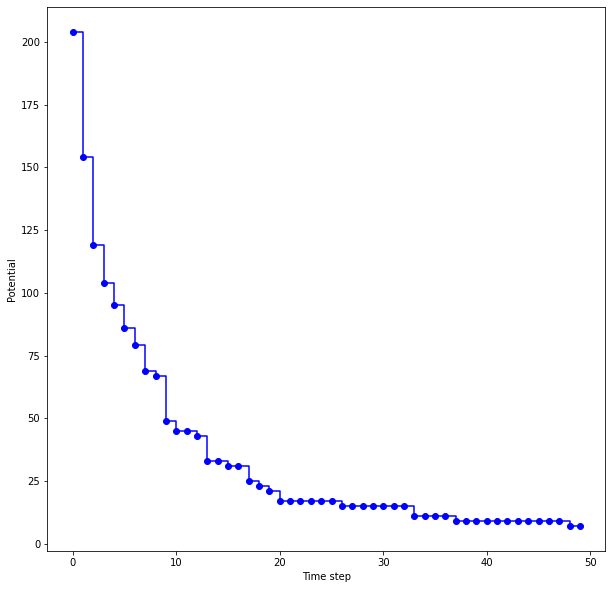

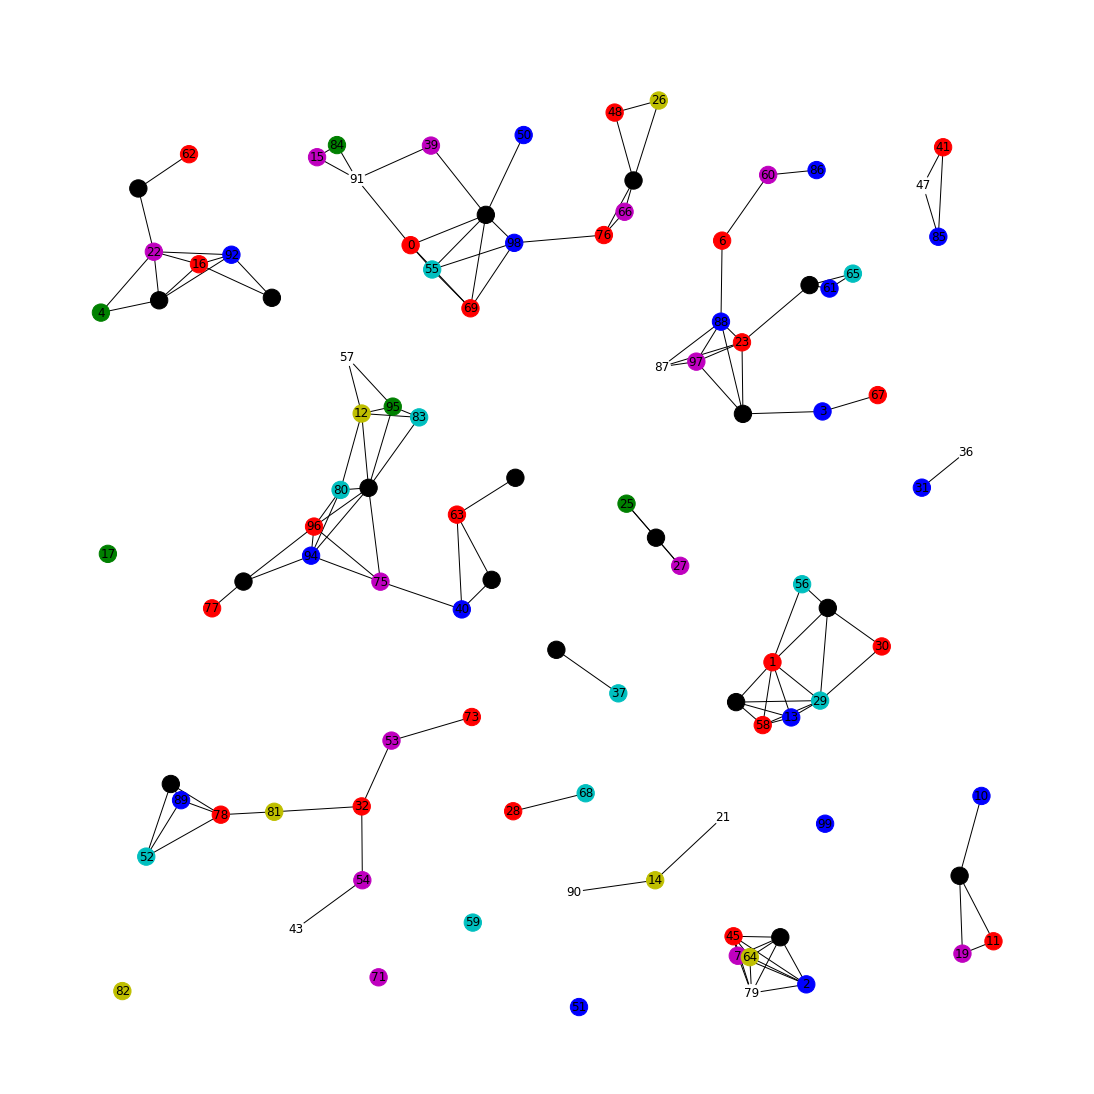

In [ ]:
getValueAndPlots(states_graphs,50,math.exp(t))

n_steps = 100
eta = e^t

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 100
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = math.exp(t)
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 67 with value  5.0


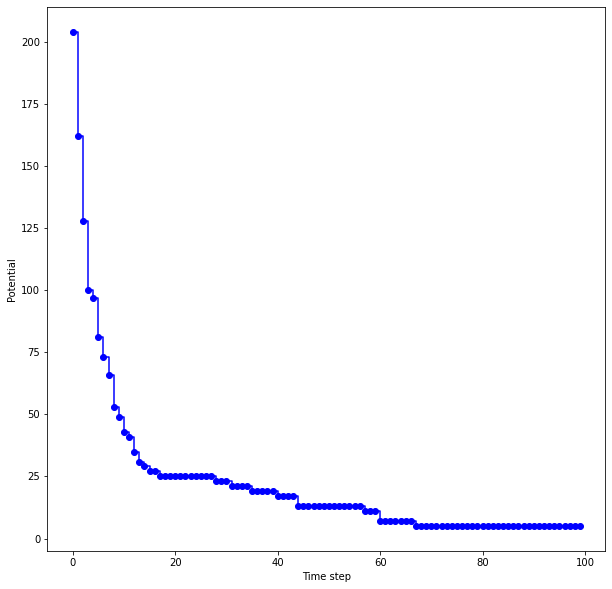

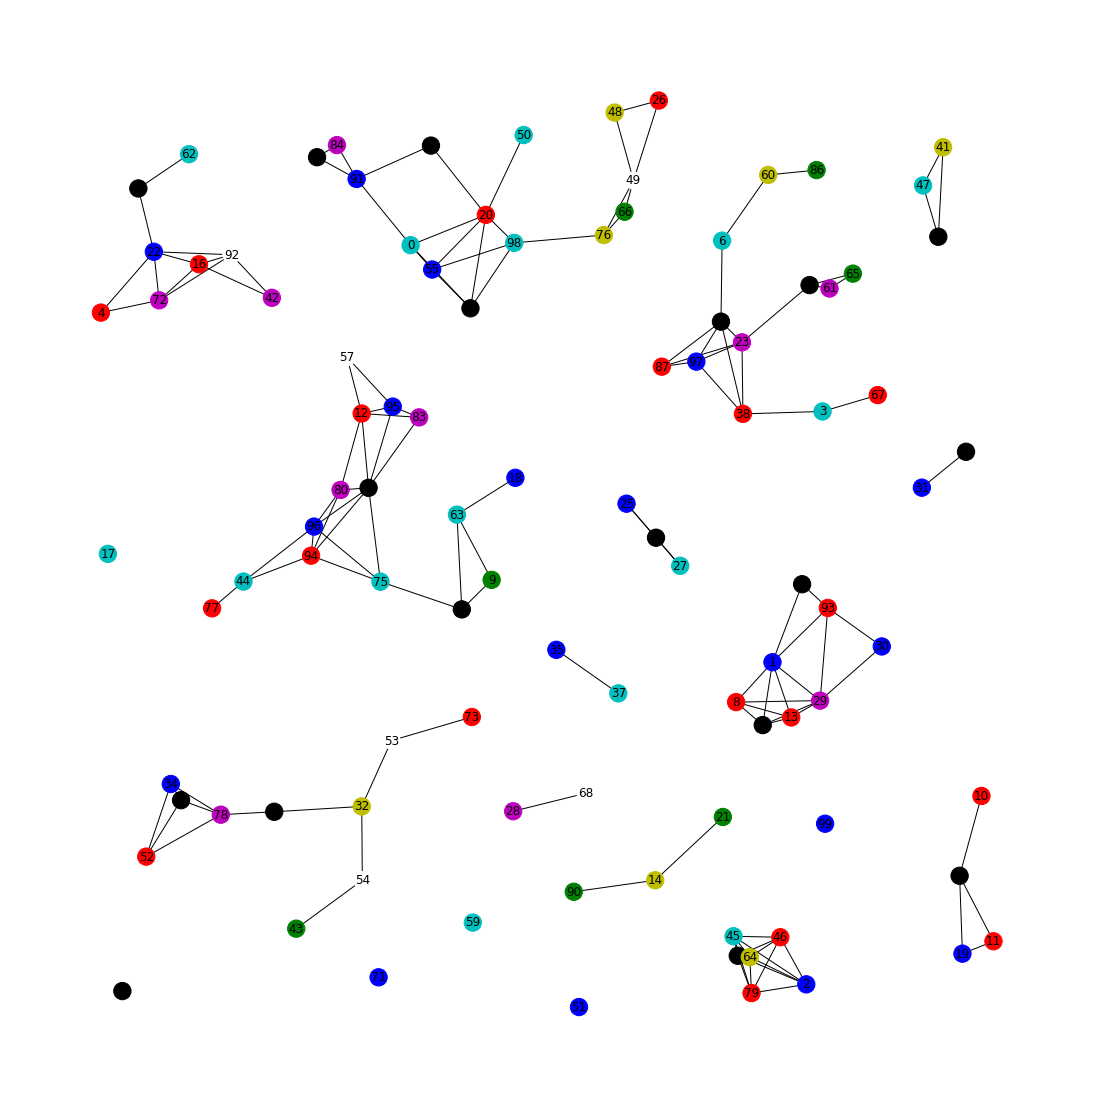

In [ ]:
getValueAndPlots(states_graphs,100,math.exp(t))

n_steps = 250
eta = e^t

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 250
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = math.exp(t)
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 108 with value  5.0


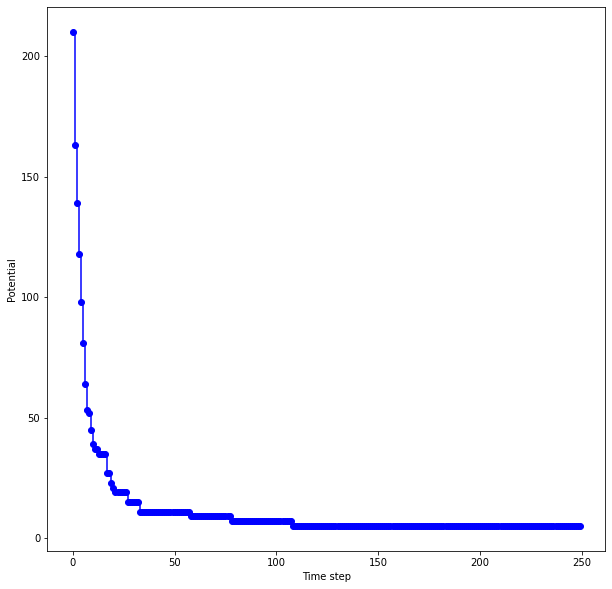

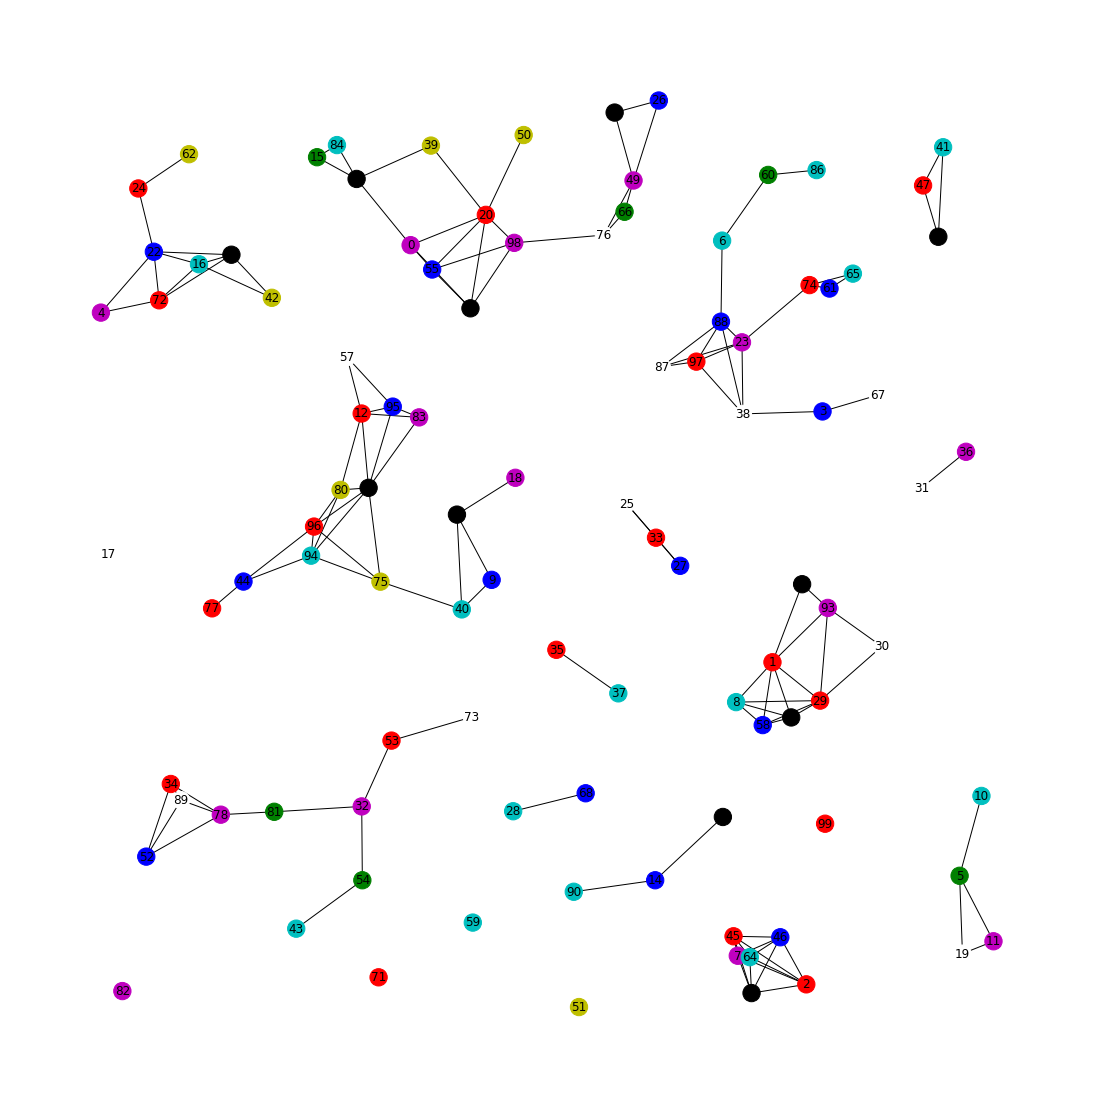

In [ ]:
getValueAndPlots(states_graphs,250,math.exp(t))

n_steps = 500
eta = e^t

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 500
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = math.exp(t)
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 65 with value  5.0


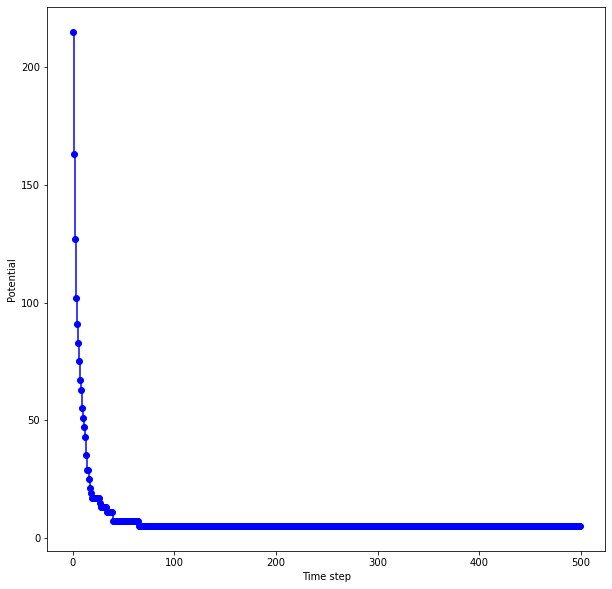

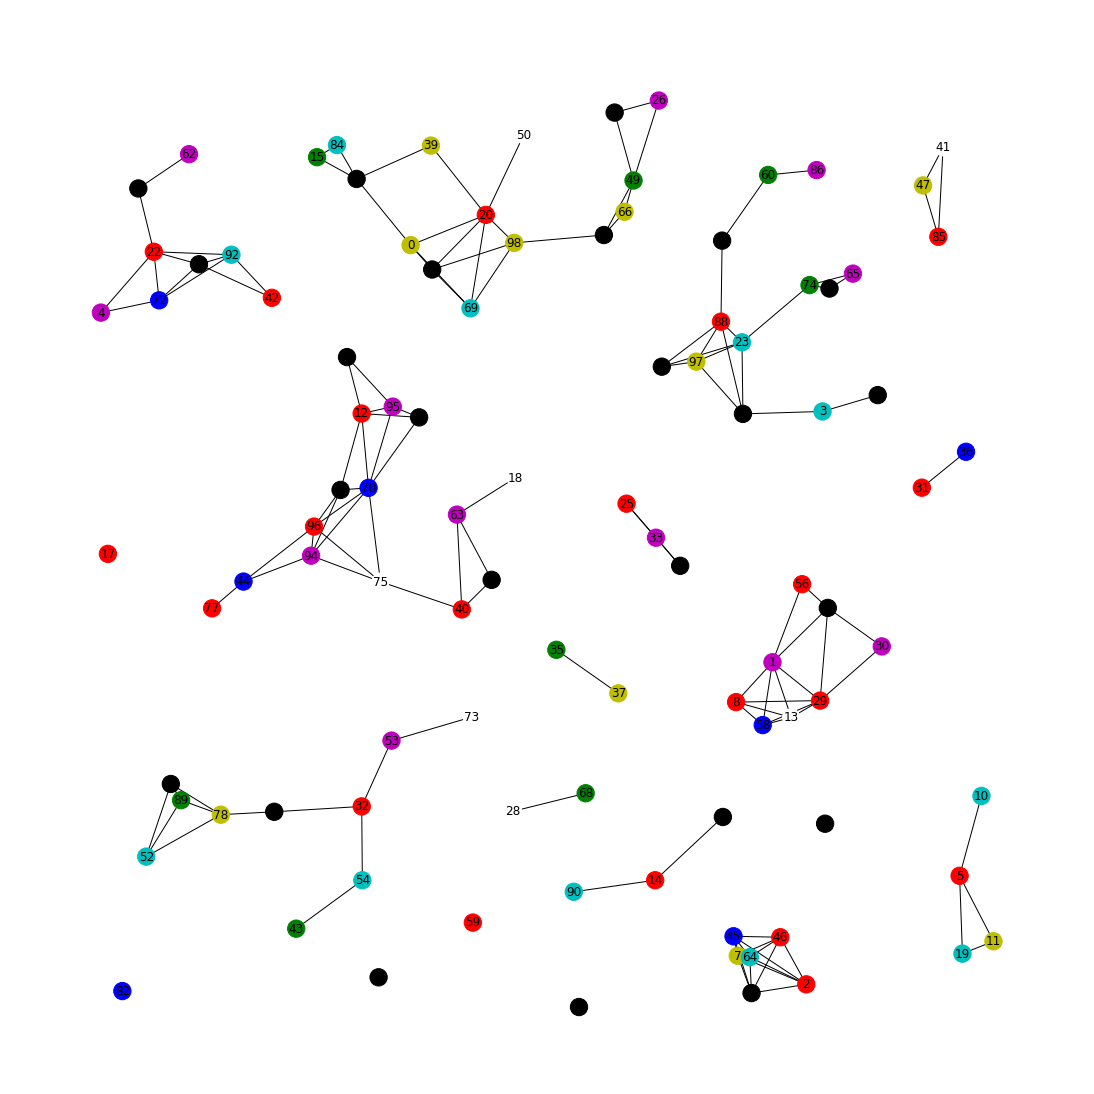

In [ ]:
getValueAndPlots(states_graphs,500,math.exp(t))

n_steps = 30
eta = 10*t

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 30
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 10*t
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 24 with value  17.0


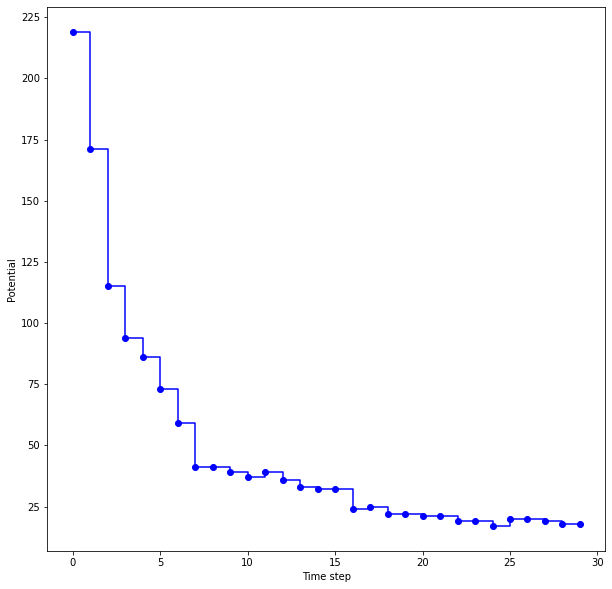

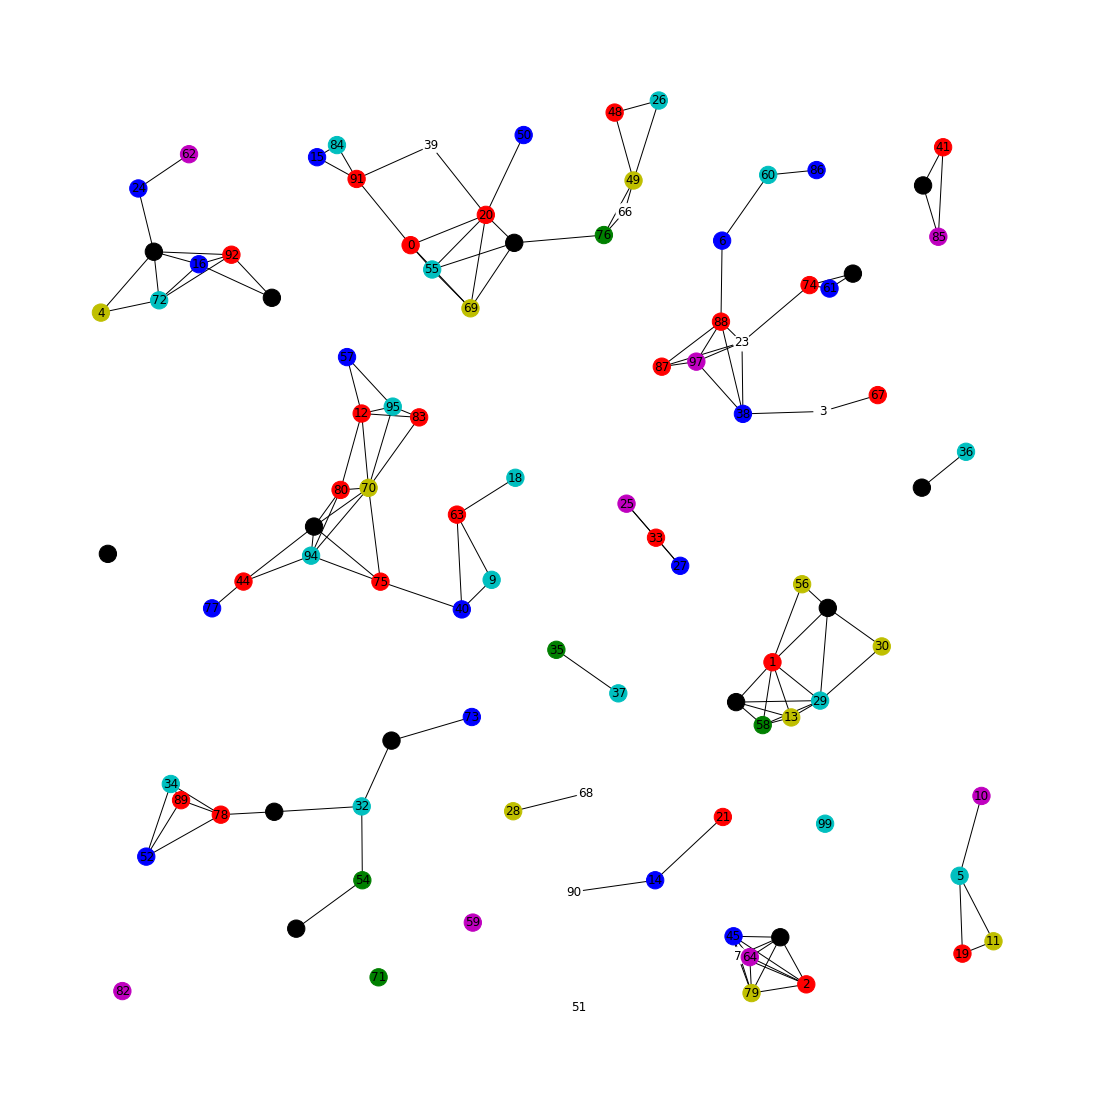

In [ ]:
getValueAndPlots(states_graphs,30,10*t)

n_steps = 50
eta = 10*t

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 50
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 10*t
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 40 with value  8.0


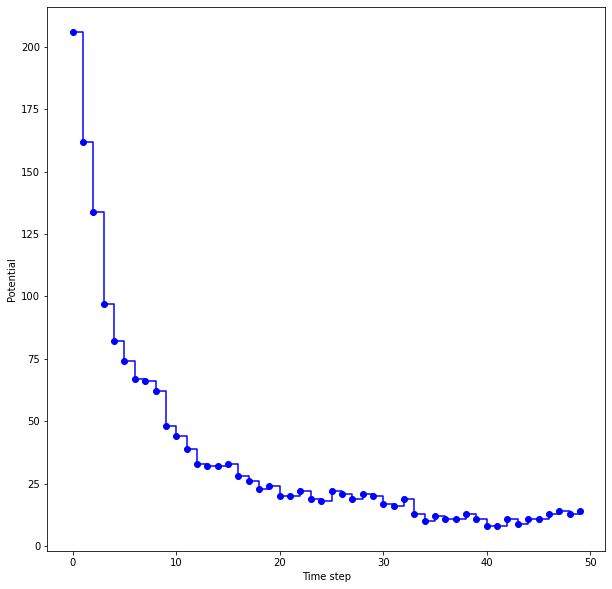

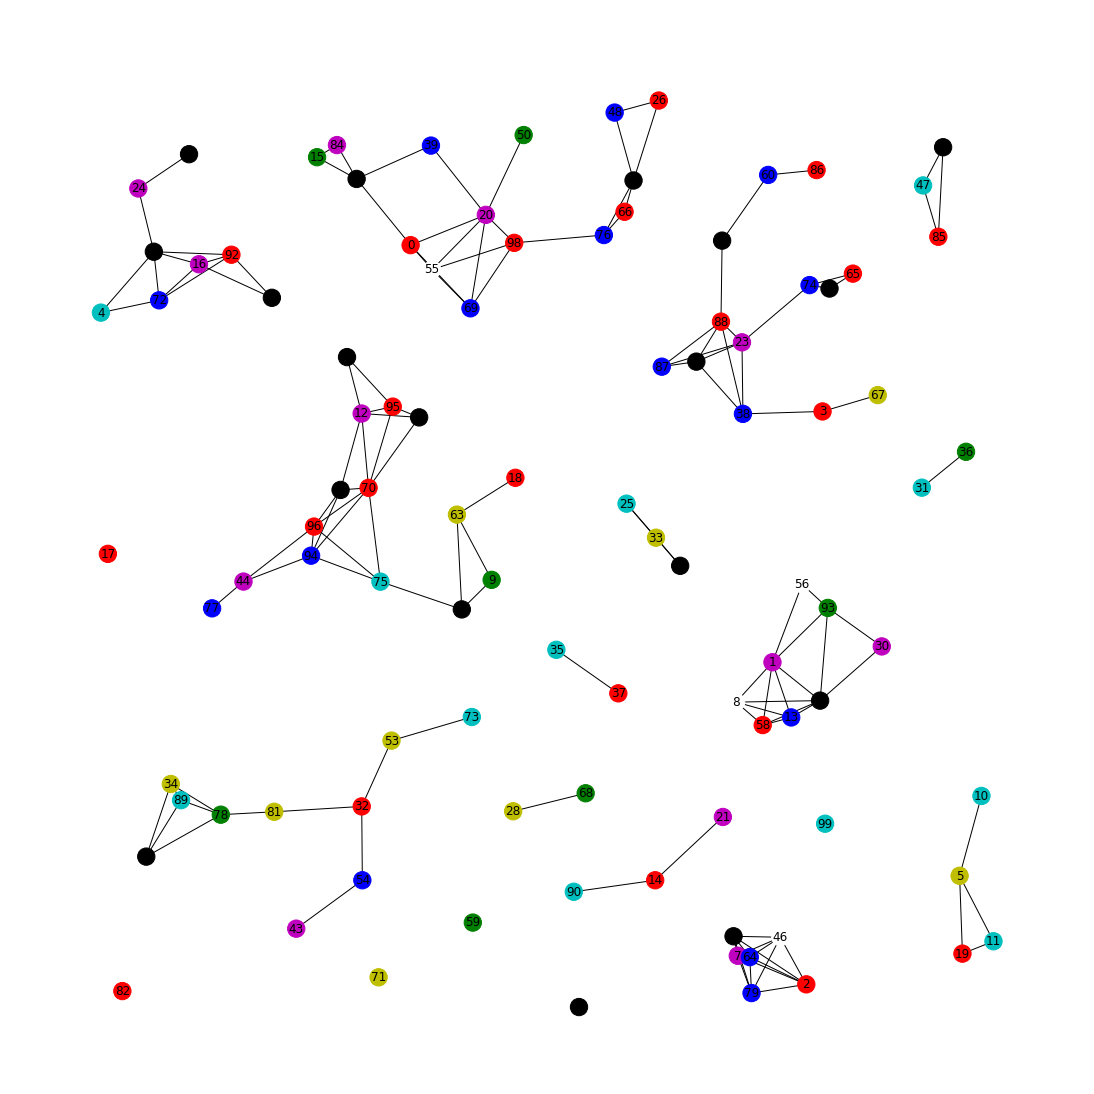

In [ ]:
getValueAndPlots(states_graphs,50,10*t)

n_steps = 100
eta = 10*t

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 100
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 10*t
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 84 with value  7.0


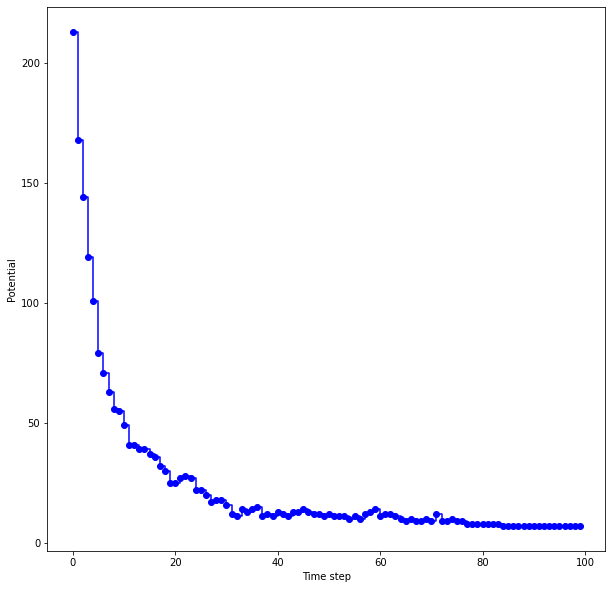

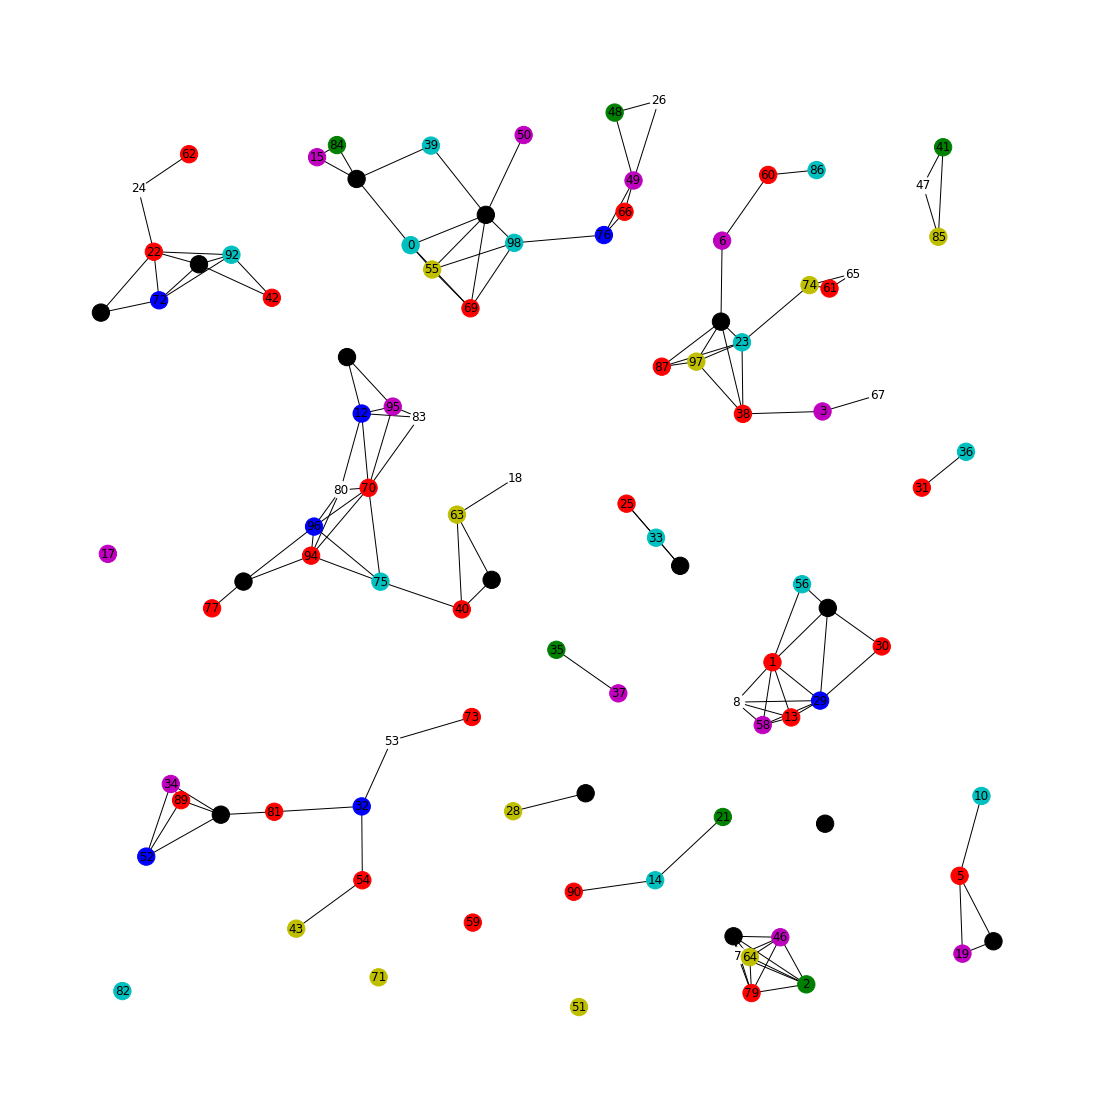

In [ ]:
getValueAndPlots(states_graphs,100,10*t)

n_steps = 250
eta = 10*t

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 250
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 10*t
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 221 with value  4.0


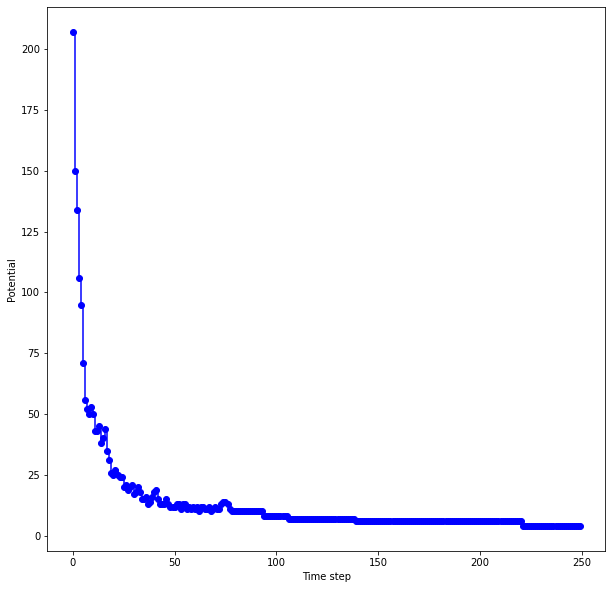

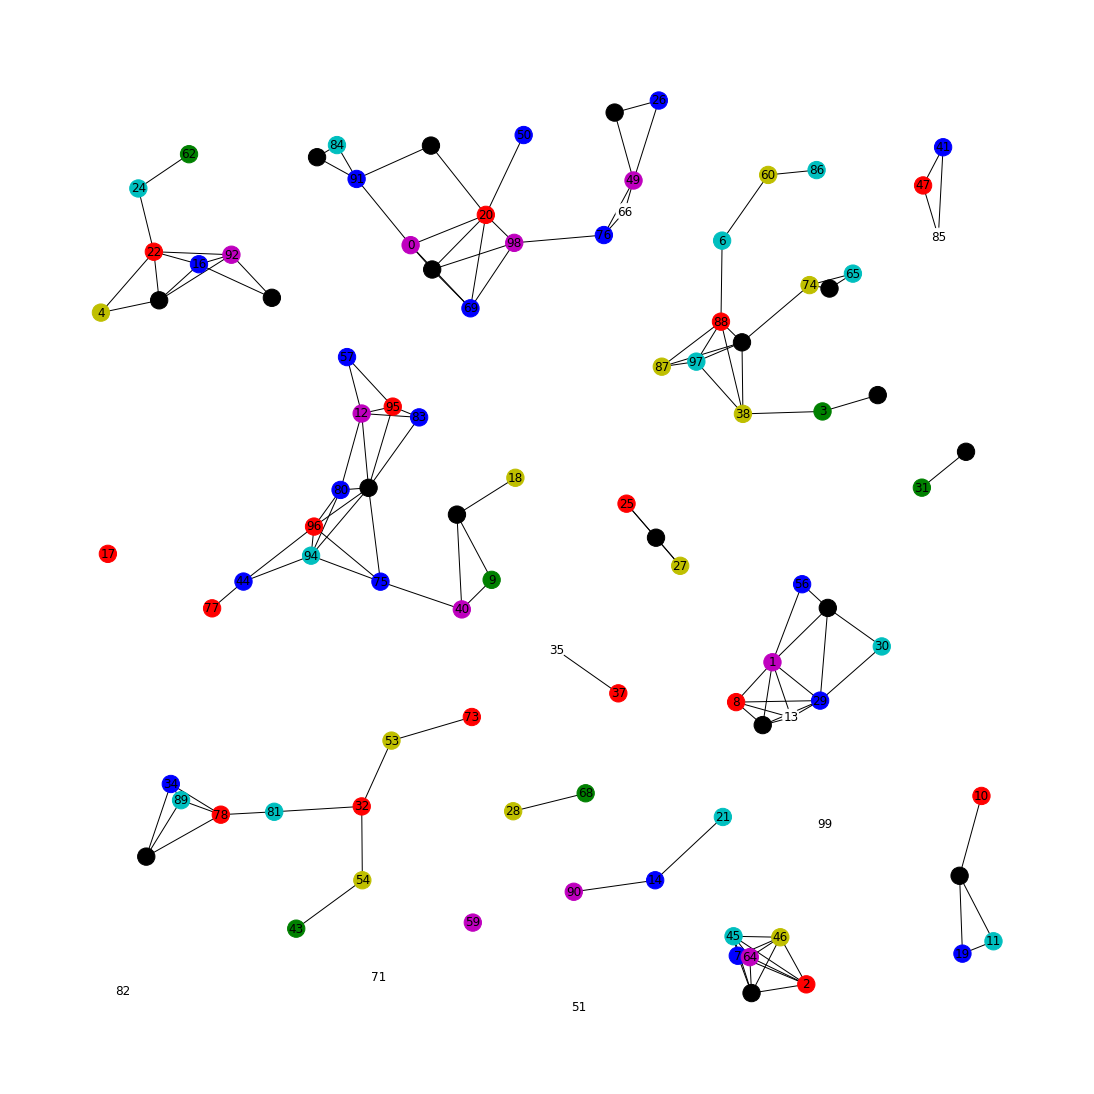

In [ ]:
getValueAndPlots(states_graphs,250,10*t)

n_steps = 500
eta = 10*t

In [ ]:
#defining a list where each graph state over time will be saved
states_graphs = []


#for every graph in the dictionary we implement the distributed learning algorithm
for i in range(20):
    g = dict[i]
    players = list(g.nodes)
    n_players = len(players)
    #we start with an all red graph as for a long simulation the 
    #first state does not influence the final result
    x0 = np.zeros(n_players, dtype=int)
    #for every node we have a 2 possible state. Therefore for the whole grpah we have 8^n_players combinations
    n_states = tuple(n_actions for _ in range(len(g)))
    #defining simulation time
    n_steps = 500
    states = np.zeros(n_steps, dtype=np.int64)  
    states[0] = np.ravel_multi_index(tuple(x0), dims = n_states)
    
    for t in range(0,n_steps):
        # we consider the current configuration
        x = np.unravel_index(states[t-1],shape=n_states)
        x = np.array(x)
        # define a list of admissible destination configurations
        destinations = list()
        utilities = list()
        # admissible destinations differ from the current configuration
        # for the state of a single agent
        for player in range(n_players):
            # construct an admissible destination by changing
            # one of the player colors            
            y = np.array(x)
            
            #to not choose the same color we use a new list without the color of time t-1
            new_actions = [0,1,2,3,4,5,6,7]
            new_actions.remove(y[player])
            y[player] = np.random.choice(new_actions)
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            destinations.append(y_id)
            # To compute the transition rate from the current state an onther possible state
            # we start by computing the utility of the player. If the utility is 0 then the cost is zero
            # and it will be more likely to choose the destination for the next iteration
            utili = utility_pos(player,y,phi)
            utilities.append(utili)
        eta = 10*t
        utilities = np.array(utilities)
        exp_util = np.exp(-eta*utilities)
        # given all transition rates from x to admissible y
        # compute the summation of the exponential utilities 
        sum_exp_util = np.sum(exp_util)
        # if sum_exp_util = 0, then the process stays in x
        if sum_exp_util == 0:
            states[t] = states[t-1]
        # else, transition probabilities are computed as sum_exp_util/sum_exp_util
        # and the next config is chosen accordingly.
        else:
            probabilities = exp_util / sum_exp_util
            states[t] = np.random.choice(destinations, p=probabilities)
            
    states_graphs.append(states)

The minimum value of the potential is obtained the first time at time 97 with value  4.0


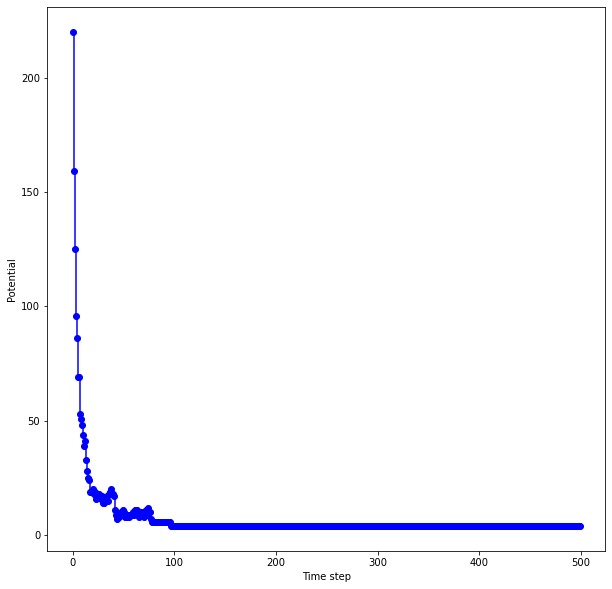

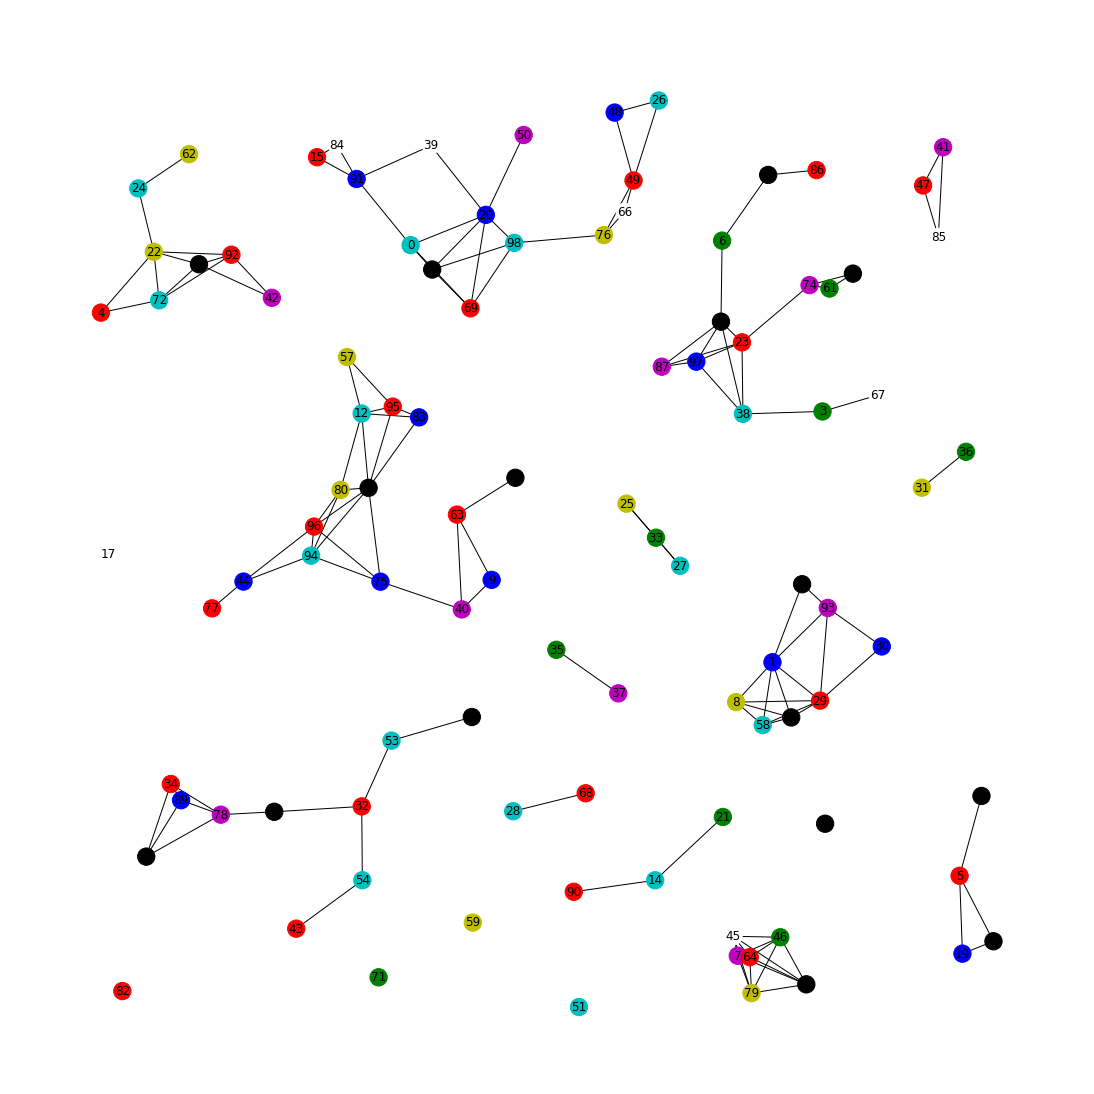

In [ ]:
getValueAndPlots(states_graphs,500,10*t)